# Introdução

Notebook com os gráficos utilizados na seção de fatos estilizados da dissertação.

## Pacotes

In [1]:
%config InlineBackend.figure_format = 'retina'
from datetime import datetime as dt
t1 = dt.now()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import pandas_datareader.data as web

from scipy.interpolate import make_interp_spline, BSpline #Smooth plot

sns.set(style="whitegrid")
sns.set_context('talk')

/home/gpetrini/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Funções e variáveis

In [2]:
def crise_subprime(axes, alpha=0.4):
    axes.axvspan(
    xmin='2007-12-01', 
    xmax='2009-06-01',
    color='gray', 
    label='subprime crisis',
    zorder=0,
    alpha=alpha
)

In [3]:
def crises(axes, color='lightgray', alpha=0.4):
    axes.axvspan(xmin = "1953-07", xmax='1954-04', color = color, alpha=alpha, label = 'Recession')
    axes.axvspan(xmin = "1957-08", xmax='1958-05', color = color, alpha=alpha, label = '')
    axes.axvspan(xmin = "1960-05", xmax='1961-02', color = color, alpha=alpha, label = '')
    axes.axvspan(xmin = "1969-12", xmax='1970-11', color = color, alpha=alpha, label = '')
    axes.axvspan(xmin = "1973-11", xmax='1975-03', color = color, alpha=alpha, label = '')
    axes.axvspan(xmin = "1980-01", xmax='1980-07', color = color, alpha=alpha, label = '')
    axes.axvspan(xmin = "1981-07", xmax='1982-01', color = color, alpha=alpha, label = '')
    axes.axvspan(xmin = "1990-07", xmax='1991-03', color = color, alpha=alpha, label = '')
    axes.axvspan(xmin = "2001-03", xmax='2001-11', color = color, alpha=alpha, label = '')

In [4]:
start = dt(1949,1,1)
end = dt(2019,1,1)
recessions = web.get_data_fred('USRECM', start, end)
recessions.columns = ['Recessions']
recessions['xmin'] = False
recessions['xmax'] = False
for i in range(len(recessions['Recessions'])-1):
  recessions.iscopy = True
  if recessions['Recessions'].iloc[i] == 0 and recessions['Recessions'].iloc[i+1] == 1:
      recessions['xmin'].iloc[i+1] = True
  elif recessions['Recessions'].iloc[i] == 1 and recessions['Recessions'].iloc[i+1] == 0:
      recessions['xmax'].iloc[i+1] = True
recessions.head()

/home/gpetrini/.local/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Recessions   xmin   xmax
DATE                                
1949-01-01           1  False  False
1949-02-01           1  False  False
1949-03-01           1  False  False
1949-04-01           1  False  False
1949-05-01           1  False  False

In [5]:
def recessions_bars(ax):
    import matplotlib.pyplot as plt
    xmin = recessions[recessions['xmin'] == True]['xmin']
    xmax = recessions[recessions['xmax'] == True]['xmax']
    
    for i in range(len(xmax)):
        ax.axvspan(xmin = xmin.index[i], xmax = xmax.index[i], alpha=.3, color='k')
        
print("Início Recession: " + str(recessions['xmin'][recessions['xmin'] == True].index))
print("Fim Recession: " + str(recessions['xmax'][recessions['xmax'] == True].index))

Início Recession: DatetimeIndex(['1953-07-01', '1957-08-01', '1960-04-01', '1969-12-01',
               '1973-11-01', '1980-01-01', '1981-07-01', '1990-07-01',
               '2001-03-01', '2007-12-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)
Fim Recession: DatetimeIndex(['1949-11-01', '1954-06-01', '1958-05-01', '1961-03-01',
               '1970-12-01', '1975-04-01', '1980-08-01', '1982-12-01',
               '1991-04-01', '2001-12-01', '2009-07-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)


In [6]:
def default_plot():
  plt.xlabel('')
  sns.set_context('talk')
  plt.rcParams['axes.edgecolor']='#333F4B'
  plt.rcParams['axes.linewidth']=0.8
  plt.rcParams['xtick.color']='#333F4B'
  plt.rcParams['ytick.color']='#333F4B'
  ax.grid(False)
  ax.spines['top'].set_color('none')
  ax.spines['right'].set_color('none')
  ax.spines['left'].set_smart_bounds(True)
  ax.spines['bottom'].set_smart_bounds(True)
  sns.despine()

In [7]:
def salvar_grafico(file_name, extension="eps", pasta="../figs/"):
    fig.savefig(pasta + file_name + '.' + extension, dpi = 600, bbox_inches = 'tight', format=extension,
    pad_inches = 0.2, transparent = False,)

# Saldo financeiro líquido

In [8]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'W995RC1Q027SBEA', # Domestic business
        'W996RC1Q027SBEA', # Households and institutions
        'AD01RC1Q027SBEA', # Government
        'NETFI', # Balance on Current Account, NIPA's
        'GDP', # Gross Domestic Product
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Firmas',
    'Famílias',
    'Governo',
    'Setor Externo',
    'GDP'
]
df.index.name = ''

df = df.dropna()
df['Setor Externo'] = -df['Setor Externo']
df['Soma'] = df.sum(axis='columns')
df = df.apply(lambda x: x/df['GDP'])

df['Setor Privado'] = df['Firmas'] + df['Famílias']
#df = -df

df.head()

Firmas  Famílias   Governo  Setor Externo  GDP      Soma  \
                                                                         
1960-01-01 -0.014306  0.031884 -0.014142      -0.003437  1.0  1.000000   
1960-04-01 -0.008300  0.032069 -0.020587      -0.003184  1.0  0.999998   
1960-07-01 -0.003598  0.037483 -0.026164      -0.007724  1.0  0.999998   
1960-10-01  0.006018  0.036583 -0.033560      -0.009041  1.0  1.000000   
1961-01-01  0.004259  0.043808 -0.038090      -0.009978  1.0  0.999998   

            Setor Privado  
                           
1960-01-01       0.017579  
1960-04-01       0.023769  
1960-07-01       0.033885  
1960-10-01       0.042601  
1961-01-01       0.048066

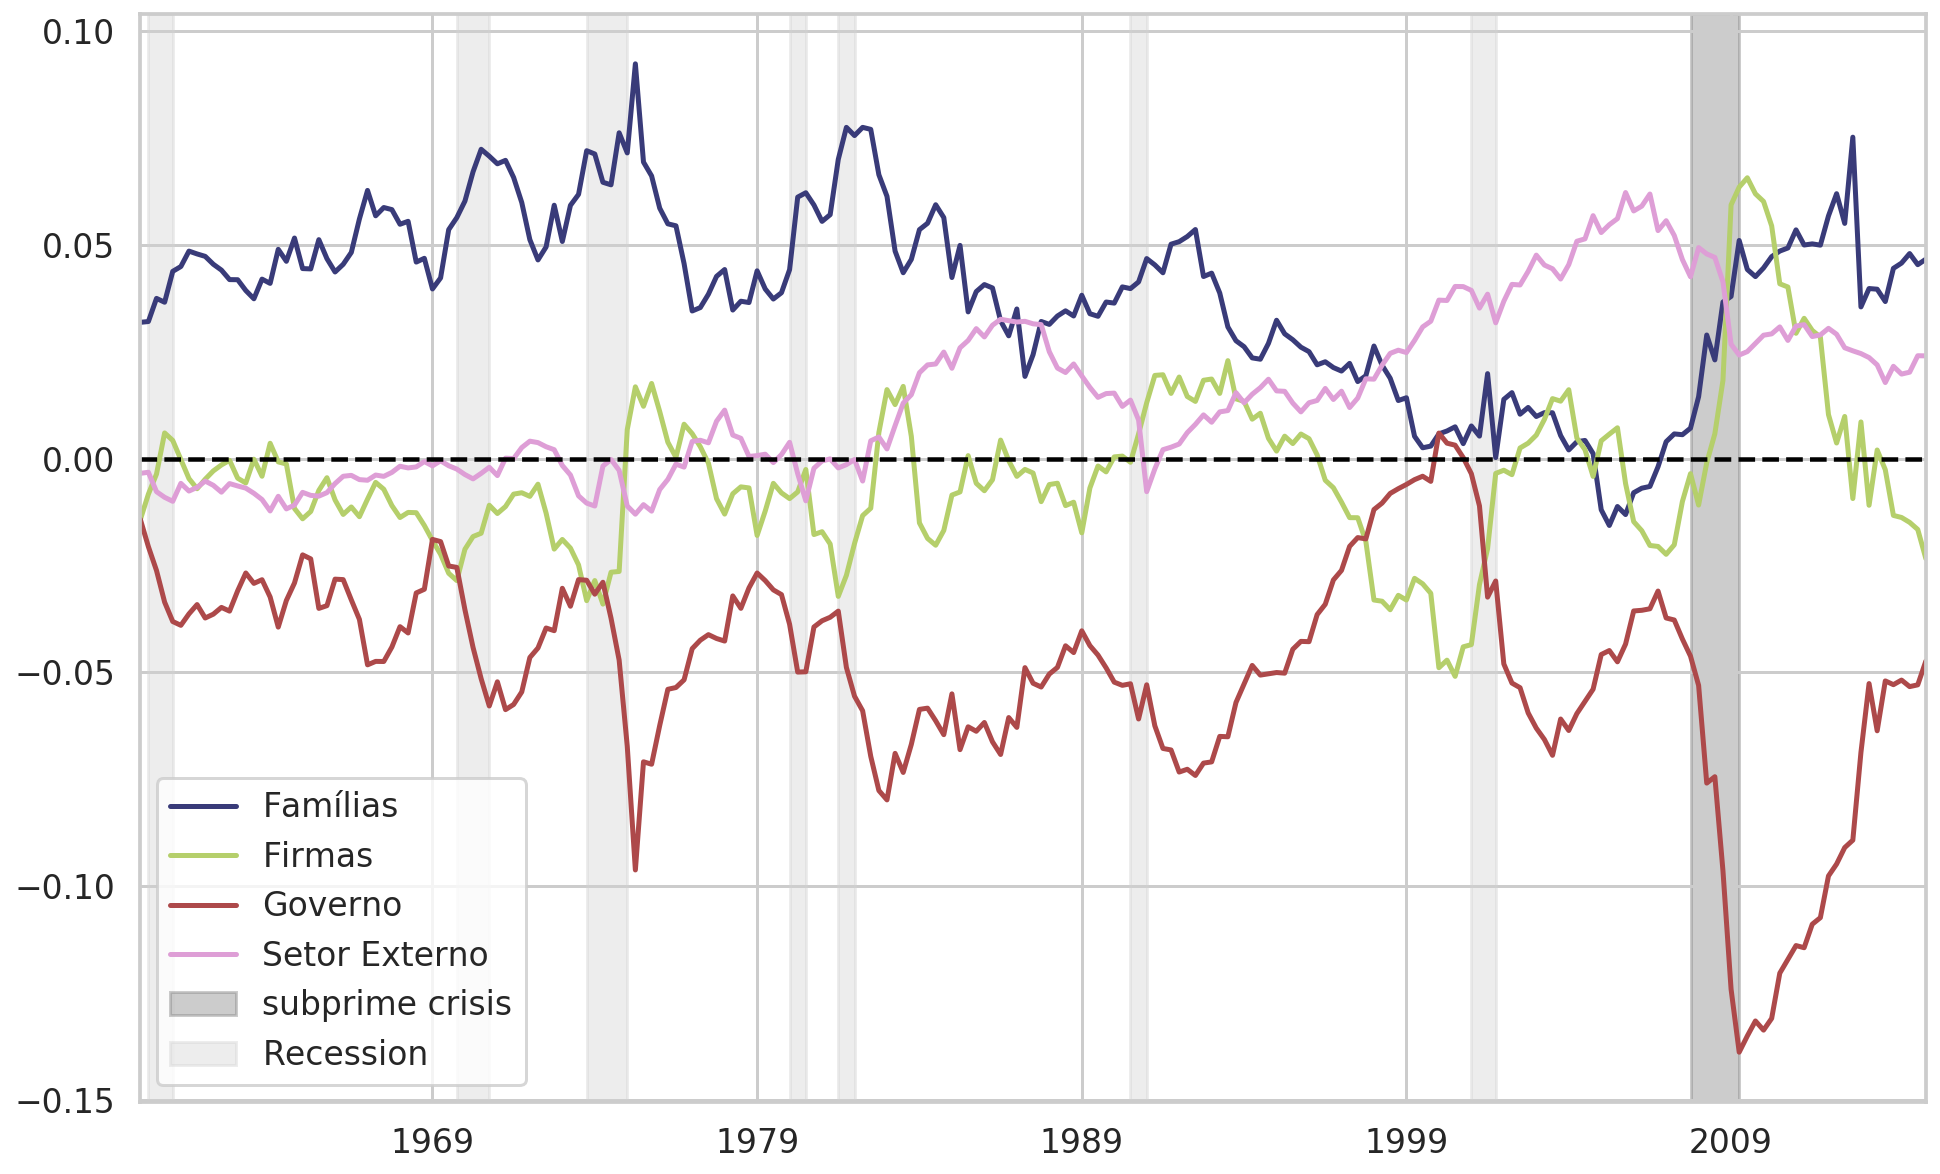

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [9]:
fig, ax = plt.subplots(figsize=(16, 10))

df[[
    'Famílias', 'Firmas',
    'Governo', 
    'Setor Externo'
]].plot(
    ax=ax,
    cmap="tab20b", 
    linewidth=2.5
)

crise_subprime(axes=ax)
crises(axes=ax)
ax.legend()

ax.axhline(y=0, color='black', ls='--')

plt.show()
salvar_grafico("Saldos_Financeiros")

/home/gpetrini/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


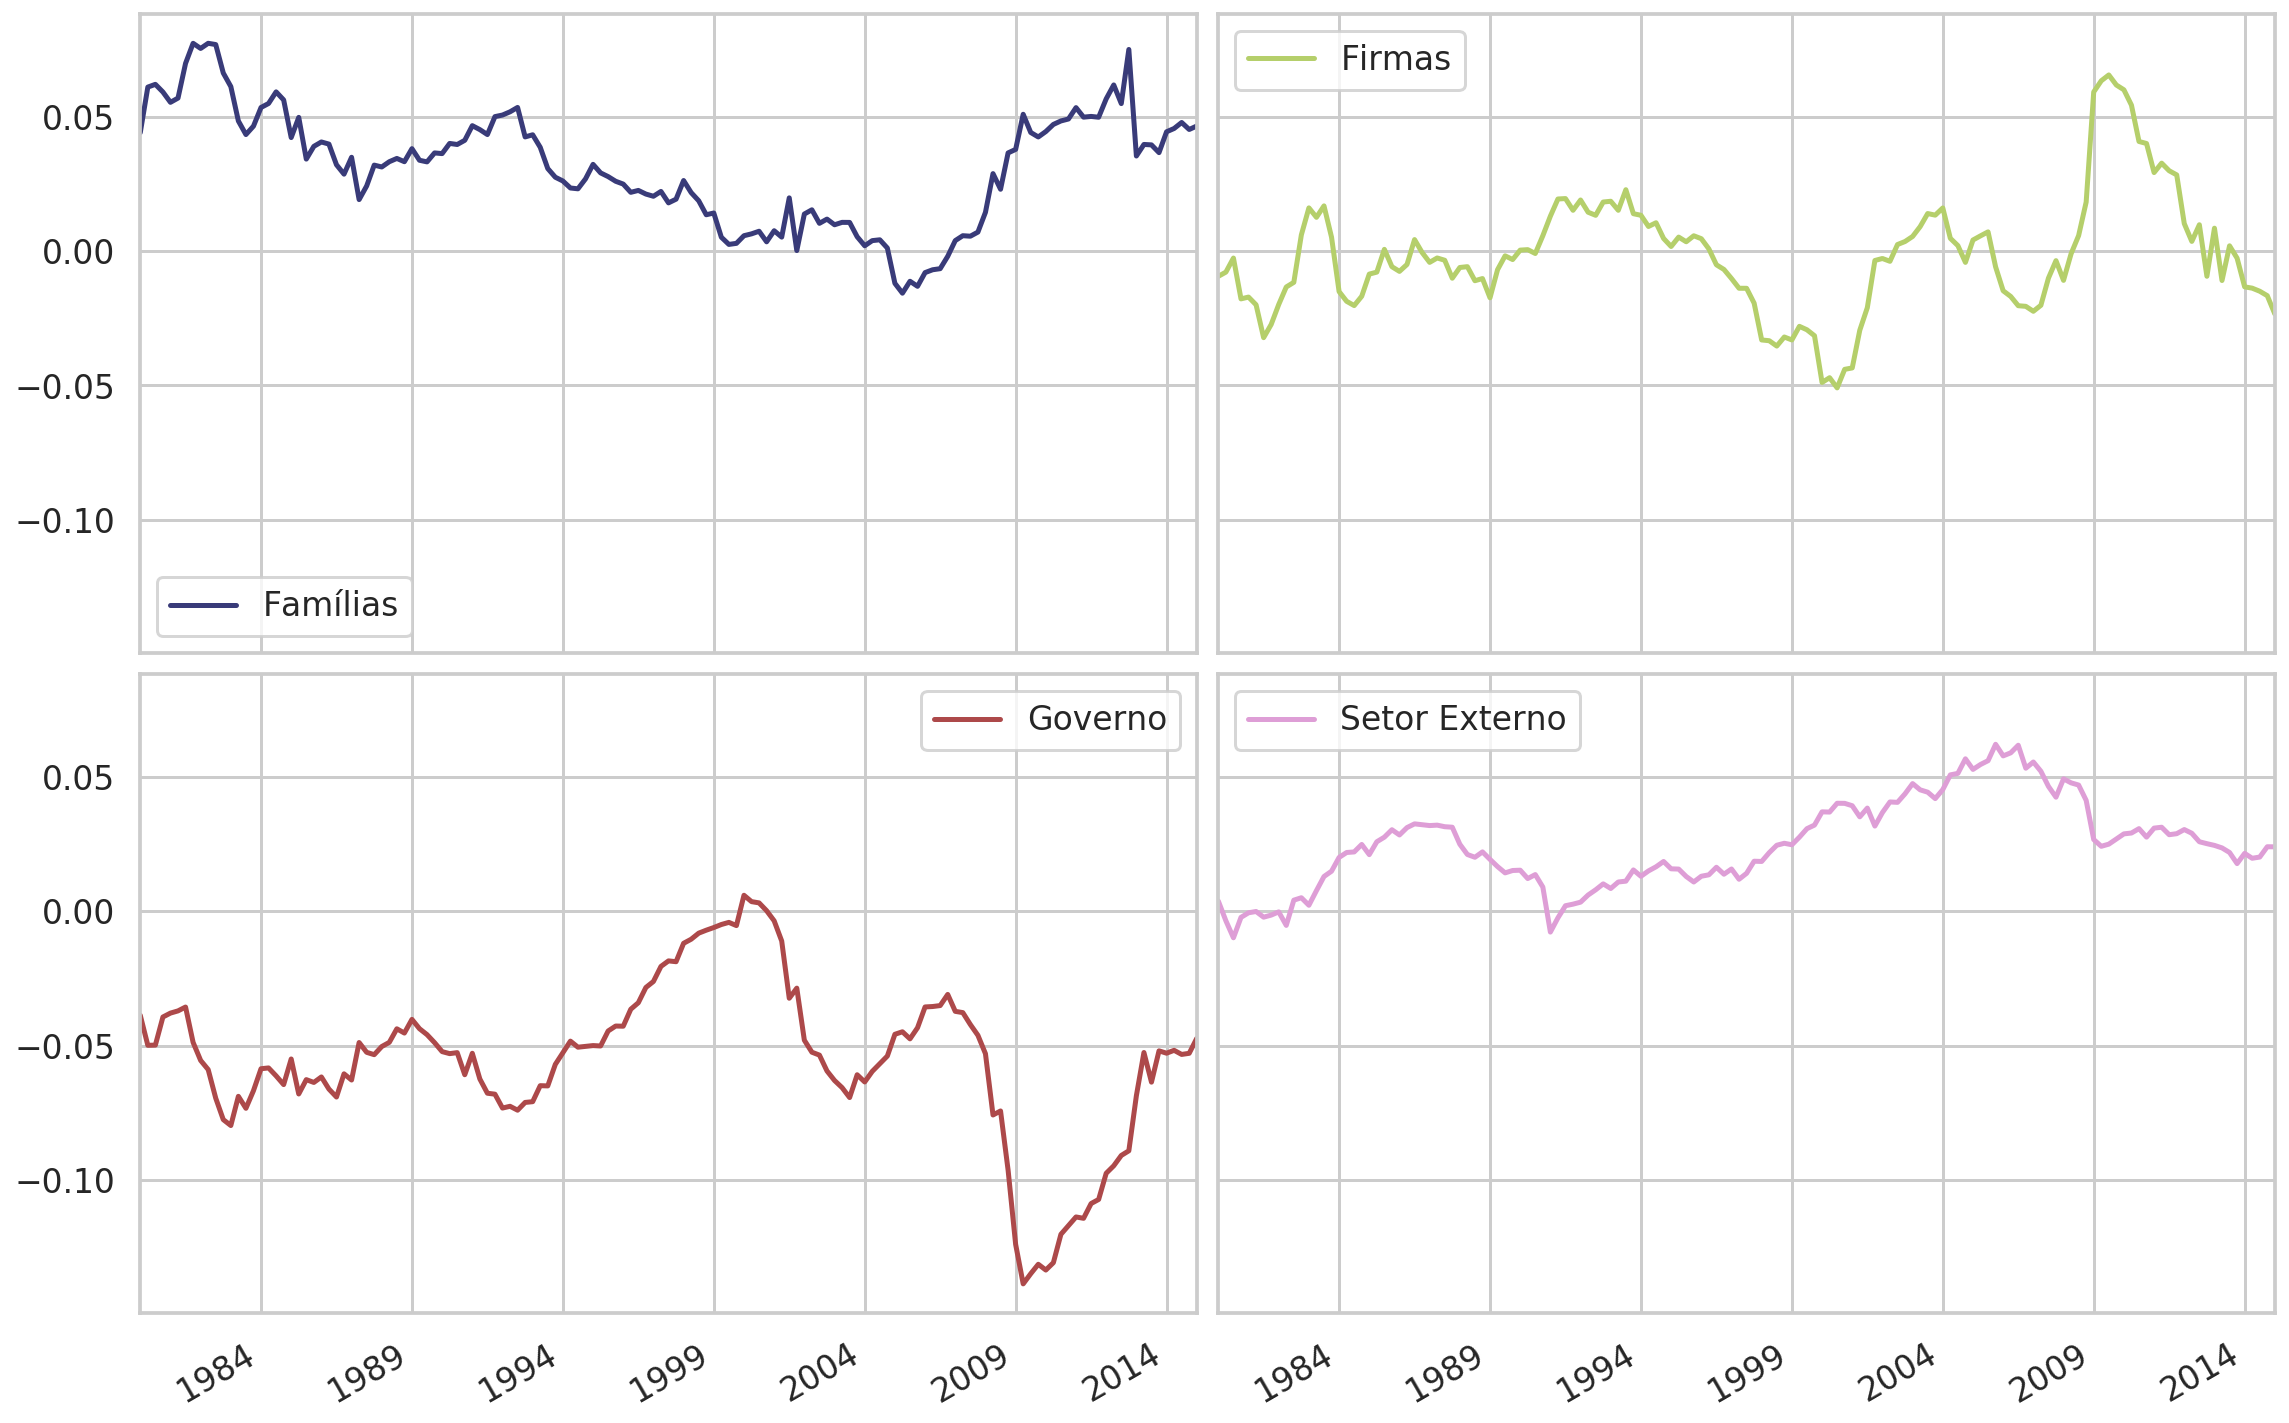

In [10]:
fig, ax = plt.subplots(figsize=(16, 10))

df.loc['1980':, [
    'Famílias', 'Firmas',
    'Governo', 
    'Setor Externo'
]].plot(
    ax=ax,
    cmap="tab20b", 
    linewidth=2.5,
    subplots=True,
    sharex=True, sharey=True,
    layout=(2,2)
)

crises(ax)
crise_subprime(ax)
ax.legend()

ax.axhline(y=0, color='black', ls='--')
plt.tight_layout()

plt.show()

In [11]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'TFAABSHNO', # total financial assets, Level
        'BOGZ1LM152010005Q', # nonfinancial assets, Market value levels
        'TLBSHNO', # total liabilities, Level
        'TNWBSHNO', # net worth, Level
        'TABSHNO', # Households and nonprofit organizations; total assets, Level
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Financial Assets',
    'Non Financial Assets',
    'Passivos',
    'Net Worth',
    'Riqueza total'
]
df.index.name = ''
df['Non Financial Assets'] = df['Non Financial Assets']/1000

df = df.dropna()
df = df.apply(lambda x: x/df['Riqueza total'])*100

df.head()

Financial Assets  Non Financial Assets  Passivos  Net Worth  \
                                                                          
1947-10-01         72.754449             27.245551  4.508567  95.491433   
1948-10-01         71.278195             28.721805  5.046066  94.953934   
1949-10-01         70.235026             29.764974  5.519722  94.480278   
1950-10-01         68.970249             31.029751  6.152598  93.847402   
1951-10-01         68.452832             31.547168  6.263377  93.736623   

            Riqueza total  
                           
1947-10-01          100.0  
1948-10-01          100.0  
1949-10-01          100.0  
1950-10-01          100.0  
1951-10-01          100.0

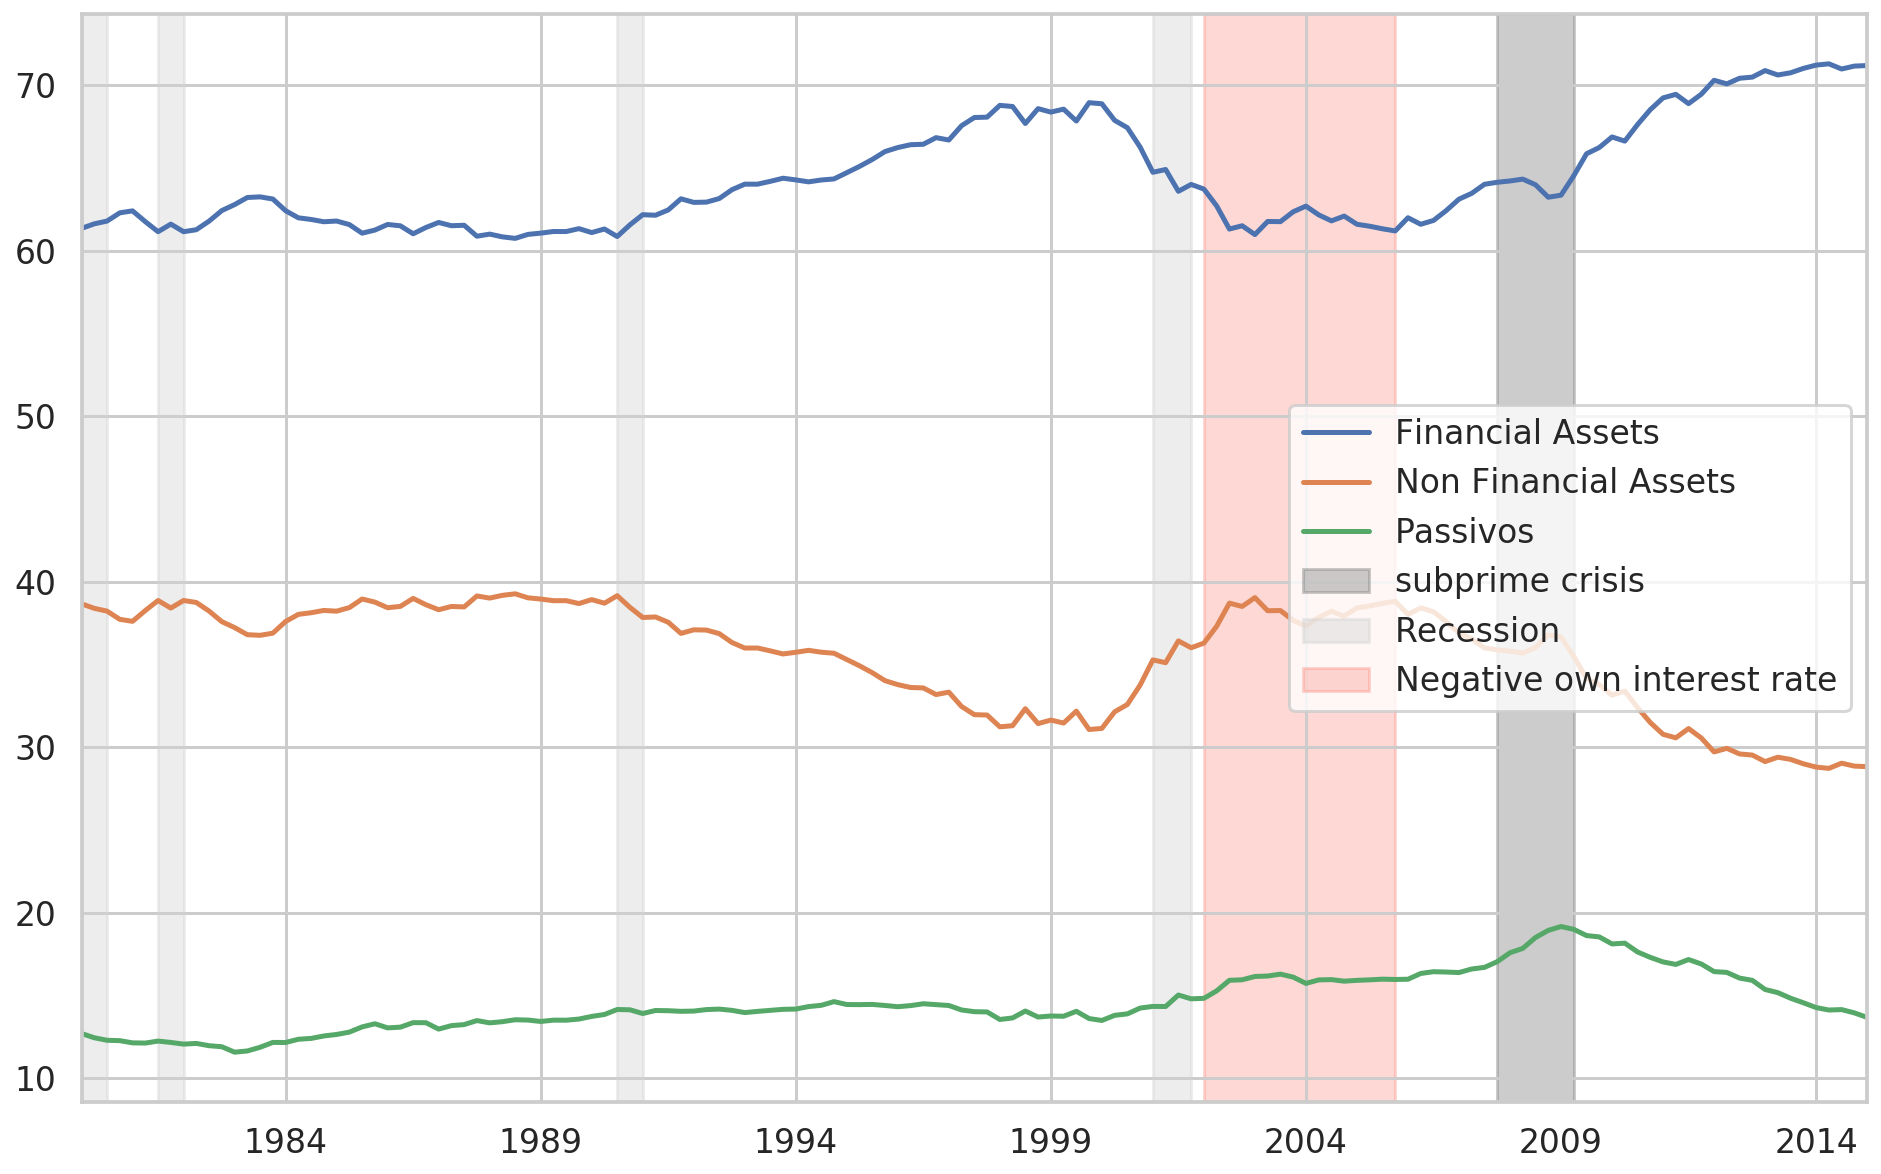

In [12]:
fig, ax = plt.subplots(figsize=(16, 10))

df.drop(['Riqueza total', 'Net Worth'],'columns')[df.index>='1980-01-01'].plot(
    ax=ax,
    linewidth=2.5,
)

crise_subprime(ax)
crises(ax)
ax.axvspan(
    xmin='2002-01-01', 
    xmax='2005-12-01',
    color='salmon', 
    label='Negative own interest rate',
    zorder=-1,
    alpha=.3
)

ax.legend()

plt.show()

# Consumption e Endividamento das famílias

## Endividamento das famílias

In [13]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'HHMSDODNS', # home mortgages; liability, Level
        'HCCSDODNS', # consumer credit; liability, Level
        'TNWBSHNO', # net worth, Level
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Mortgages',
    'Crédito',
    'Net Worth',
]

df.index.name = ''

df = df.dropna()
df = df.apply(lambda x: x/df['Net Worth']).drop(['Net Worth'], 'columns')

df.head()

Mortgages   Crédito
                               
1947-10-01   0.028721  0.013512
1948-10-01   0.032229  0.015749
1949-10-01   0.034654  0.017949
1950-10-01   0.038626  0.020441
1951-10-01   0.040444  0.019796

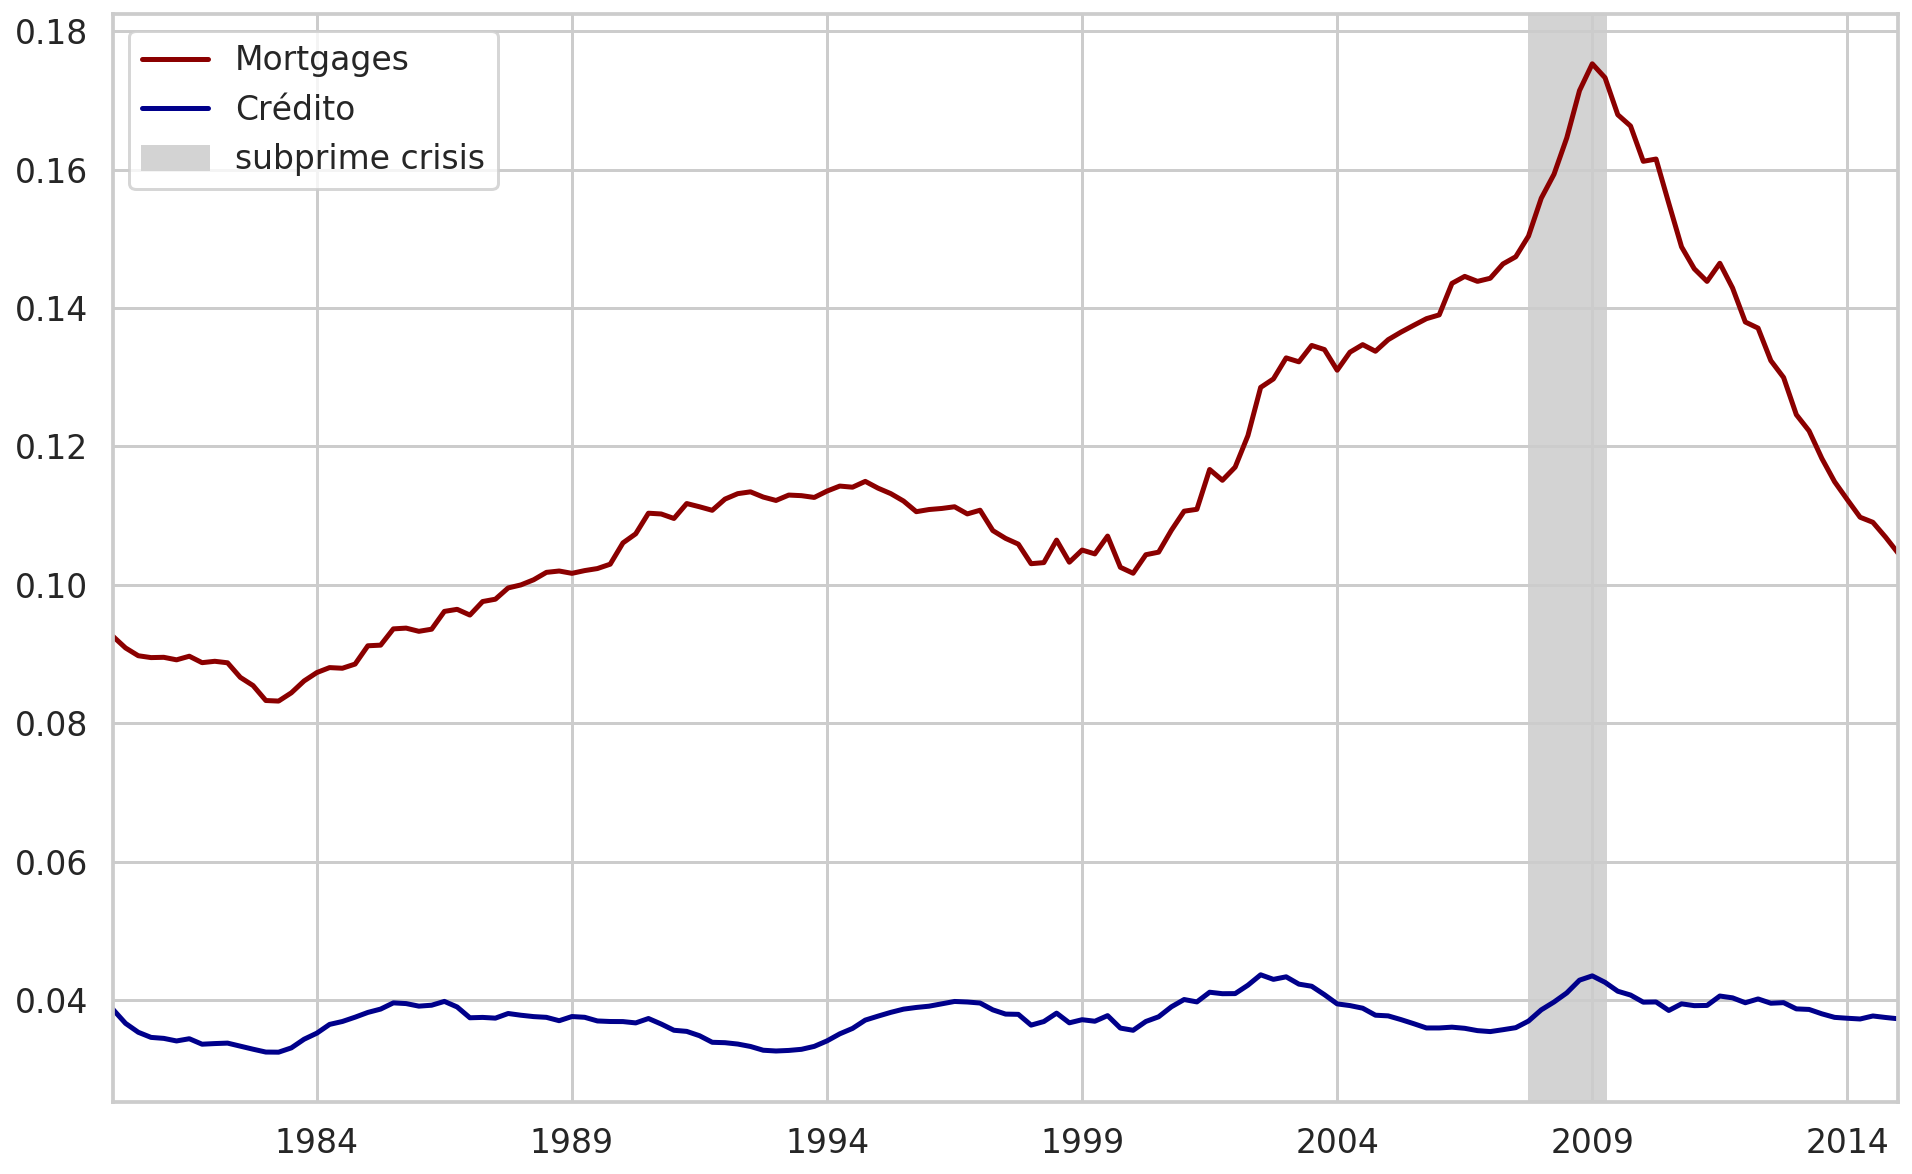

In [14]:
fig, ax = plt.subplots(figsize=(16, 10))

df.iloc[df.index>='1980-01',:].plot(
    ax=ax,
    color=('darkred', 'darkblue'),
    linewidth=2.5,
)

ax.axvspan(
    xmin='2007-12-01', 
    xmax='2009-06-01',
    color='lightgray', 
    label='subprime crisis',
    zorder=0
)
ax.legend()

plt.show()

In [15]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'CMDEBT', # debt securities and loans; liability, Level 
        #'PCEC', # Personal Consumption Expenditures # CHECAR
        'DPHCRC1A027NBEA', # Personal consumption expenditures: Household consumption expenditures
        'TNWBSHNO', # net worth, Level
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Dívida',
    'Consumption',
    'Net Worth',
]

df.index.name = ''

df = df.dropna()
df = df.apply(lambda x: x/df['Net Worth']).drop(['Net Worth'], 'columns')

df.head()

Dívida  Consumption
                                 
1952-01-01  0.066000     0.166675
1953-01-01  0.073999     0.170403
1954-01-01  0.078072     0.167813
1955-01-01  0.083533     0.169346
1956-01-01  0.088651     0.162732

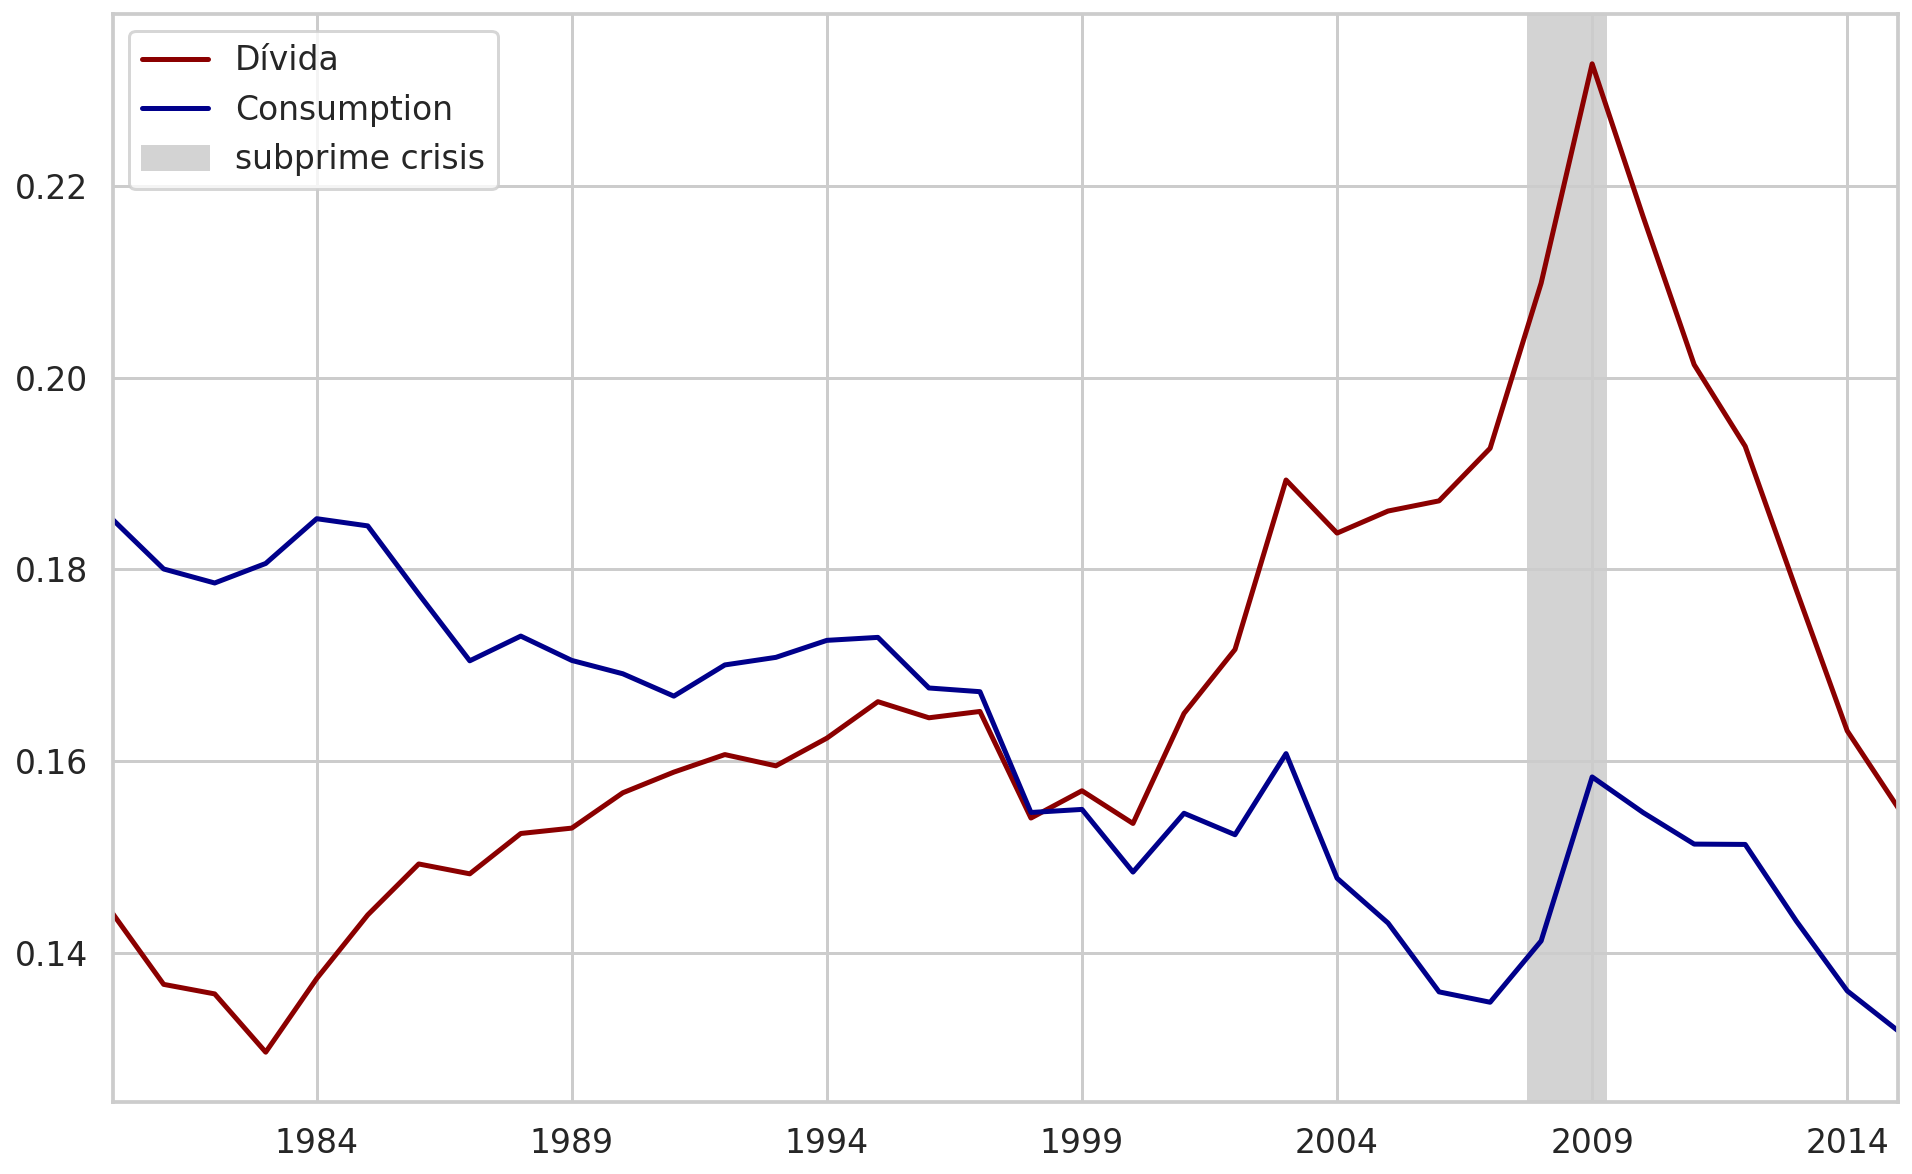

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))

df.iloc[df.index>='1980-01',:].plot(
    ax=ax,
    color=('darkred', 'darkblue'),
    linewidth=2.5,
)

ax.axvspan(
    xmin='2007-12-01', 
    xmax='2009-06-01',
    color='lightgray', 
    label='subprime crisis',
    zorder=0
)
ax.legend()

plt.show()

In [17]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'CMDEBT', # debt securities and loans; liability, Level 
        'CSUSHPINSA', # S&P/Case-Shiller U.S. National Home Price Index
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Household debt',
    'House prices',
]

for i in df.columns:
    df[i] = (df[i]/df[i]['2000-01-01'])*100

df.index.name = ''
df = df.resample("QS").mean().dropna()
df.head()

Household debt  House prices
                                        
1987-01-01       38.457941     64.132000
1987-04-01       39.632448     65.599667
1987-07-01       40.624038     67.240667
1987-10-01       41.026038     68.127000
1988-01-01       42.135434     68.955333

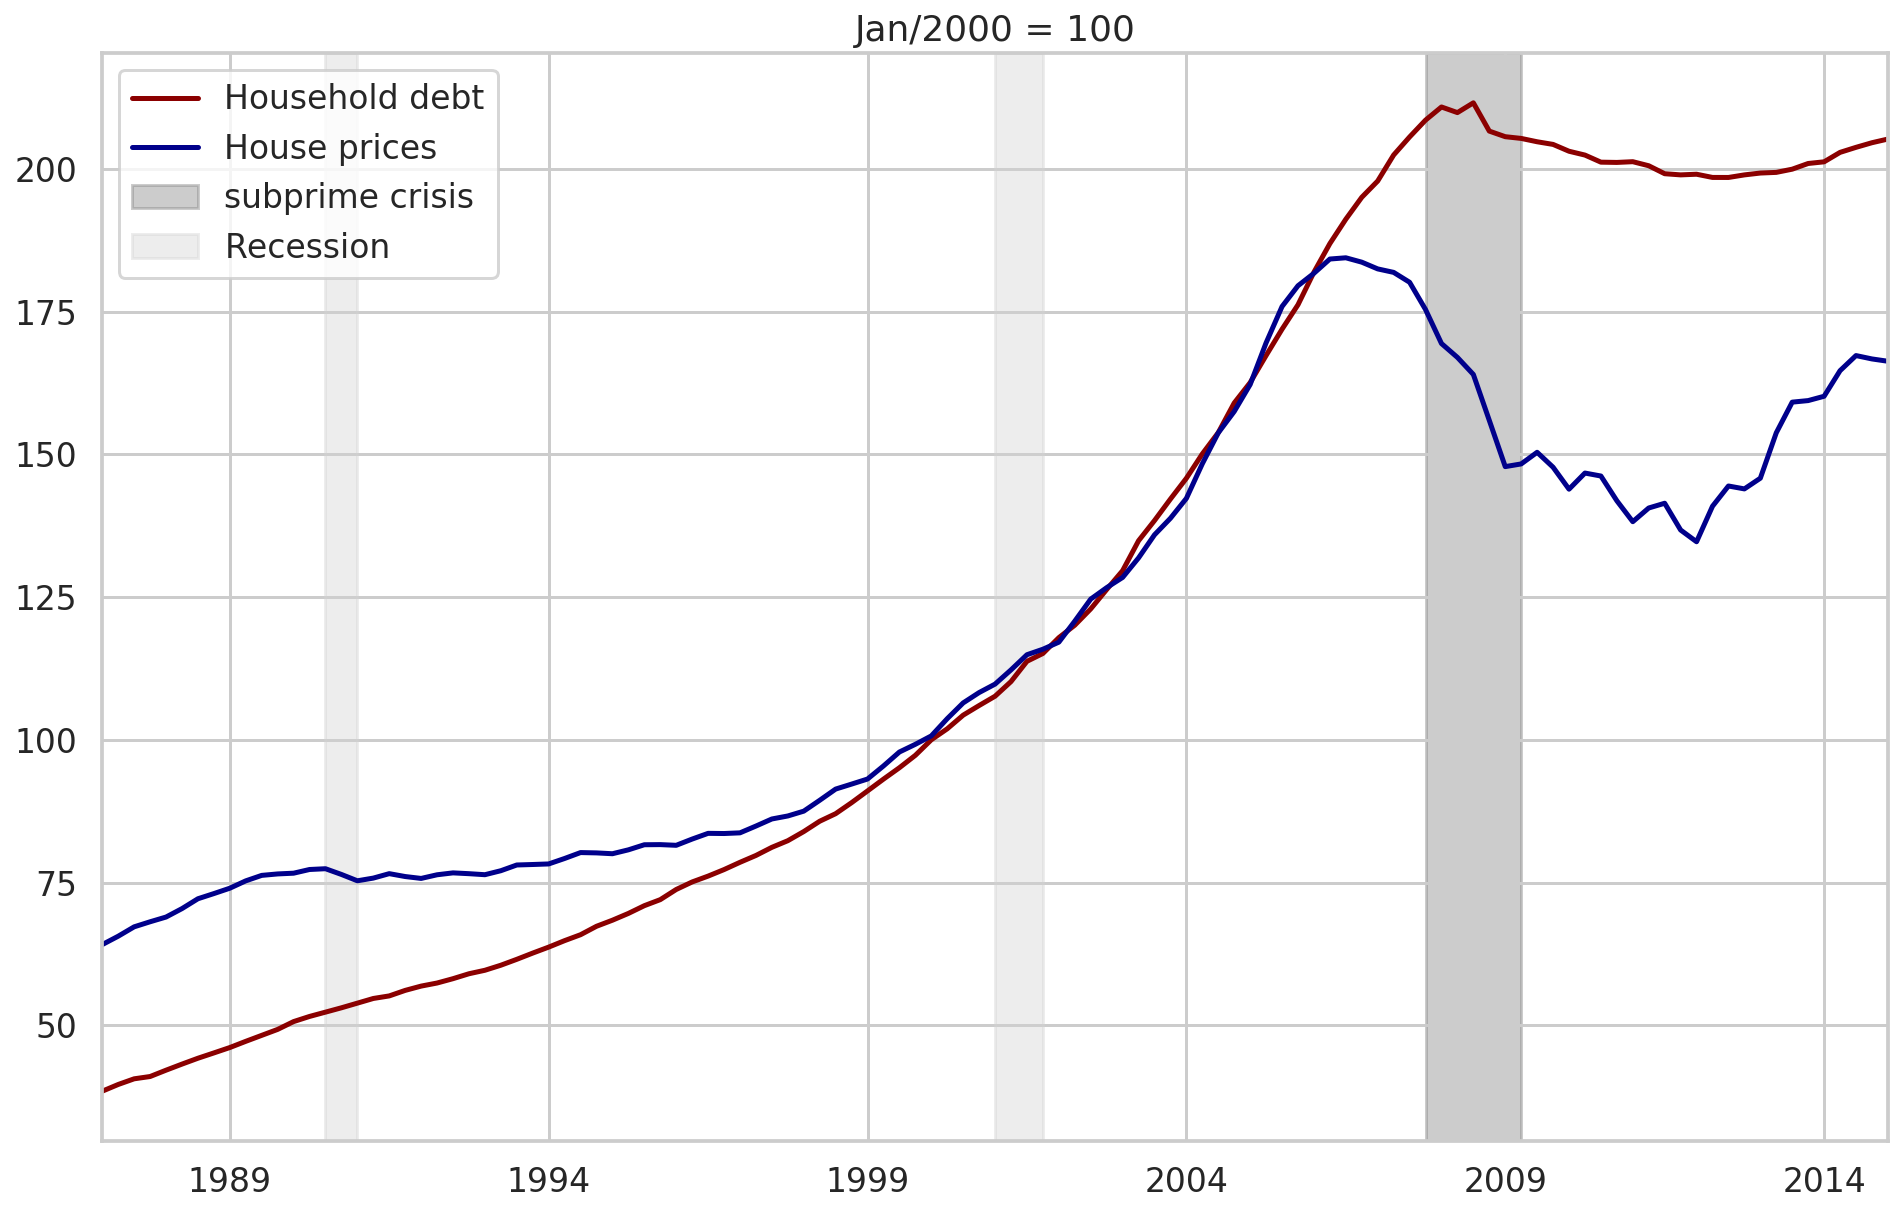

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [18]:
fig, ax = plt.subplots(figsize=(16, 10))

df.iloc[df.index>='1970-01',:].plot(
    ax=ax,
    color=('darkred', 'darkblue'),
    linewidth=2.5,
)

crise_subprime(ax)
crises(ax)
ax.legend()

ax.set_title('Jan/2000 = 100')
plt.show()
salvar_grafico(file_name="Divida_PrecoImoveis")

## Household credit

In [19]:
start = dt(1945, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'BOGZ1FL154104015Q', # home mortgages and consumer credit; liability, Level 
        'HHMSDODNS', # home mortgages; liability, Level
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Household credit',
    'Mortgages'
]

df.index.name = ''
df = df.pct_change(4).dropna()
df.head()

Household credit  Mortgages
                                       
1946-10-01          0.288991   0.234898
1947-01-01          0.288991   0.234898
1947-04-01          0.288991   0.234898
1947-07-01          0.288991   0.234898
1947-10-01          0.264258   0.223680

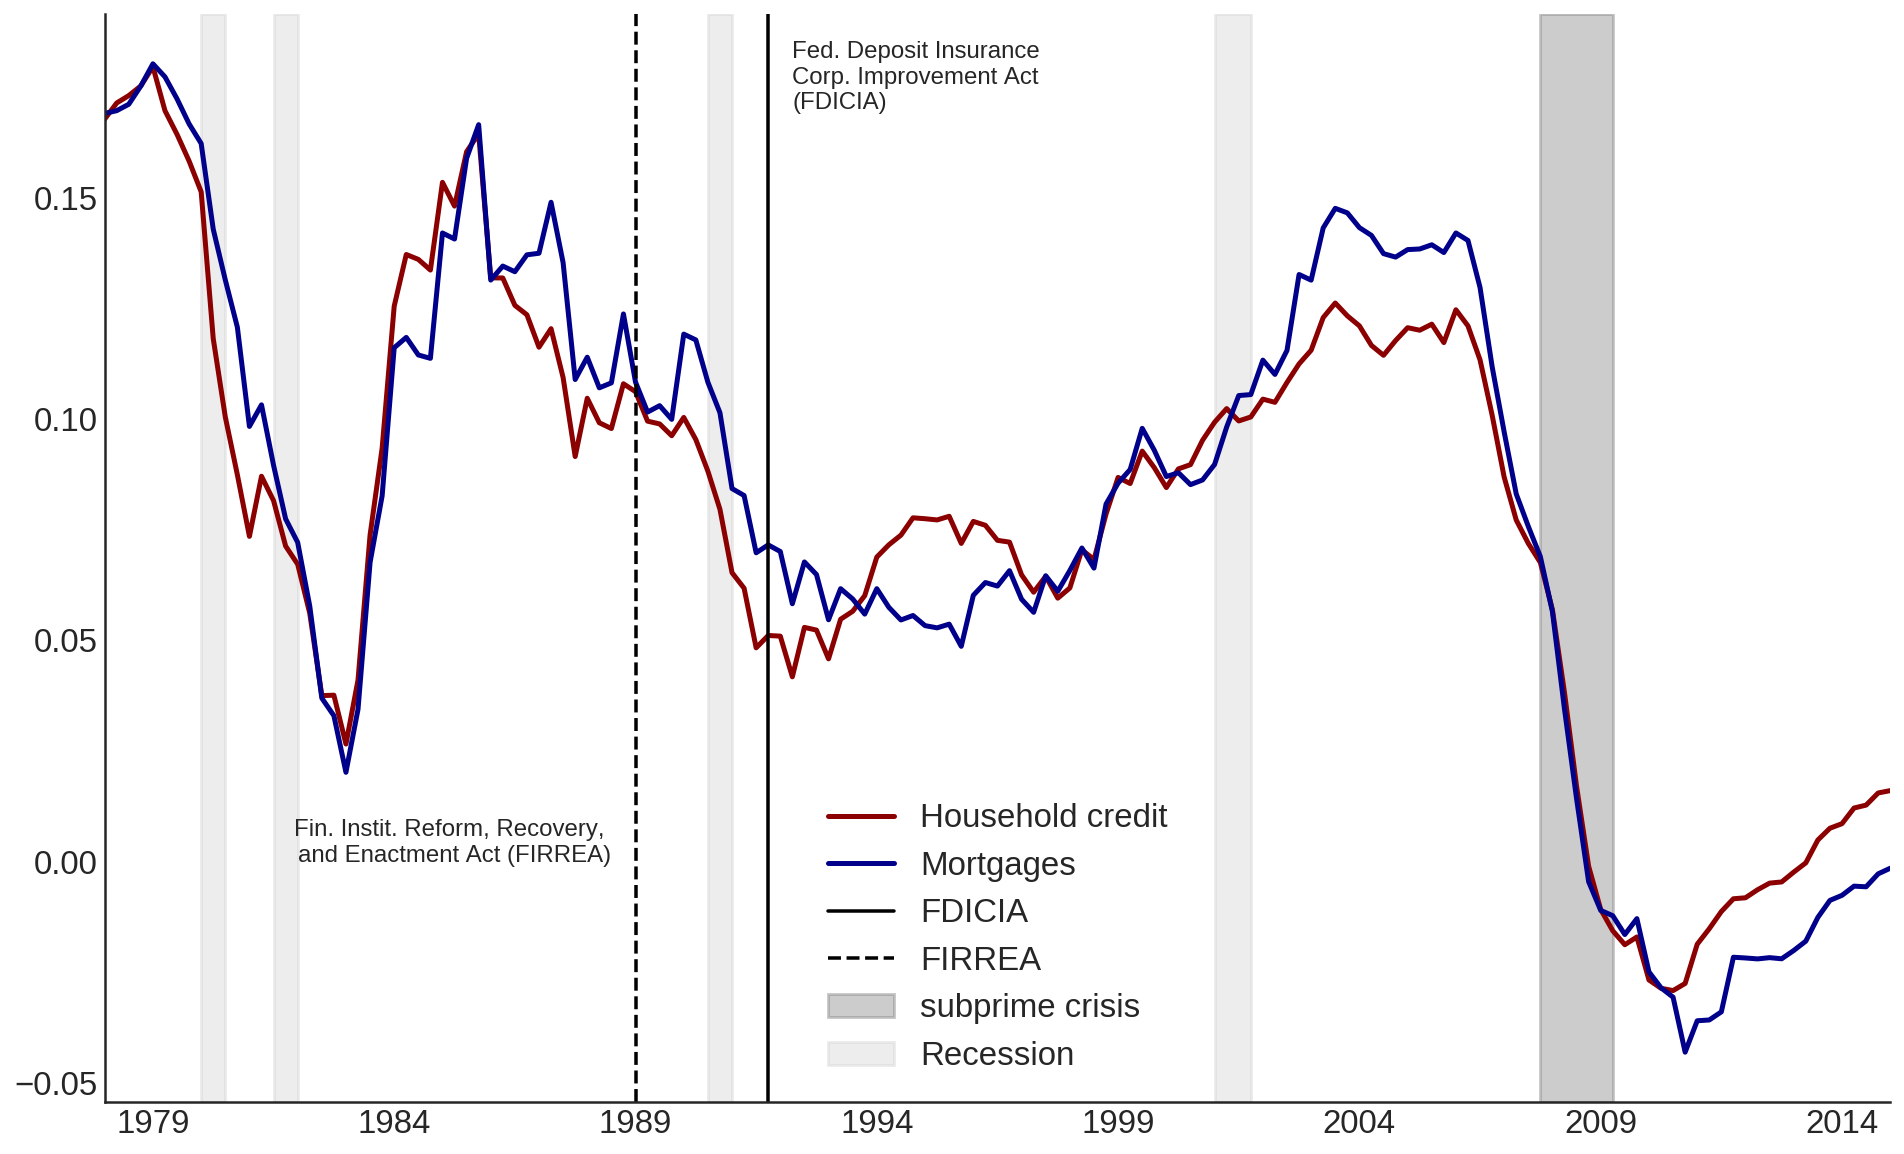

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [20]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=(16, 10))

df.iloc[df.index>='1978-01',:].plot(
    ax=ax,
    linewidth=2.5,
    color=('darkred', 'darkblue')
)

crise_subprime(ax)
crises(ax)
ax.axvline(
    x="1991-12-19", 
    label='FDICIA', 
    color='black', 
    ls='-', 
    linewidth=1.75
)
ax.axvline(
    x="1989-02-06", 
    label='FIRREA', 
    color='black', 
    ls='--', 
    linewidth=1.75
)

ax.legend()

ax.text(
    s = "Fed. Deposit Insurance \nCorp. Improvement Act \n(FDICIA)",
    y = 0.17,
    x="1992-06-01", 
    fontsize=12,
       )

ax.text(
    s = "Fin. Instit. Reform, Recovery, \nand Enactment Act (FIRREA)",
    y = 0.,
    x="1988-08-01", 
    fontsize=12,
    horizontalalignment='right'
       )

sns.despine()
plt.show()
salvar_grafico(file_name="FDICIA")

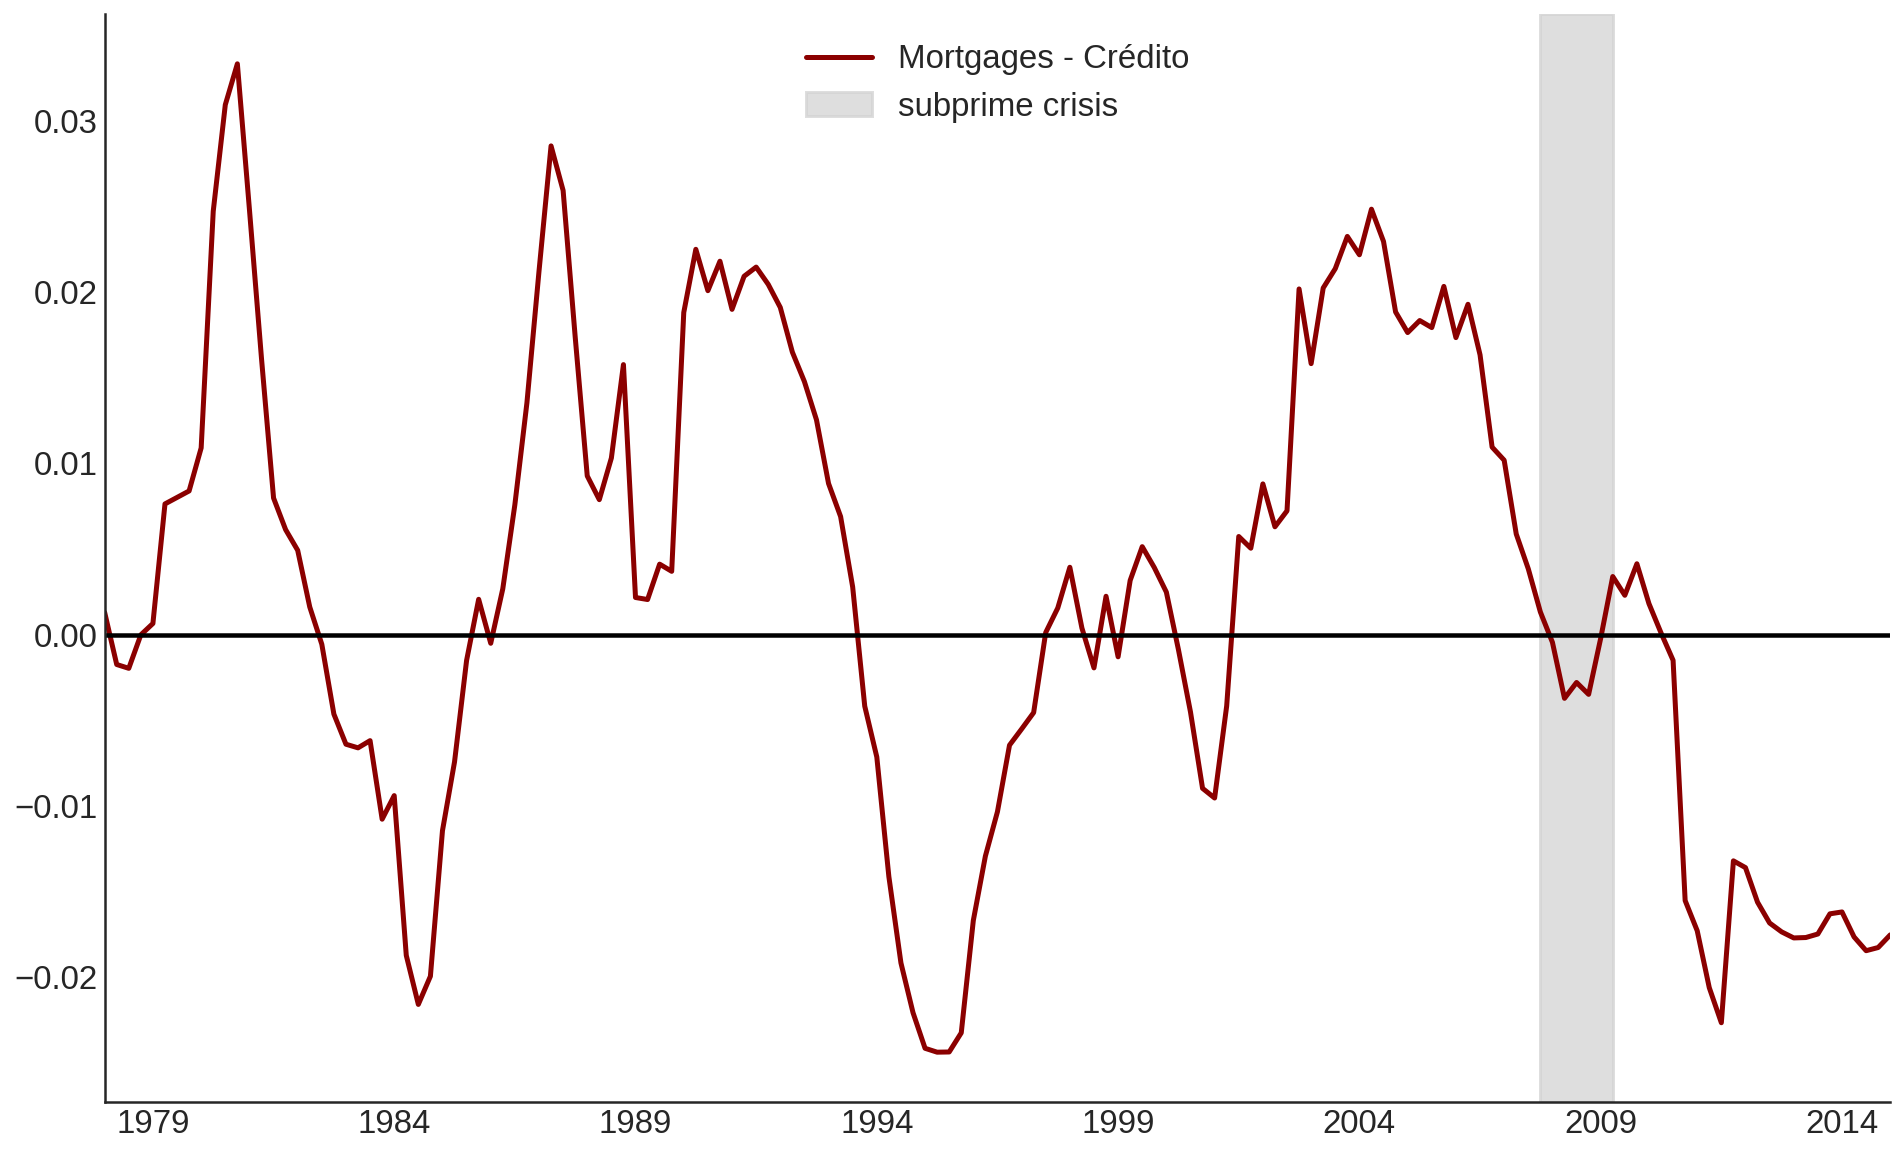

In [21]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots(figsize=(16, 10))

(df["Mortgages"] - df["Household credit"])[df.index>='1978-01'].plot(
    ax=ax,
    linewidth=2.5,
    color=('darkred'),
    label="Mortgages - Crédito"
)

ax.axvspan(
    xmin='2007-12-01', 
    xmax='2009-06-01',
    color='lightgray', 
    label='subprime crisis',
    alpha=.75,
    zorder=0,
)

ax.legend()
ax.axhline(y=0, color='black', ls='-')

sns.despine()
plt.show()

## Leverage

In [22]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'TDSP', # Household Debt Service Payments as a Percent of Disposable Personal Income
        'FODSP', # Household Financial Obligations as a percent of Disposable Personal Income
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Serviço da dívida/Disposable income',
    'Obrigações financeiras/Disposable income',
]
df.index.name = ''

for i in df.columns:
    df[i] = df[i]/(df[i][0])

df.head()

Serviço da dívida/Disposable income  \
                                                  
1980-01-01                             1.000000   
1980-04-01                             1.001993   
1980-07-01                             0.980279   
1980-10-01                             0.965815   
1981-01-01                             0.969081   

            Obrigações financeiras/Disposable income  
                                                      
1980-01-01                                  1.000000  
1980-04-01                                  1.005614  
1980-07-01                                  0.989803  
1980-10-01                                  0.978507  
1981-01-01                                  0.981765

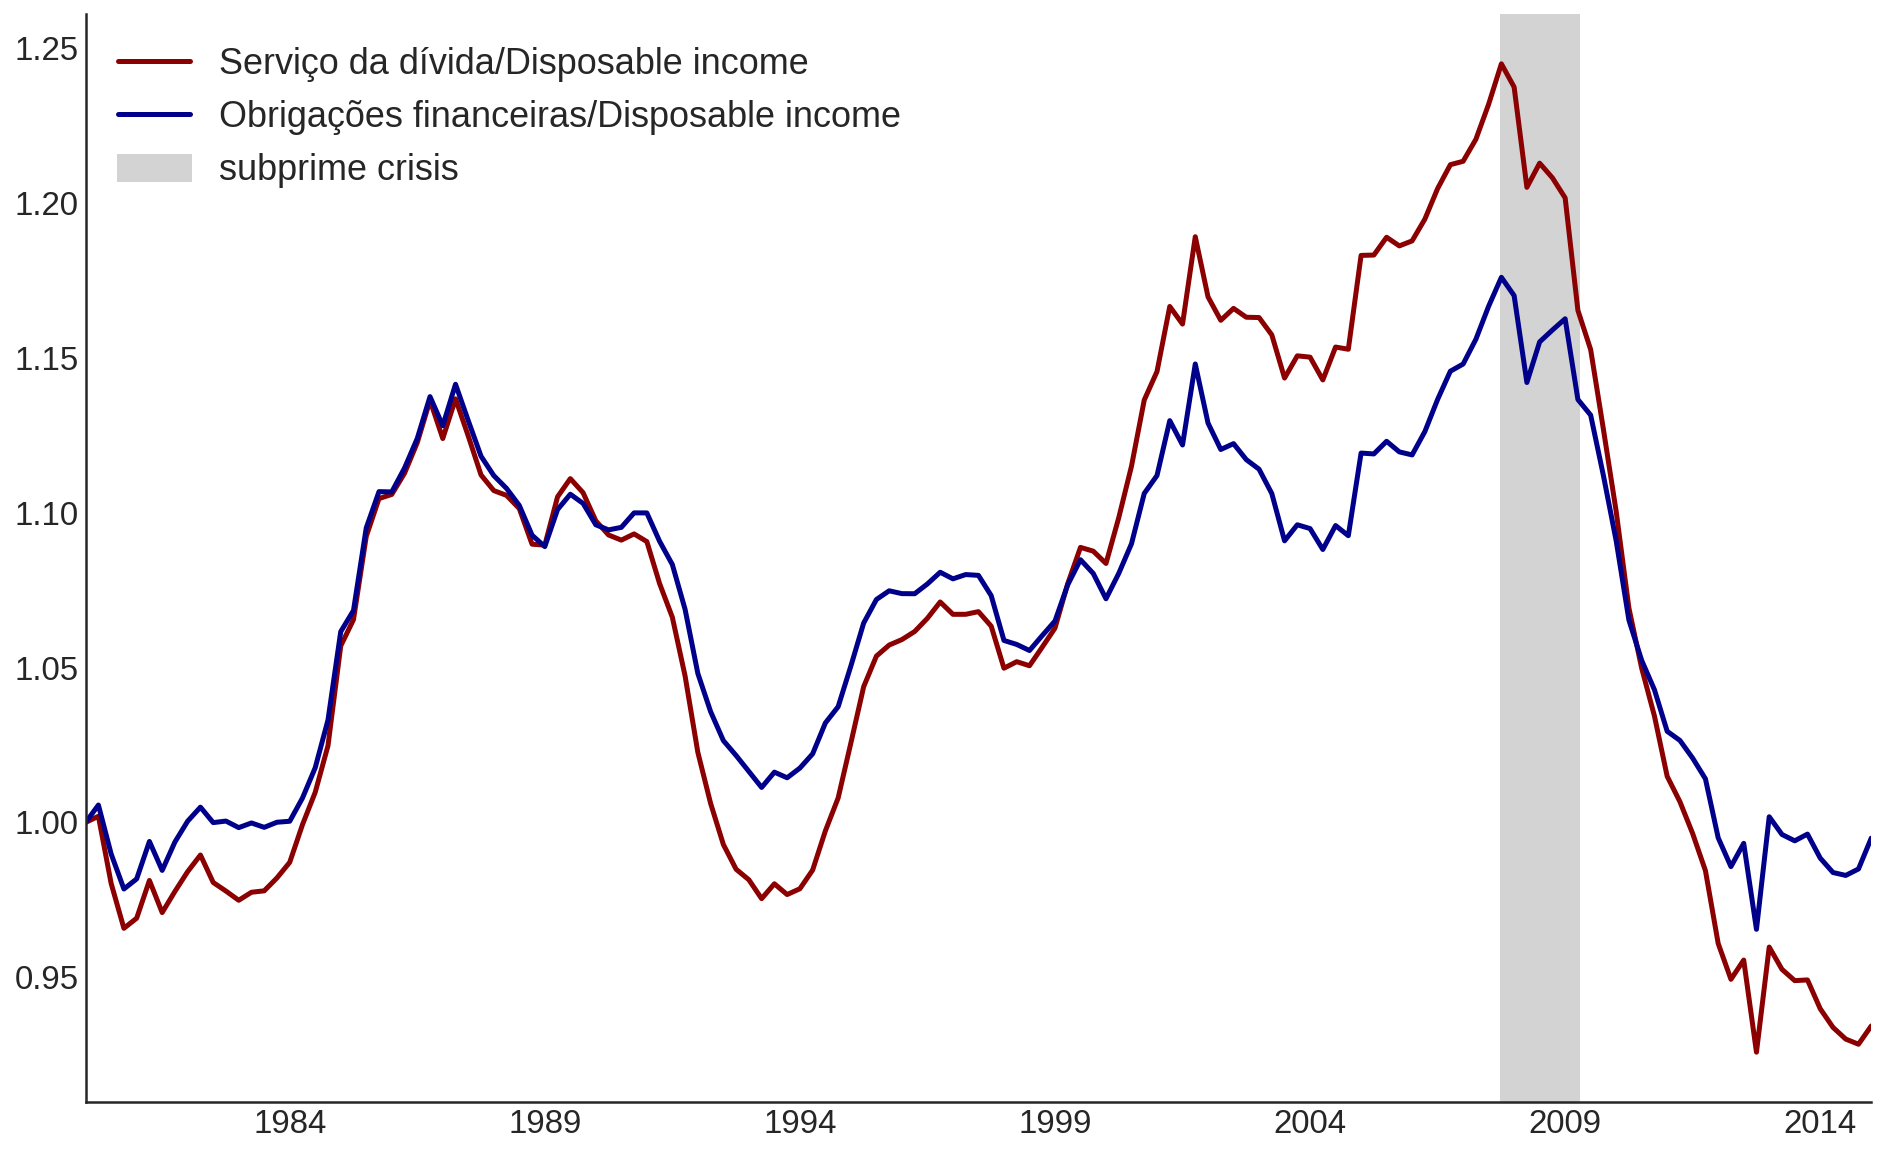

In [23]:
fig, ax = plt.subplots(figsize=(16, 10))

df.iloc[df.index>='1980-01',:].plot(
    ax=ax,
    color=('darkred', 'darkblue'),
    linewidth=2.5,
)

ax.axvspan(
    xmin='2007-12-01', 
    xmax='2009-06-01',
    color='lightgray', 
    label='subprime crisis',
    zorder=0
)
ax.legend(fontsize=18)

sns.despine()
plt.show()

In [24]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'TLBSHNO', # Households and nonprofit organizations; total liabilities, Level
        'TNWBSHNO', # Households and nonprofit organizations; net worth, Level
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Passivos',
    'Net Worth',
]
df.index.name = ''
df = df.dropna()

#for i in df.columns:
#    df[i] = df[i]/(df[i][0])
df = (df['Passivos']/df['Net Worth'])
df.head()


1947-10-01    0.047214
1948-10-01    0.053142
1949-10-01    0.058422
1950-10-01    0.065560
1951-10-01    0.066819
dtype: float64

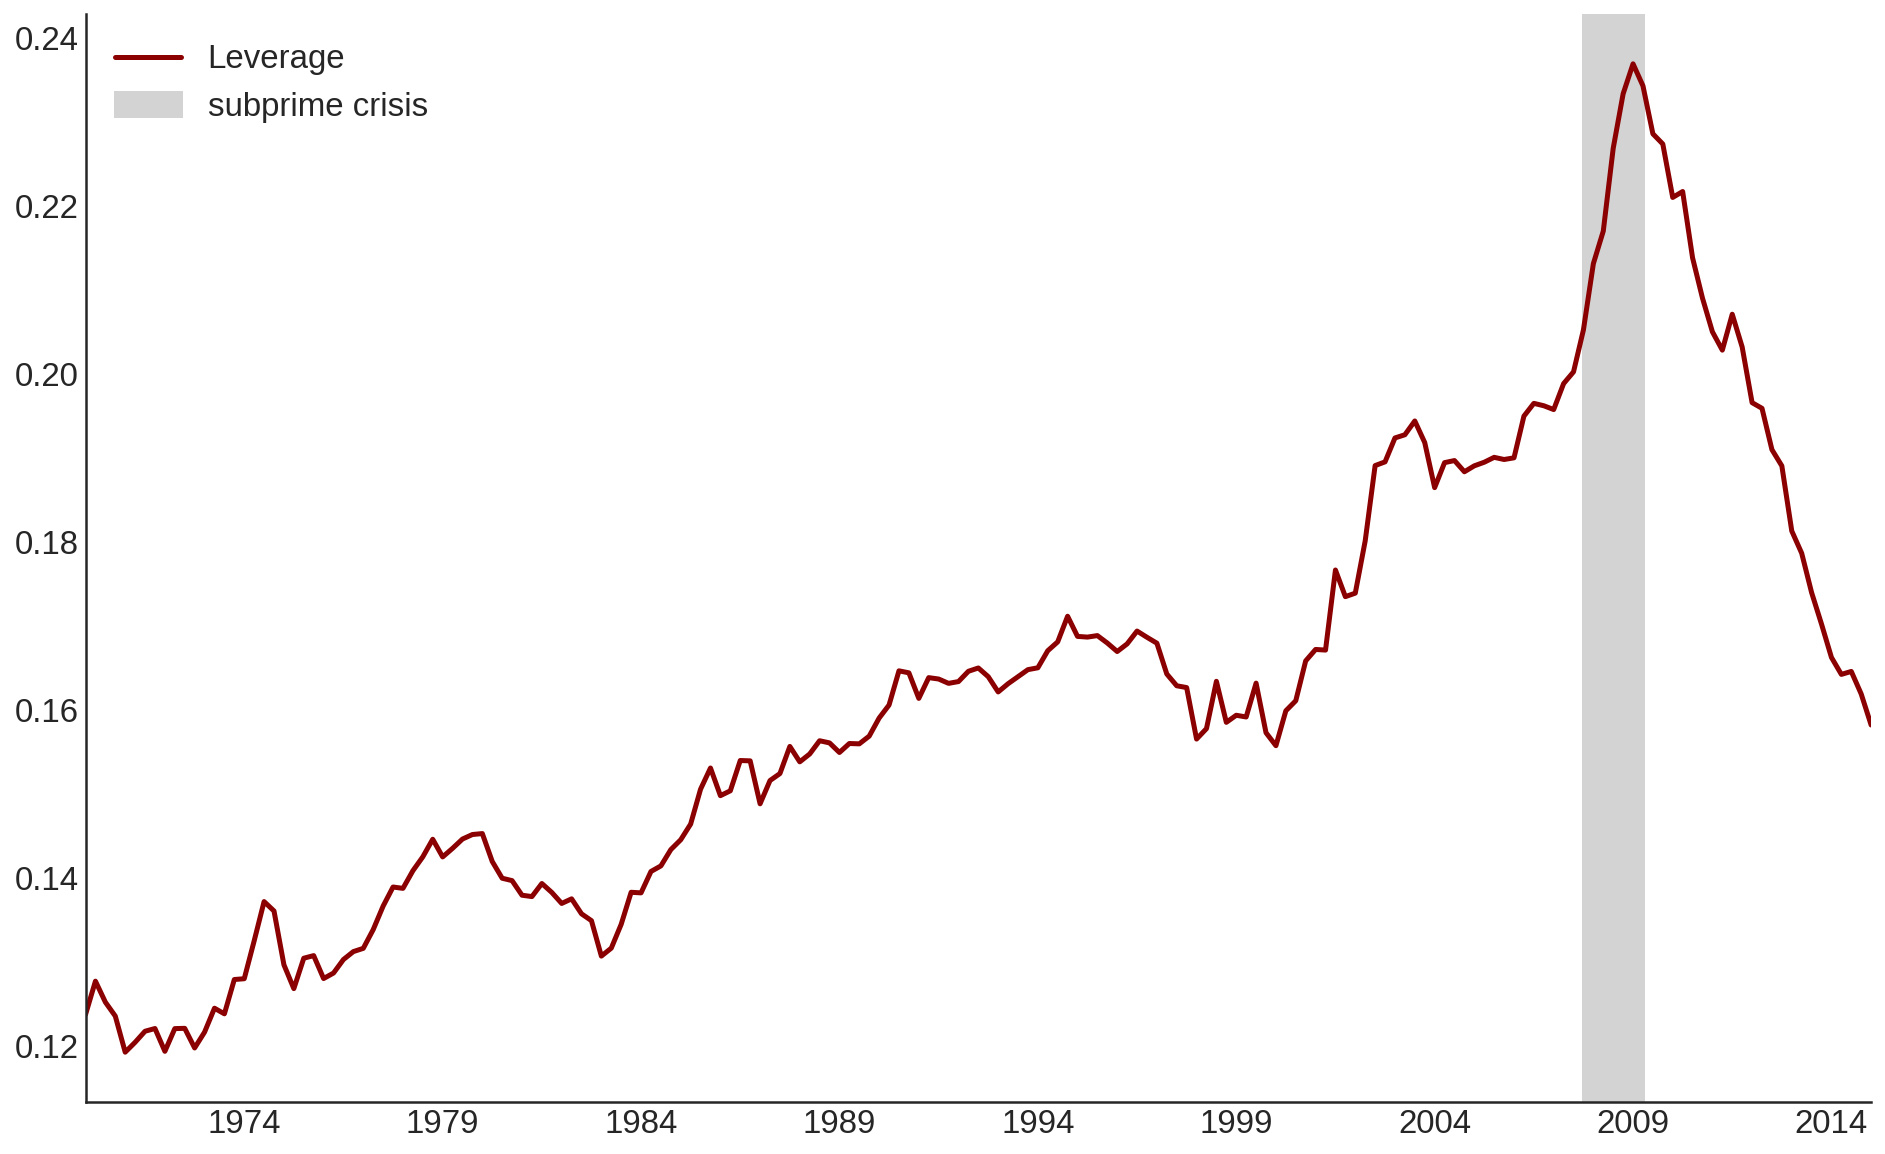

In [25]:
fig, ax = plt.subplots(figsize=(16, 10))

df[df.index>='1970-01'].plot(
    ax=ax,
    color=('darkred'),
    linewidth=2.5,
    label='Leverage'
)

ax.axvspan(
    xmin='2007-12-01', 
    xmax='2009-06-01',
    color='lightgray', 
    label='subprime crisis',
    zorder=0
)

ax.legend()
sns.despine()
plt.show()

## Household Consumption

In [26]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'DPCERE1Q156NBEA', # Shares of gross domestic product: Personal consumption expenditures
        'LABSHPUSA156NRUG', # Share of Labour Compensation in GDP at Current National Prices for United States
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Consumption',
    'Wages',
]
df['Wages'] = df['Wages']*100

df.index.name = ''
df = df.resample("A").mean().dropna()
df.head()

Consumption      Wages
                                  
1950-12-31        64.10  62.836289
1951-12-31        60.10  63.373178
1952-12-31        59.70  64.485157
1953-12-31        59.80  64.449602
1954-12-31        61.35  63.705200

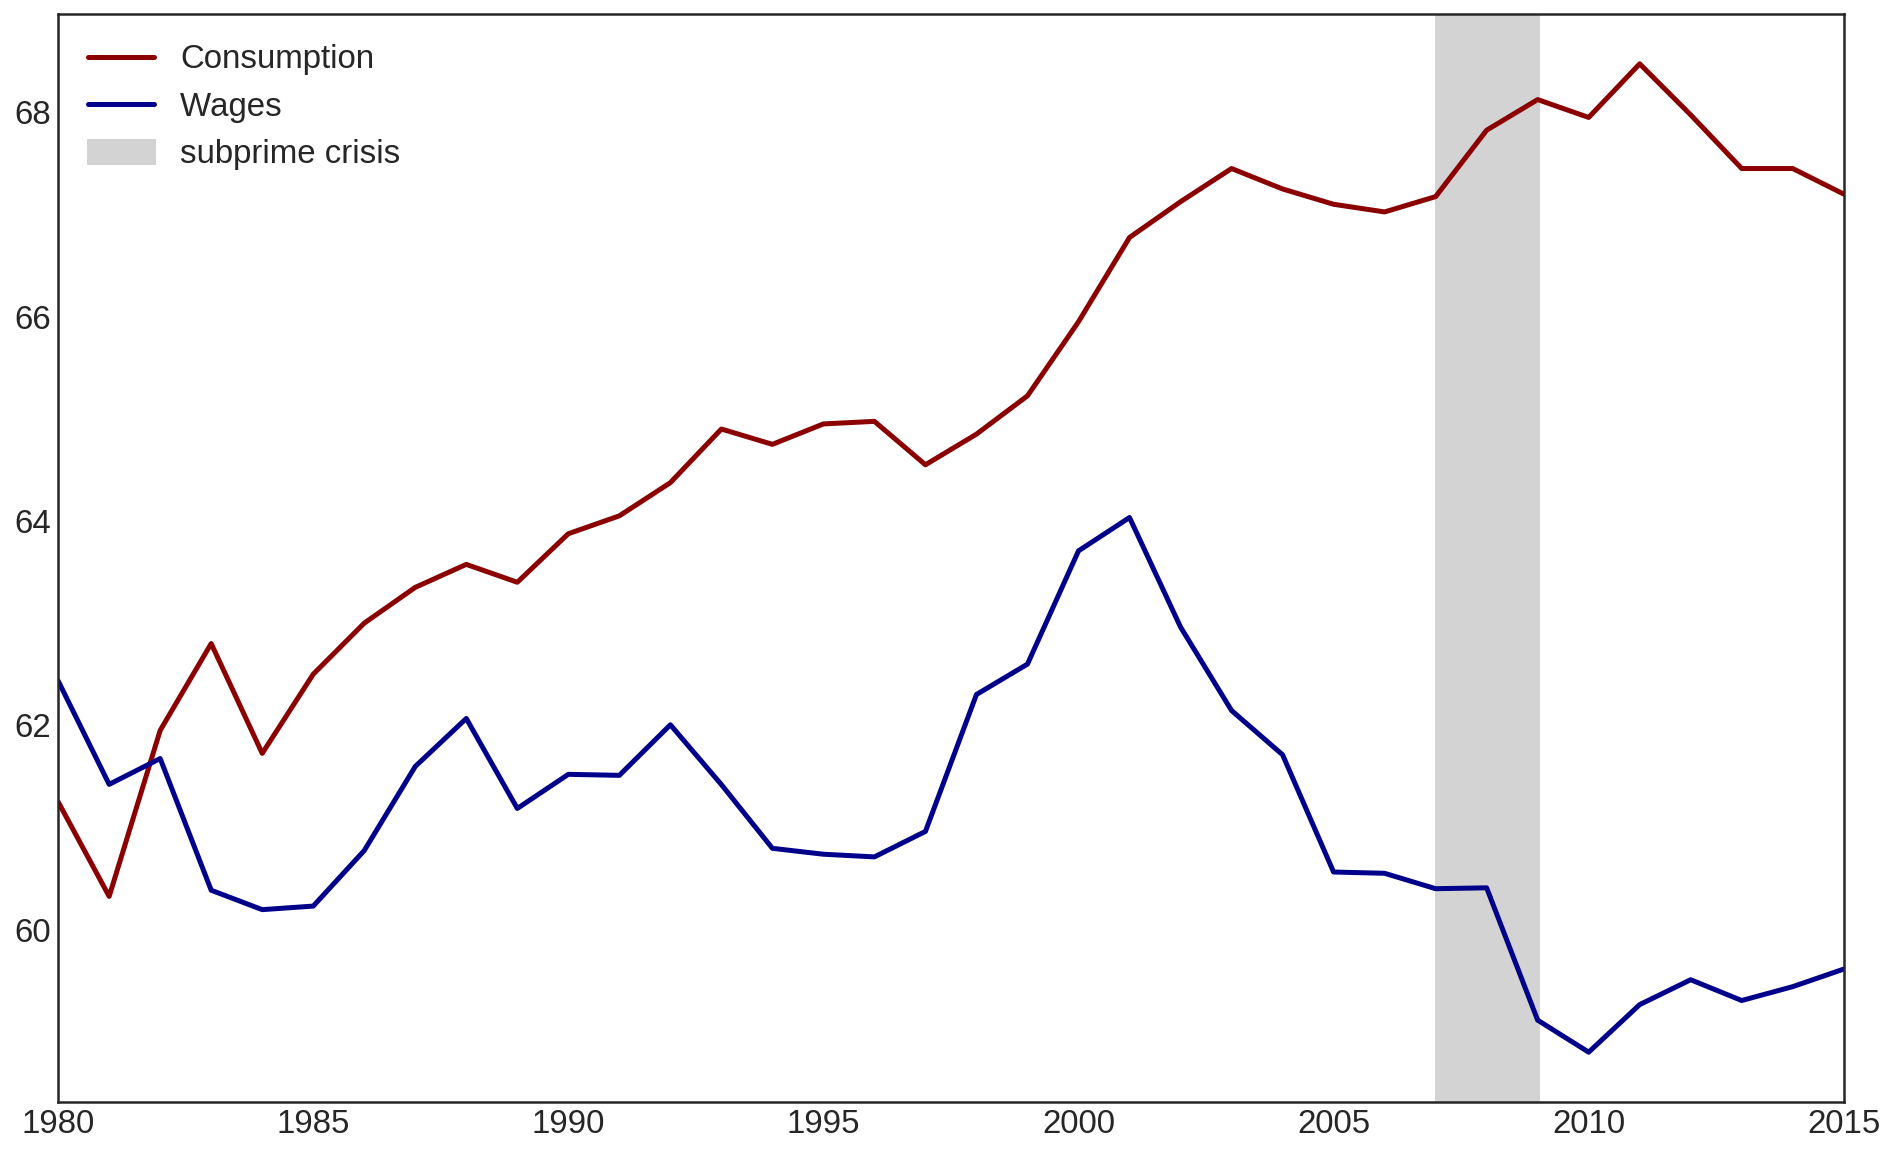

In [27]:
fig, ax = plt.subplots(figsize=(16, 10))

df.iloc[df.index>='1980-01',:].plot(
    ax=ax,
    color=('darkred', 'darkblue'),
    linewidth=2.5,
)

ax.axvspan(
    xmin='2007-12-01', 
    xmax='2009-06-01',
    color='lightgray', 
    label='subprime crisis',
    zorder=0
)
ax.legend()

plt.show()

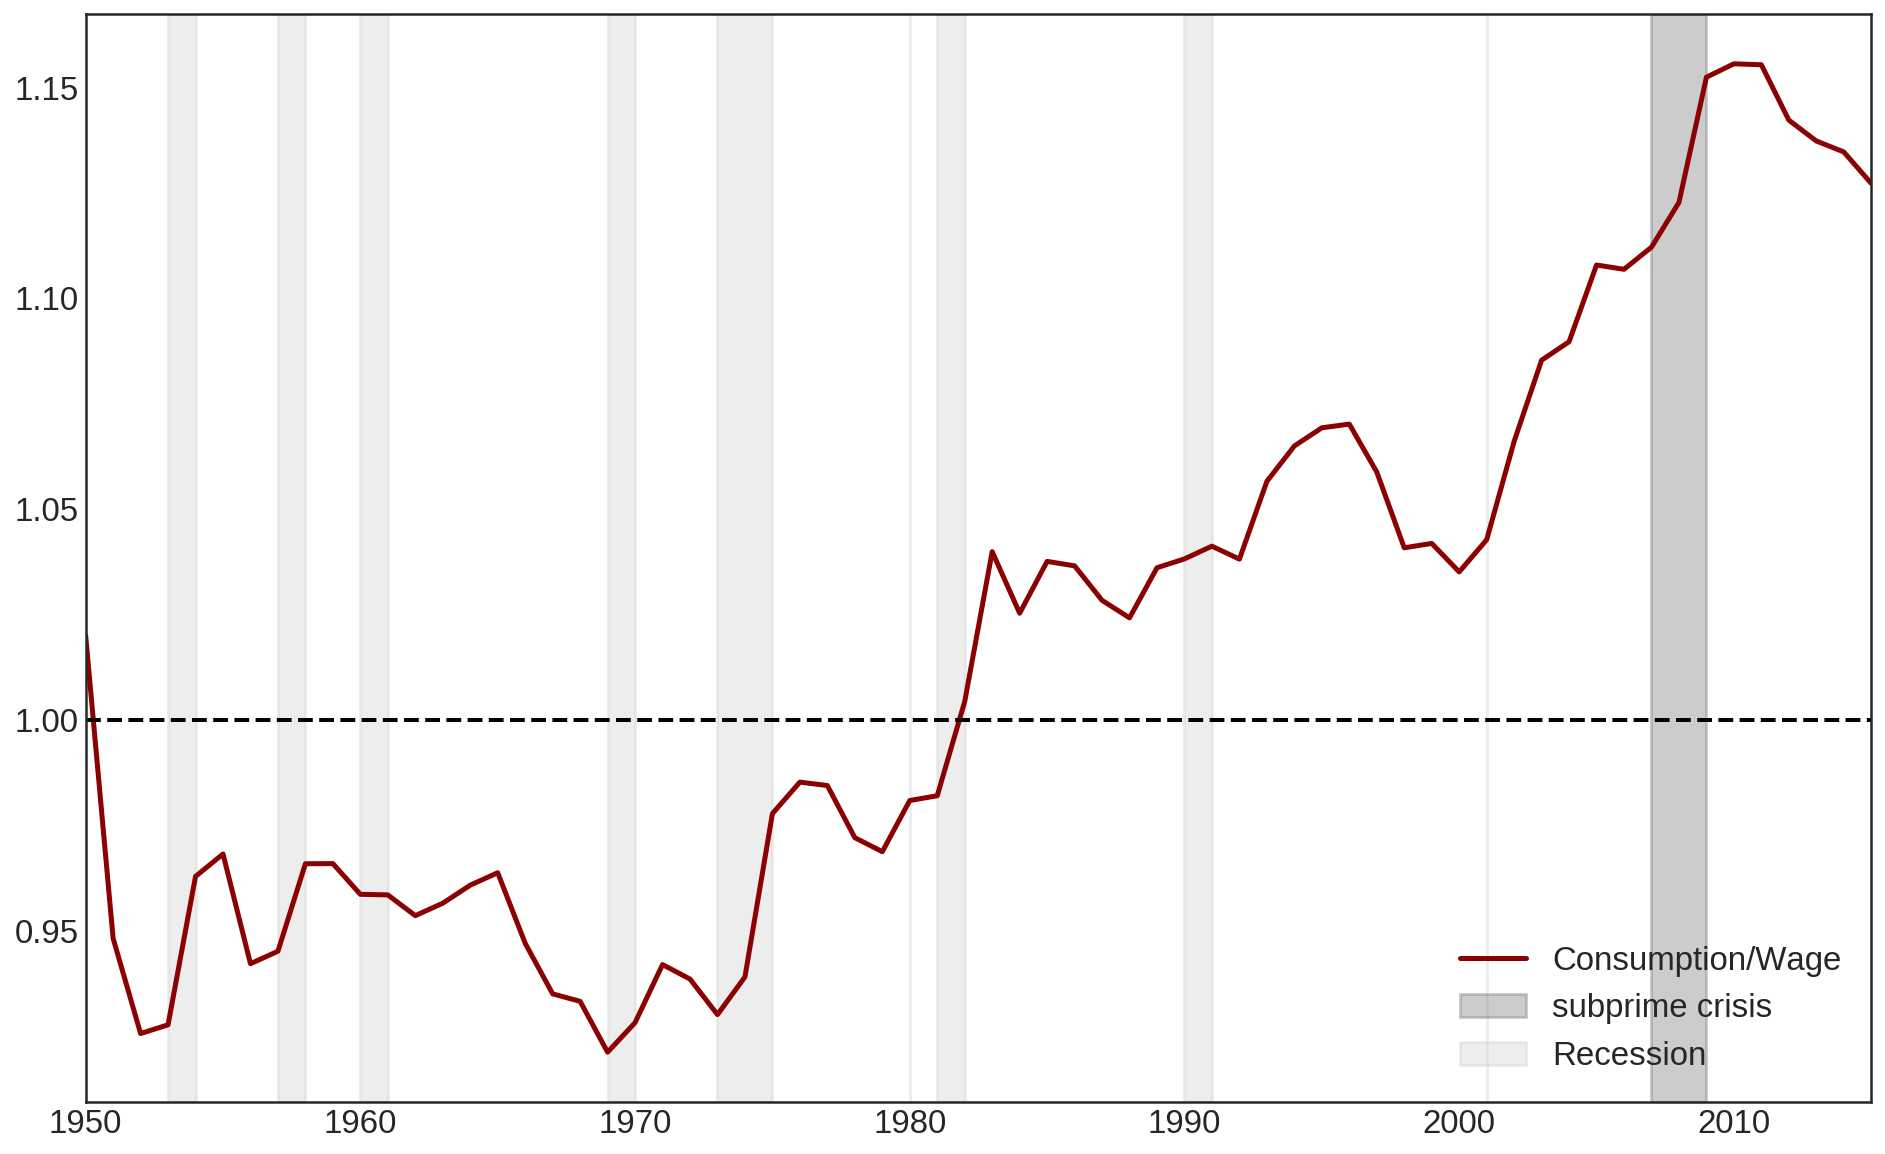

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [28]:
fig, ax = plt.subplots(figsize=(16, 10))

(df['Consumption']/df['Wages']).plot(
    ax=ax,
    color=('darkred'),
    linewidth=2.5,
    label='Consumption/Wage'
)

crise_subprime(ax)
crises(ax)
ax.axhline(y=1,ls='--', lw=2, color='black')
ax.legend()

plt.show()
salvar_grafico("Consumption_Salario")

# Concentration and Distribution

## Concentrarion curve

In [29]:
df = pd.read_excel(
    '../data/SCF_merged.xlsx', 
    sheet_name='Riqueza',
    index_col=[0]
)

imoveis = df.loc['Imóveis',:]
imoveis = imoveis.drop(['Percentil da riqueza'], axis='columns')
imoveis.index = [.249, .499, .749, .899, 1]
imoveis = imoveis/100

acoes = df.loc['Ações',:]
acoes = acoes.drop(['Percentil da riqueza'], axis='columns')
acoes.index = [.249, .499, .749, .899, 1]
acoes = acoes/100

secund = df.loc['Secundário',:]
secund = secund.drop(['Percentil da riqueza'], axis='columns')
secund.index = [.249, .499, .749, .899, 1]
secund = secund/100

# Suavizando curvas
def suavizacao(serie, n=1000, k=2):

    xnew = np.linspace(serie.min().min(), serie.max().max(), n) 
    suavizado = serie.apply(lambda x: make_interp_spline(x.index, x, k=k)(xnew))
    suavizado = suavizado[suavizado > 0].dropna()
    suavizado.index = suavizado.index/n
    return suavizado

imoveis = suavizacao(imoveis)
#acoes = suavizacao(acoes)
#secund = suavizacao(secund)


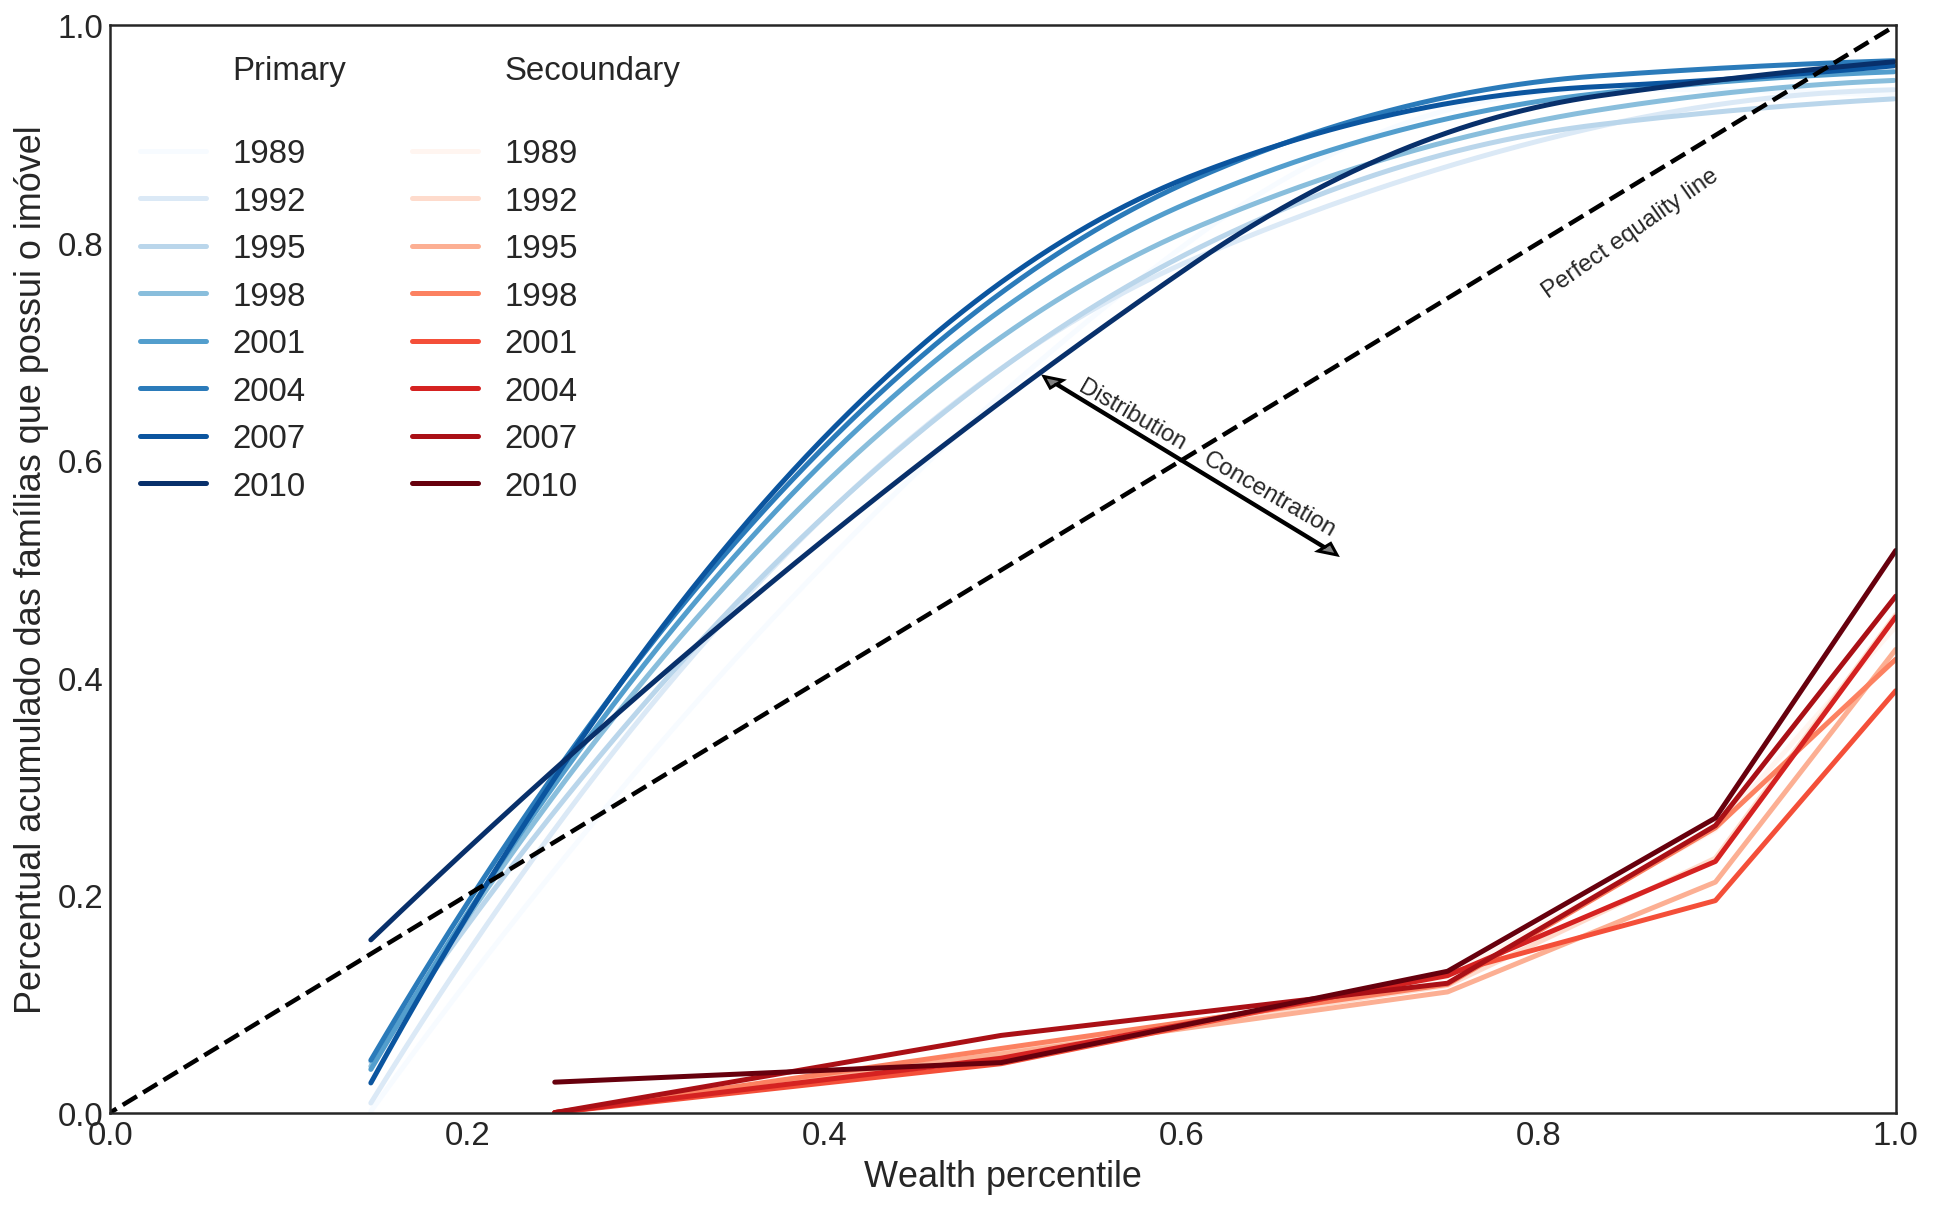

In [30]:
df1 = imoveis.loc[:, imoveis.columns <= 2010]
df2 = acoes.loc[:, acoes.columns <= 2010]
df3 = secund.loc[:, secund.columns <= 2010]

fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(
    np.linspace(0,0), 
    np.linspace(0,0),
    color='white',
    ls='-',
    label='Primary\n'
)

df1.plot(
    ax=ax,
    cmap="Blues", 
    linewidth=2.5,
)

ax.plot(
    np.linspace(0,0), 
    np.linspace(0,0),
    color='white',
    ls='-',
    label='Secoundary\n'
)

df3.plot(
    ax=ax,
    cmap="Reds", 
    linewidth=2.5,
)

ax.legend(ncol=2)

ax.plot(
    np.linspace(*ax.get_xlim()), 
    np.linspace(*ax.get_xlim()),
    color='black',
    ls='--',
)

ax.arrow(0.6, 0.6, +0.08, -0.08, head_width=0.01, head_length=0.01, fc='gray', ec='black')
ax.text(.61,.53, "Concentration", fontsize=12, rotation=-30)
ax.arrow(0.6, 0.6, -0.07, 0.07, head_width=0.01, head_length=0.01, fc='gray', ec='black')
ax.text(.54,.61, "Distribution", fontsize=12, rotation=-30)
ax.text(.8,.75, "Perfect equality line", fontsize=12, rotation=35)

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel('Wealth percentile')
ax.set_ylabel('Percentual acumulado das famílias que possui o imóvel')

plt.show()
salvar_grafico(file_name="Concentracao_Imoveis")

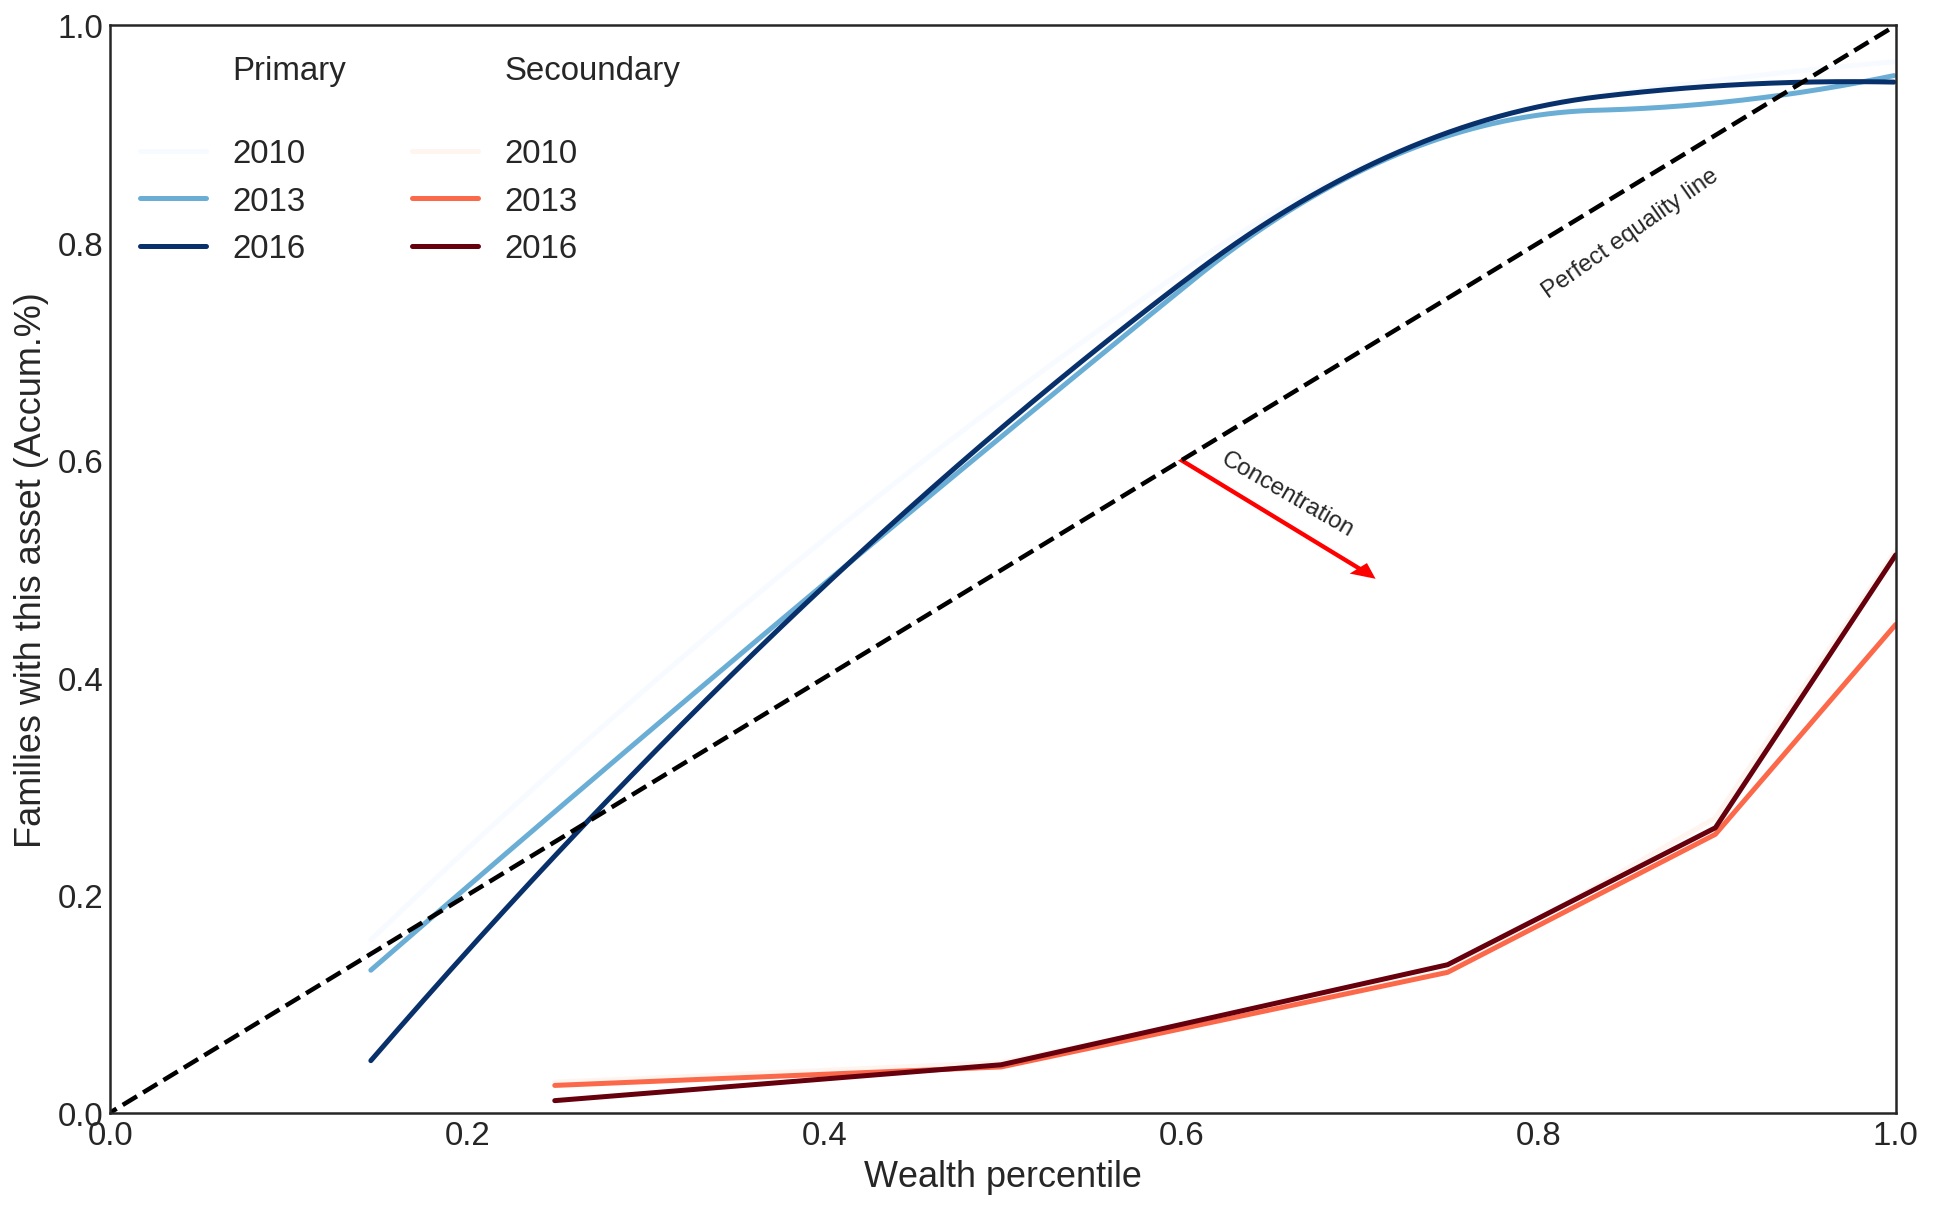

In [31]:
df1 = imoveis.loc[:, imoveis.columns > 2007]
df2 = acoes.loc[:, acoes.columns > 2007]
df3 = secund.loc[:, secund.columns > 2007]

fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(
    np.linspace(0,0), 
    np.linspace(0,0),
    color='white',
    ls='-',
    label='Primary\n'
)

df1.plot(
    ax=ax,
    cmap="Blues", 
    linewidth=2.5,
)

ax.plot(
    np.linspace(0,0), 
    np.linspace(0,0),
    color='white',
    ls='-',
    label='Secoundary\n'
)

df3.plot(
    ax=ax,
    cmap="Reds", 
    linewidth=2.5,
)

ax.legend(ncol=2)

ax.plot(
    np.linspace(*ax.get_xlim()), 
    np.linspace(*ax.get_xlim()),
    color='black',
    ls='--',
)

ax.arrow(0.6, 0.6, +0.1, -0.1, head_width=0.01, head_length=0.01, fc='red', ec='red')
ax.text(.62,.53, "Concentration", fontsize=12, rotation=-30)
ax.text(.8,.75, "Perfect equality line", fontsize=12, rotation=35)

ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_xlabel('Wealth percentile')
ax.set_ylabel('Families with this asset (Accum.%)')

plt.show()

In [32]:
df = pd.read_excel(
    '../data/SCF_merged.xlsx', 
    sheet_name='Porcentagem_Renda',
    index_col=[0]
)

imoveis = df.loc['Imóveis',:]
imoveis = imoveis.drop(['Percentil da renda'], axis='columns')
imoveis.index = [.2, .4, .6, .8, .9, .99]
imoveis = imoveis/100

total = df.loc['Total',:]
total = total.drop(['Percentil da renda'], axis='columns')
total.index = [.2, .4, .6, .8, .9, .99]
total = total/100

acoes = total - imoveis
acoes

1989   1992   1995   1998   2001   2004   2007   2010   2013   2016
0.20  0.061  0.068  0.068  0.053  0.019  0.071  0.121  0.088  0.102  0.074
0.40  0.070  0.049  0.045  0.035  0.037  0.062  0.035  0.041  0.029  0.038
0.60  0.088  0.077  0.052  0.070  0.040  0.035  0.064  0.039  0.030  0.041
0.80  0.075  0.073  0.053  0.086  0.070  0.045  0.055  0.037  0.049  0.054
0.90  0.068  0.095  0.056  0.094  0.096  0.052  0.097  0.047  0.061  0.071
0.99  0.179  0.203  0.200  0.236  0.202  0.181  0.246  0.177  0.200  0.203

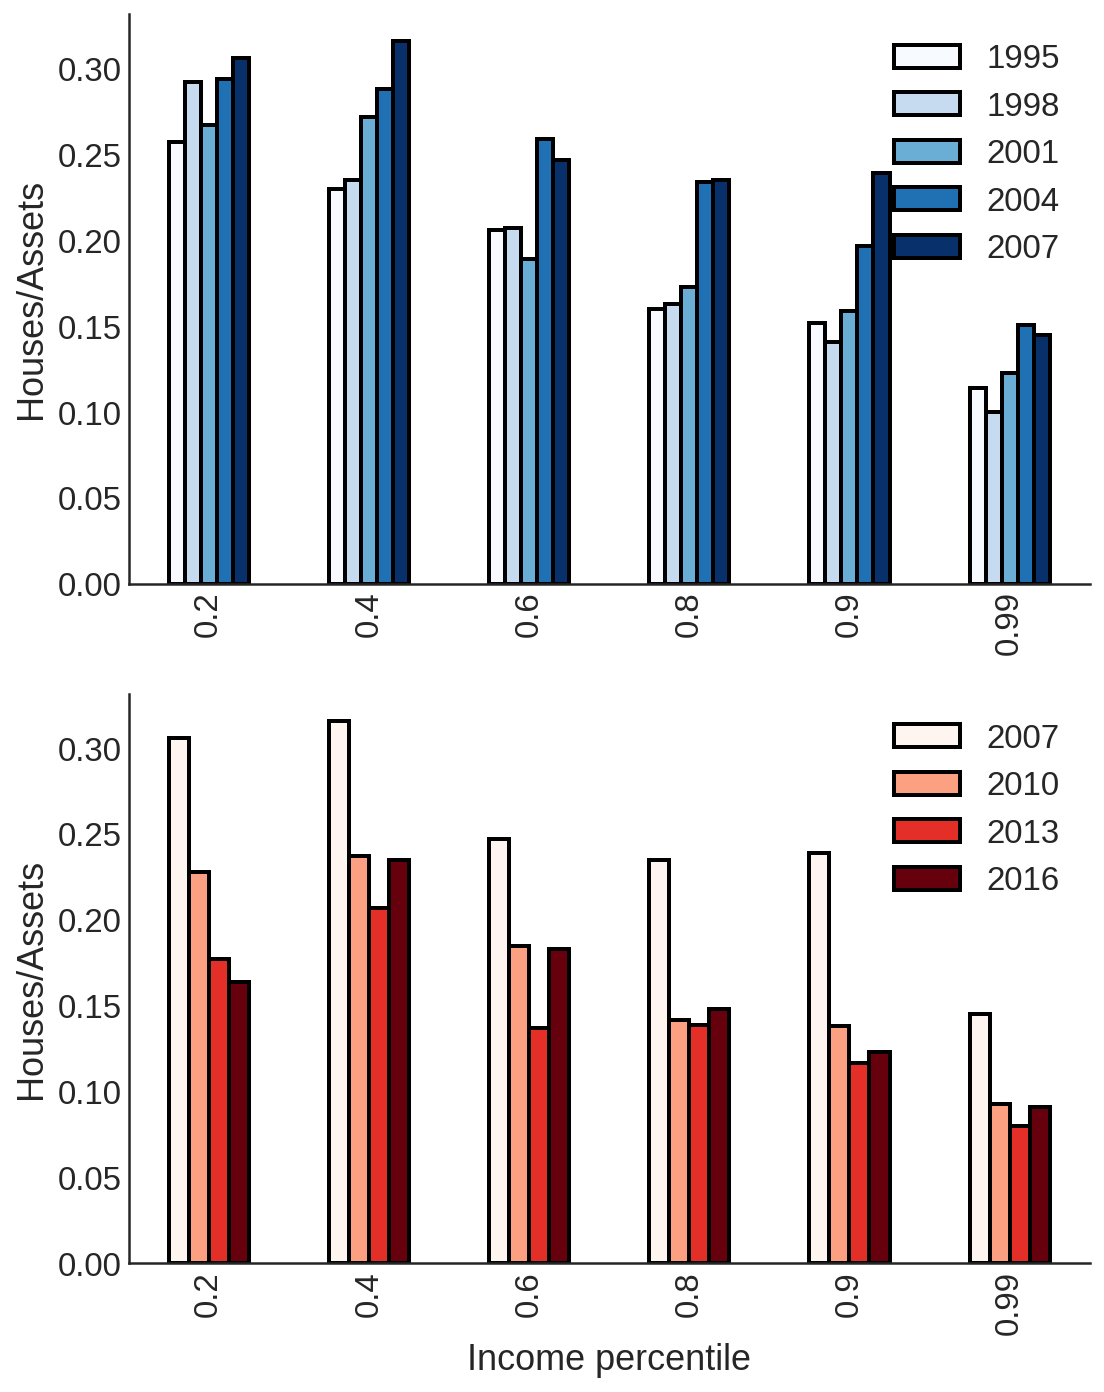

In [33]:
plt.style.use('seaborn-white')
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharey=True)

imoveis.loc[:, (imoveis.columns < 2010) & (imoveis.columns >= 1995)].plot(
    ax=ax[0],
    cmap="Blues", 
    linewidth=2,
    kind='bar',
    edgecolor='black'
)
ax[0].set_ylabel('Houses/Assets')

imoveis.loc[:, imoveis.columns >= 2007].plot(
    ax=ax[1],
    cmap="Reds", 
    linewidth=2,
    kind='bar',
    edgecolor='black'
)

ax[1].set_xlabel('Income percentile')
ax[1].set_ylabel('Houses/Assets')

sns.despine()
sns.set_context('talk')
plt.tight_layout()
plt.show()
salvar_grafico("Imoveis_Percentis")

In [34]:
def concentracao_df(df):
    colunas = ['Top 1%', 'Top 10%', 'Top 50-90%', 'Bottom 50%']
    df.columns = colunas
    df = df/100
    df.index.name = ''
    df = df/df.iloc[0,:]
    return df

## Assets

In [35]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

Assets = web.DataReader(
    [
        ######## Total Assets ##########
        'WFRBST01108', # Share of Total Assets Held by the Top 1% (99th to 100th Wealth Percentiles)
        'WFRBSN09135', # Share of Total Assets Held by the 90th to 99th Wealth Percentiles
        'WFRBSN40162', # Share of Total Assets Held by the 50th to 90th Wealth Percentiles
        'WFRBSB50189', # Share of Total Assets Held by the Bottom 50% (1st to 50th Wealth Percentiles)
    ], 
    'fred', 
    start, 
    end
)
Assets = concentracao_df(Assets)

financeiros = web.DataReader(
    [
        'WFRBST01112', # Share of Financial Assets Held by the Top 1% (99th to 100th Wealth Percentiles)
        'WFRBSN09139', # Share of Financial Assets Held by the 90th to 99th Wealth Percentiles
        'WFRBSN40166', # Share of Financial Assets Held by the 50th to 90th Wealth Percentiles
        'WFRBSB50193', # Share of Financial Assets Held by the Bottom 50% (1st to 50th Wealth Percentiles)
    ], 
    'fred', 
    start, 
    end
)
financeiros = concentracao_df(financeiros)

imoveis = web.DataReader(
    [
        'WFRBST01110', # Share of Real Estate Held by the Top 1% (99th to 100th Wealth Percentiles)
        'WFRBSN09137', # Share of Real Estate Held by the 90th to 99th Wealth Percentiles
        'WFRBSN40164', # Share of Real Estate Held by the 50th to 90th Wealth Percentiles
        'WFRBSB50191', # Share of Real Estate Held by the Bottom 50% (1st to 50th Wealth Percentiles)
    ], 
    'fred', 
    start, 
    end
)
imoveis = concentracao_df(imoveis)

duraveis = web.DataReader(
    [
        'WFRBST01111', # Share of Consumer Durables Held by the Top 1% (99th to 100th Wealth Percentiles)
        'WFRBSN09138', # Share of Consumer Durables Held by the 90th to 99th Wealth Percentiles
        'WFRBSN40165', # Share of Consumer Durables Held by the 50th to 90th Wealth Percentiles
        'WFRBSB50192', # Share of Consumer Durables Held by the Bottom 50% (1st to 50th Wealth Percentiles)
    ], 
    'fred', 
    start, 
    end
)
duraveis = concentracao_df(duraveis)

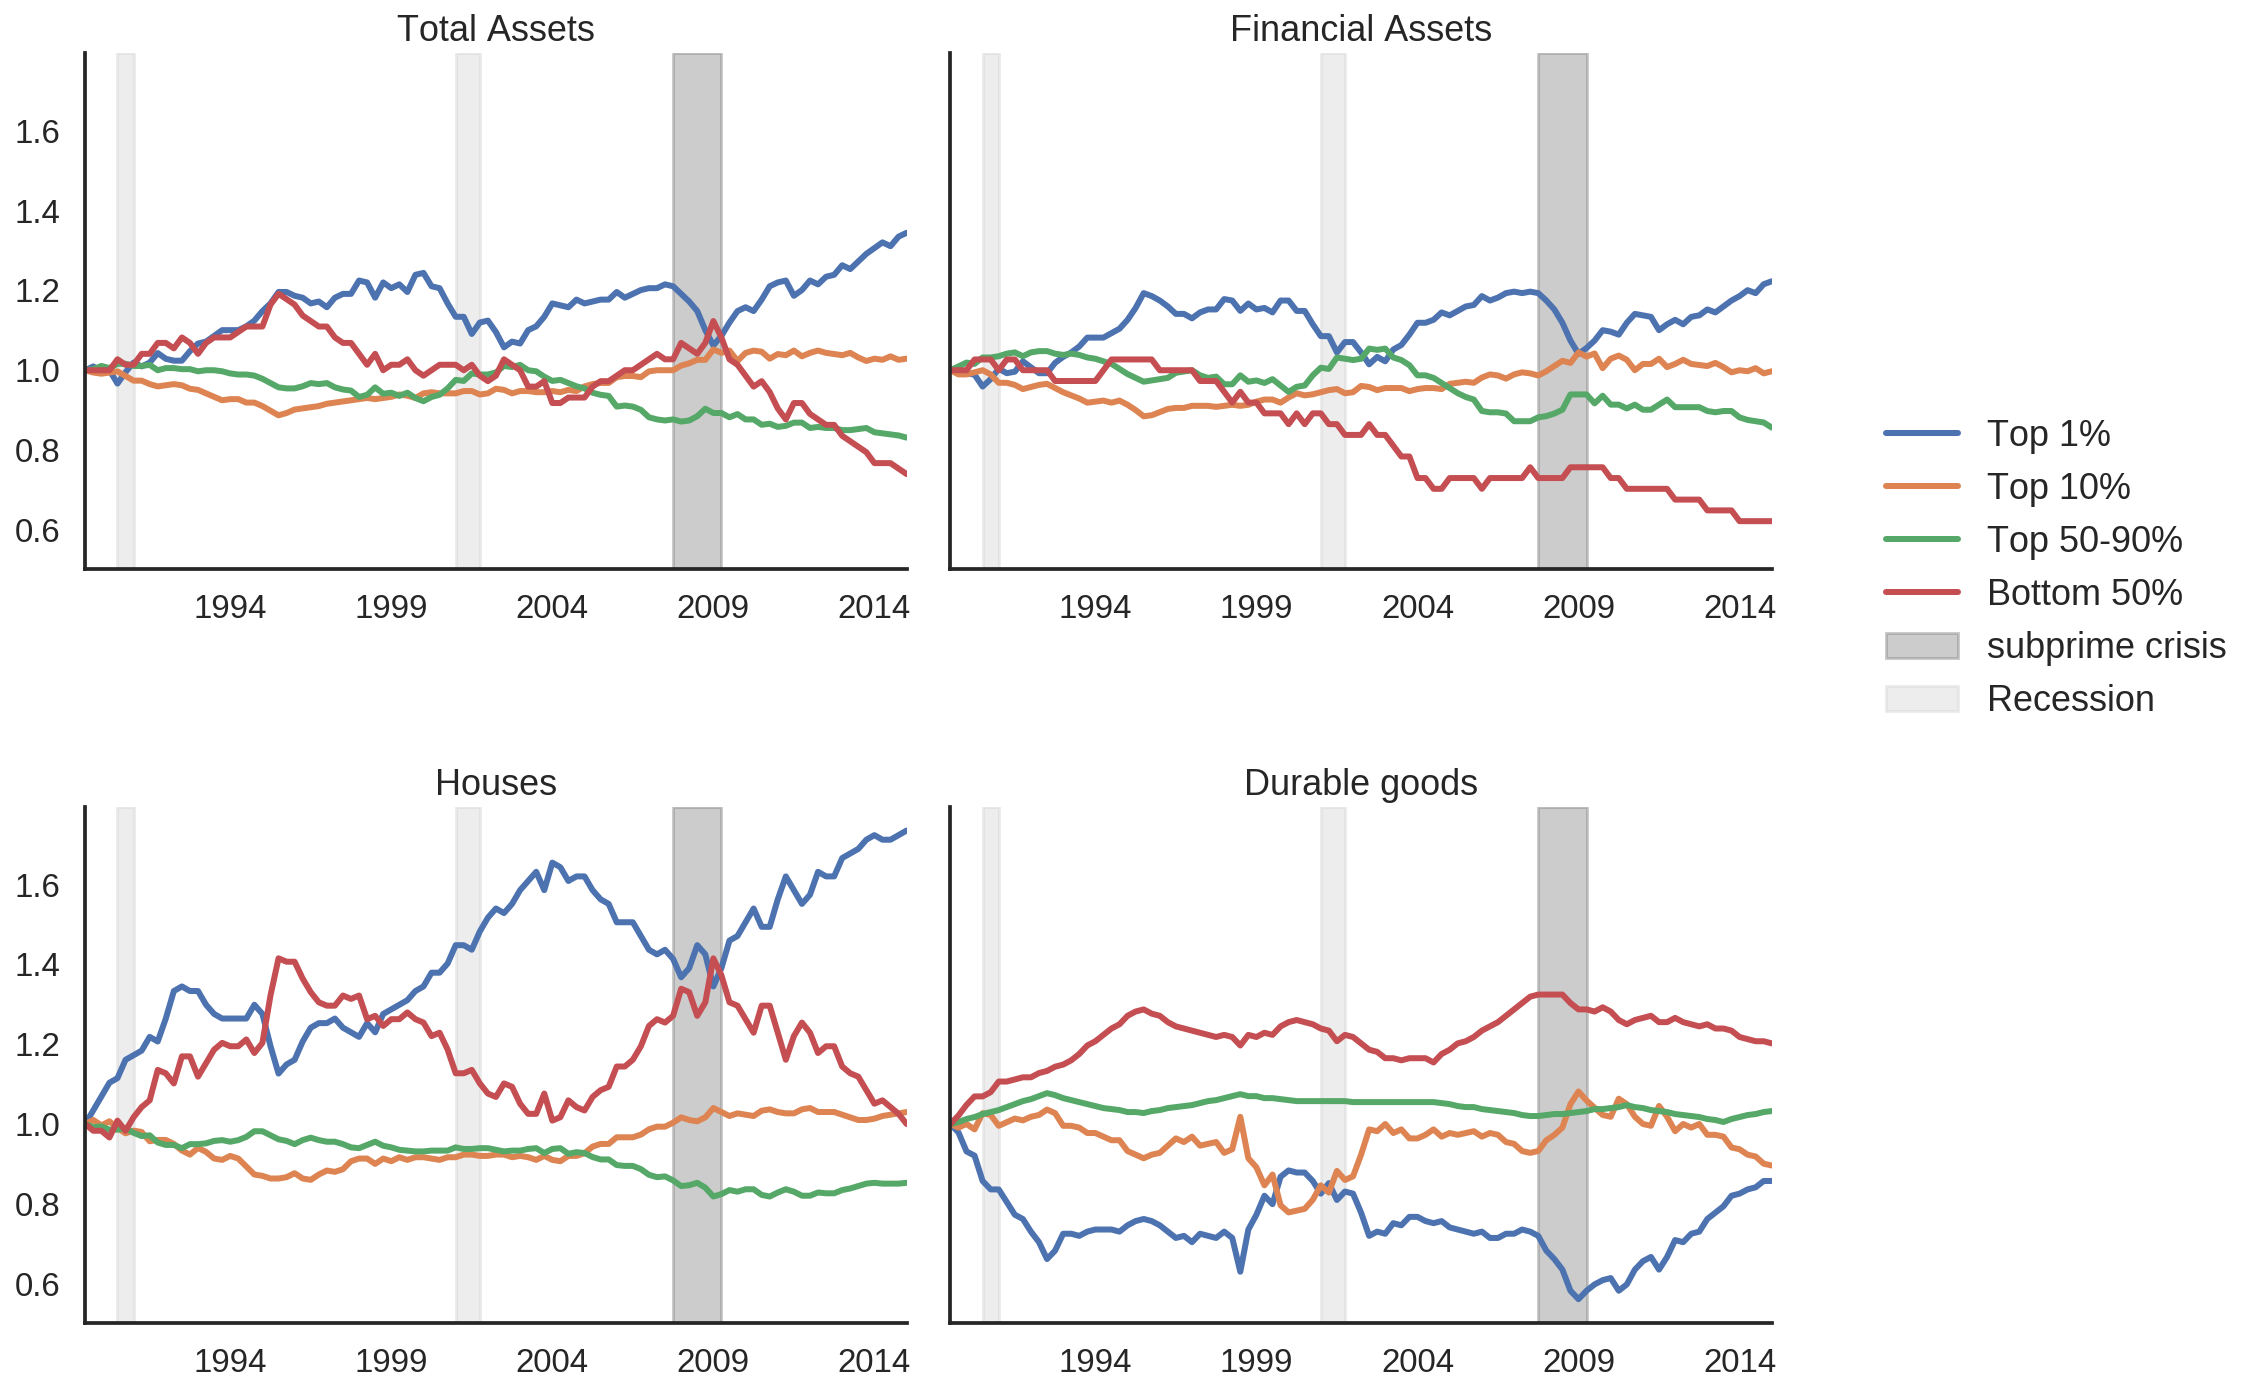

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [36]:
plt.style.use('seaborn-white')
sns.set_context('talk')
fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

Assets.plot(title='Total Assets', ax=ax[0,0], legend=False, lw=3)
financeiros.plot(title='Financial Assets', ax=ax[0,1], legend=False, lw=3)
imoveis.plot(title='Houses', ax=ax[1,0], legend=False, lw=3)
duraveis.plot(title='Durable goods', ax=ax[1,1], legend=False, lw=3)

crise_subprime(axes=ax[0,1])
crises(axes=ax[0,1])
ax[0,1].legend(loc='center left', bbox_to_anchor=(1.1, 0.), fontsize=18)

crise_subprime(axes=ax[0,0])
crise_subprime(axes=ax[1,0])
crise_subprime(axes=ax[1,1])
crises(axes=ax[0,0])
crises(axes=ax[1,0])
crises(axes=ax[1,1])

sns.despine()
plt.tight_layout()
plt.show()
salvar_grafico(file_name="Distribuicao_Assets")

## Passivos

In [37]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)
url = 'https://fred.stlouisfed.org/release/tables?rid=453&eid=813804#snid=813936'

passivos = web.DataReader(
    [
        'WFRBST01127', # Share of Total Liabilities Held by the Top 1% (99th to 100th Wealth Percentiles)
        'WFRBSN09154', # Share of Total Liabilities Held by the 90th to 99th Wealth Percentiles
        'WFRBSN40181', # Share of Total Liabilities Held by the 50th to 90th Wealth Percentiles
        'WFRBSB50208', # Share of Total Liabilities Held by the Bottom 50% (1st to 50th Wealth Percentiles)
    ], 
    'fred', 
    start, 
    end
)
passivos = concentracao_df(passivos)

emprestimo = web.DataReader(
    [
        'WFRBST01128', # Share of Loans (Liabilities) Held by the Top 1% (99th to 100th Wealth Percentiles)
        'WFRBSN09155', # Share of Loans (Liabilities) Held by the 90th to 99th Wealth Percentiles
        'WFRBSN40182', # Share of Loans (Liabilities) Held by the 50th to 90th Wealth Percentiles
        'WFRBSB50209', # Share of Loans (Liabilities) Held by the Bottom 50% (1st to 50th Wealth Percentiles)
    ], 
    'fred', 
    start, 
    end
)
emprestimo = concentracao_df(emprestimo)

Mortgages = web.DataReader(
    [
        'WFRBST01129', # Share of Home mortgages Held by the Top 1% (99th to 100th Wealth Percentiles)
        'WFRBSN09156', # Share of Home mortgages Held by the 90th to 99th Wealth Percentiles
        'WFRBSN40183', # Share of Home mortgages Held by the 50th to 90th Wealth Percentiles
        'WFRBSB50210', # Share of Home mortgages Held by the Bottom 50% (1st to 50th Wealth Percentiles)
    ], 
    'fred', 
    start, 
    end
)
Mortgages = concentracao_df(Mortgages)

patrimonio_liq = web.DataReader(
    [
        'WFRBST01134', # Share of Total Net Worth Held by the Top 1% (99th to 100th Wealth Percentiles)
        'WFRBSN09161', # Share of Total Net Worth Held by the 90th to 99th Wealth Percentiles
        'WFRBSN40188', # Share of Total Net Worth Held by the 50th to 90th Wealth Percentiles
        'WFRBSB50215', # Share of Total Net Worth Held by the Bottom 50% (1st to 50th Wealth Percentiles)
    ], 
    'fred', 
    start, 
    end
)
patrimonio_liq = concentracao_df(patrimonio_liq)

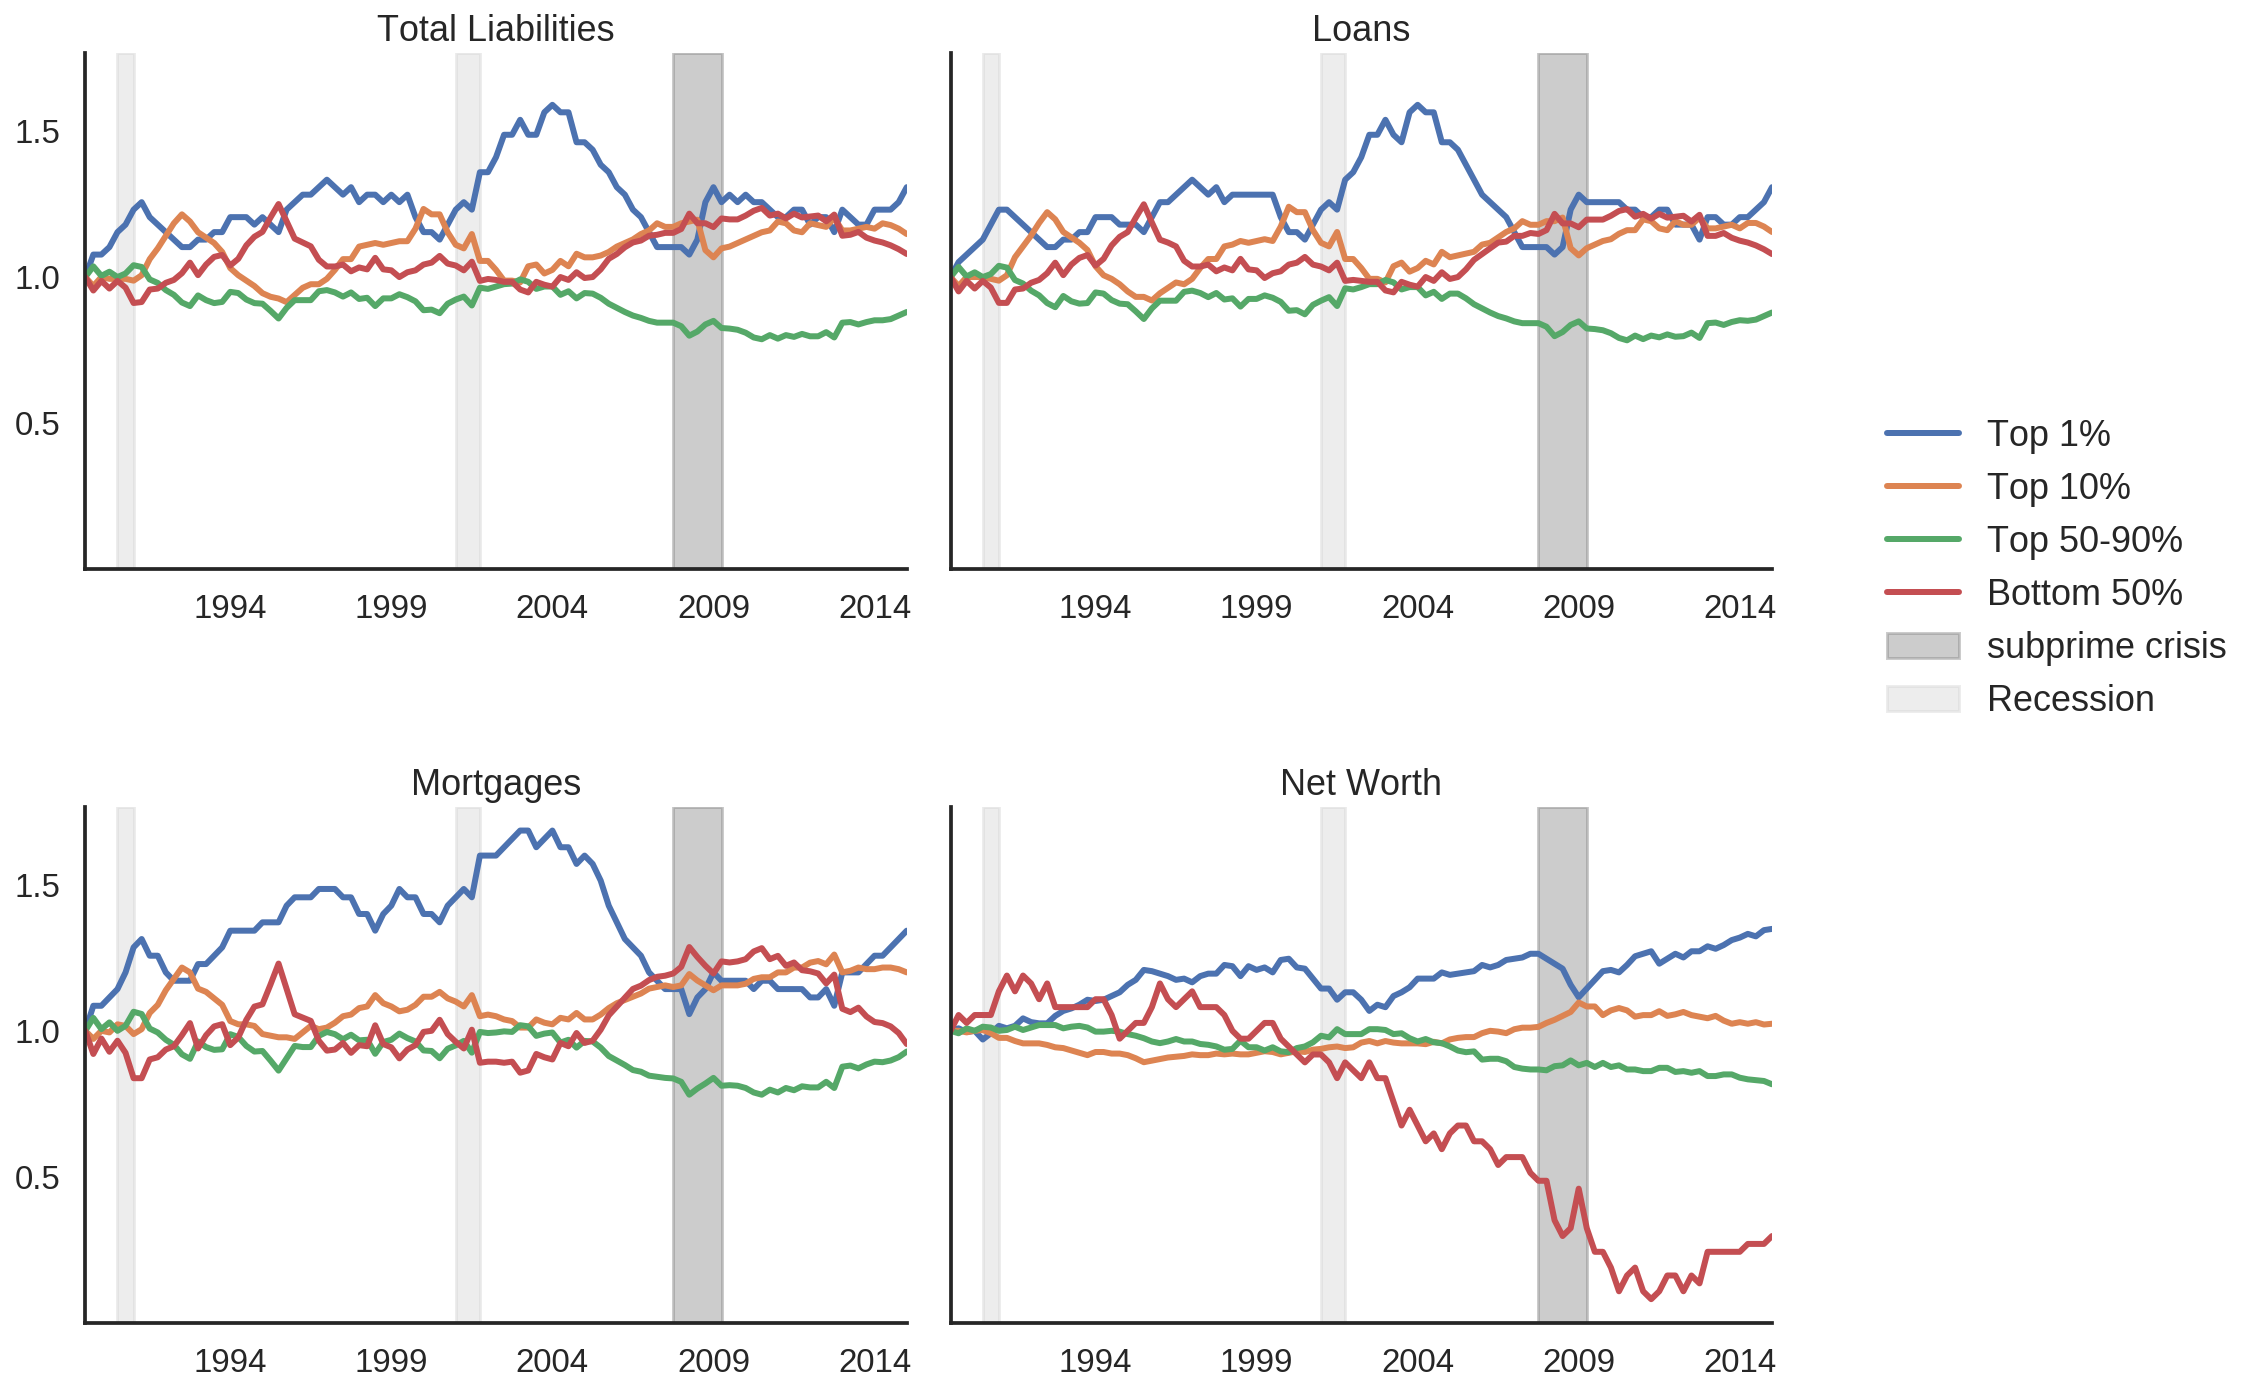

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [38]:
plt.style.use('seaborn-white')
sns.set_context('talk')
fig, ax = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

passivos.plot(title='Total Liabilities', ax=ax[0,0], legend=False, lw=3)
emprestimo.plot(title='Loans', ax=ax[0,1], legend=False, lw=3)
Mortgages.plot(title='Mortgages', ax=ax[1,0], legend=False, lw=3)
patrimonio_liq.plot(title='Net Worth', ax=ax[1,1], legend=False, lw=3)

crise_subprime(axes=ax[0,1])
crises(axes=ax[0,1])
ax[0,1].legend(loc='center left', bbox_to_anchor=(1.1, 0.), fontsize=18)

crise_subprime(axes=ax[0,0])
crise_subprime(axes=ax[1,0])
crise_subprime(axes=ax[1,1])
crises(axes=ax[0,0])
crises(axes=ax[1,0])
crises(axes=ax[1,1])

sns.despine()
plt.tight_layout()
plt.show()
salvar_grafico(file_name="Distribuicao_Passivos")

# Residential investment e Non-Residential

## Volatilidade

In [39]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'PRFI', # Domestic business
        'PNFI', # Households and institutions
        'GDP', # Gross Domestic Product
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Residential',
    'Non-Residential',
    'GDP'
]
df.index.name = ''
df = df.pct_change(4).dropna()
df = df.dropna()

df["Great Recession"] = ["Pre Crisis" if i < dt(2009, 1, 1) else "Post Crisis" for i in df.index]
df["Great Recession"] = df["Great Recession"].astype('category')
df = pd.melt(df, value_vars=['Residential', 'Non-Residential', "GDP"], id_vars='Great Recession')

df.head()

Great Recession     variable     value
0      Pre Crisis  Residential  0.455744
1      Pre Crisis  Residential  0.553674
2      Pre Crisis  Residential  0.306193
3      Pre Crisis  Residential -0.005048
4      Pre Crisis  Residential -0.076637

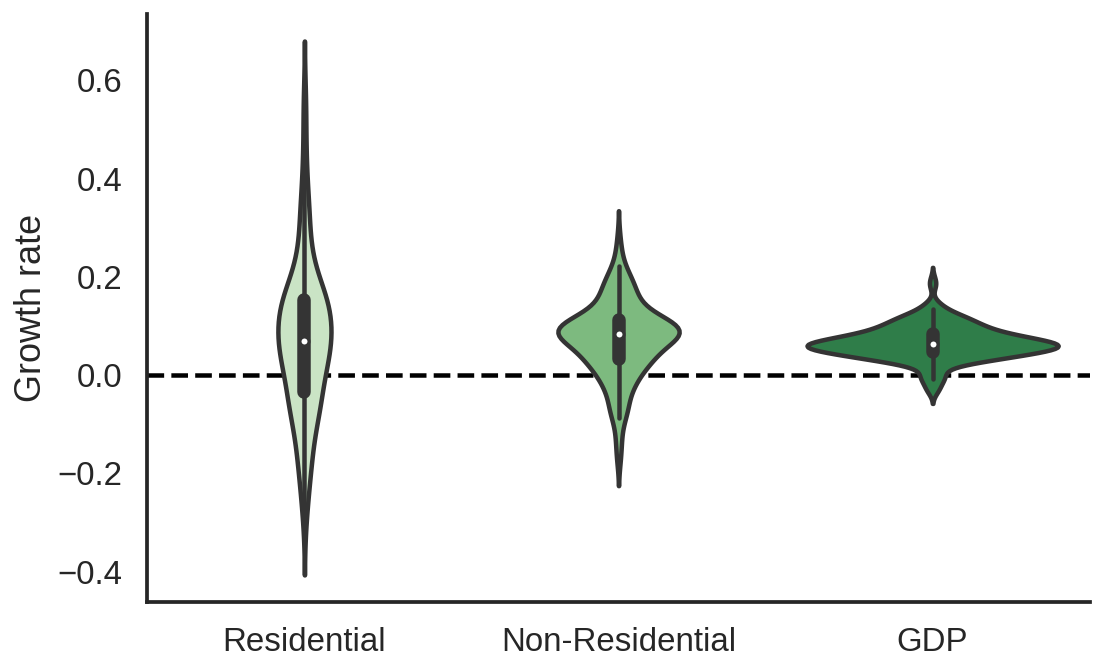

In [40]:
sns.set_context('talk')
fig, ax = plt.subplots(1,1, figsize=(8,5))

sns.violinplot( 
    x= "variable",
    y= "value",
    #hue="Great Recession",
    palette='Greens',
    ax = ax,
    lw=2,
    data=df,
    split=True, 
    scale='area'
)


ax.axhline(y=0,ls='--', color='black', zorder=0)
ax.set_xlabel('')
ax.set_ylabel('Growth rate')

sns.despine()
plt.tight_layout()
plt.show()
salvar_grafico(file_name="Volatilidade")

## House prices

In [41]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'B944RG3Q086SBEA', # Single family (chain-type price index)
        'B292RG3Q086SBEA', # Multifamily (chain-type price index)
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Unifamiliar',
    'Multifamiliar',
]
df.index.name = ''

df.head()

Unifamiliar  Multifamiliar
                                      
1958-01-01       12.081         10.160
1958-04-01       12.081         10.160
1958-07-01       12.082         10.162
1958-10-01       12.082         10.161
1959-01-01       12.081         10.162

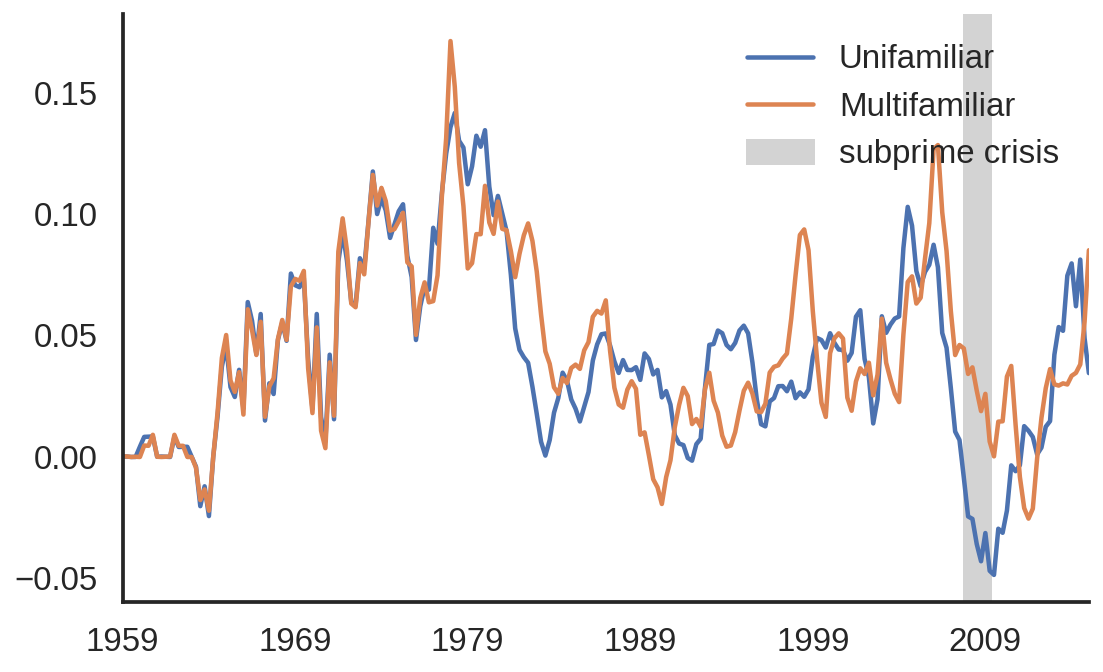

In [42]:
fig, ax = plt.subplots(figsize=(8,5))

df.pct_change(4).dropna().plot(ax=ax)

ax.axvspan(
    xmin='2007-12-01', 
    xmax='2009-06-01',
    color='lightgray', 
    label='subprime crisis'
)

ax.legend()


sns.despine()
sns.set_context('talk')
plt.tight_layout()
plt.show()

## Residential investment

In [43]:
start = dt(1947, 1, 1)
end = dt(2015, 1, 1)

df = web.DataReader(
    [
        'PRFI', # Private Residential Fixed Investment
        'GNP', # Gross National Product
        'PCEC', # Personal Consumption Expenditures
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Residential investment',
    'PNB',
    'Consumption'
]
df.index.name = ''

df['Ih/Renda'] = (df['Residential investment']/df['PNB'])*100
df['Ih/Consumption'] = (df['Residential investment']/df['Consumption'])*100
df['Ih/Consumption'] = df['Ih/Consumption']/(df['Ih/Consumption']["2000-01-01"])

cycle, trend = sm.tsa.filters.hpfilter(df['Ih/Consumption'], 1600)
df["Tendência"] = trend
df["Ciclo"] = cycle
df.head()

Residential investment      PNB  Consumption  Ih/Renda  \
                                                                     
1947-01-01                  10.541  244.142      156.161  4.317569   
1947-04-01                  10.573  247.063      160.031  4.279475   
1947-07-01                  12.466  250.716      163.543  4.972160   
1947-10-01                  15.254  260.981      167.672  5.844870   
1948-01-01                  15.345  267.133      170.372  5.744330   

            Ih/Consumption  Tendência     Ciclo  
                                                 
1947-01-01        0.921900   1.077204 -0.155304  
1947-04-01        0.902336   1.094870 -0.192534  
1947-07-01        1.041045   1.112440 -0.071395  
1947-10-01        1.242503   1.129695  0.112808  
1948-01-01        1.230107   1.146373  0.083734

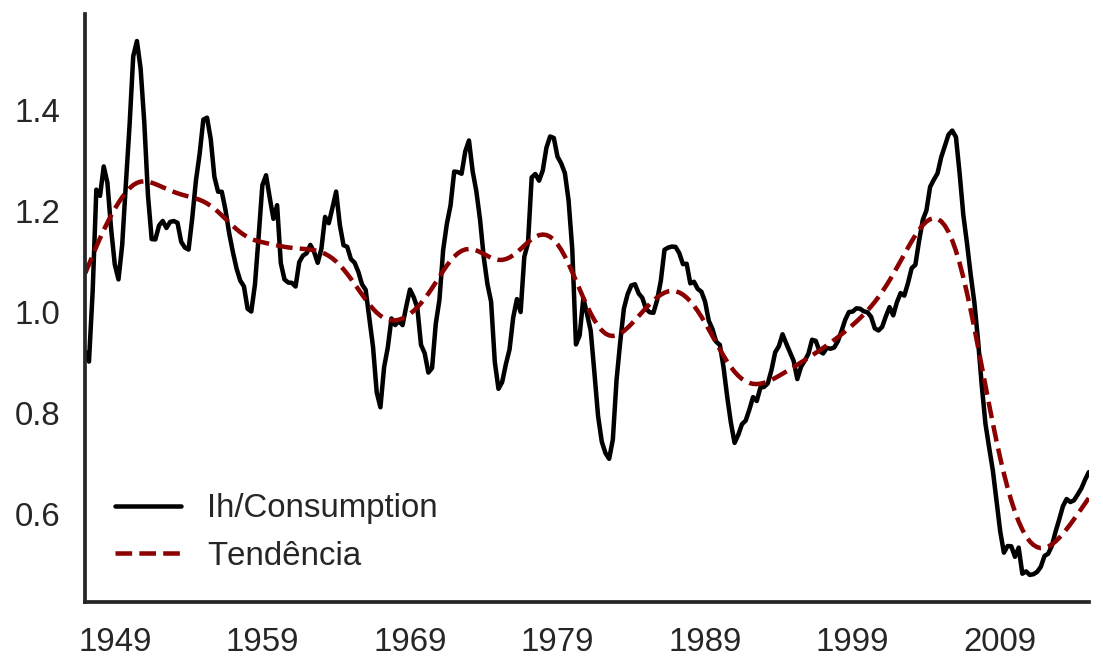

In [44]:
fig, ax = plt.subplots(figsize=(8,5))

df[['Ih/Consumption']].plot(
    ax=ax,
    color=('black'),
    ls='-'
)

df[['Tendência']].plot(
    ax=ax,
    color=('darkred'),
    ls='--'
)


ax.legend()


sns.despine()
sns.set_context('talk')
plt.tight_layout()
plt.show()

In [45]:
start = dt(1947, 1, 1)
end = dt(2019, 1, 1)

df = web.DataReader(
    [
        'PRFI', # 
        'PBRESCONS', # Total Public Construction Spending: Residential 
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Privado',
    'Público',
]
df.index.name = ''
df['Público'] = df['Público']/1000

df=df.dropna()
df.head()

Privado  Público
                            
2002-01-01  538.339    5.348
2002-04-01  554.846    5.266
2002-07-01  558.880    5.539
2002-10-01  578.313    5.014
2003-01-01  601.444    5.261

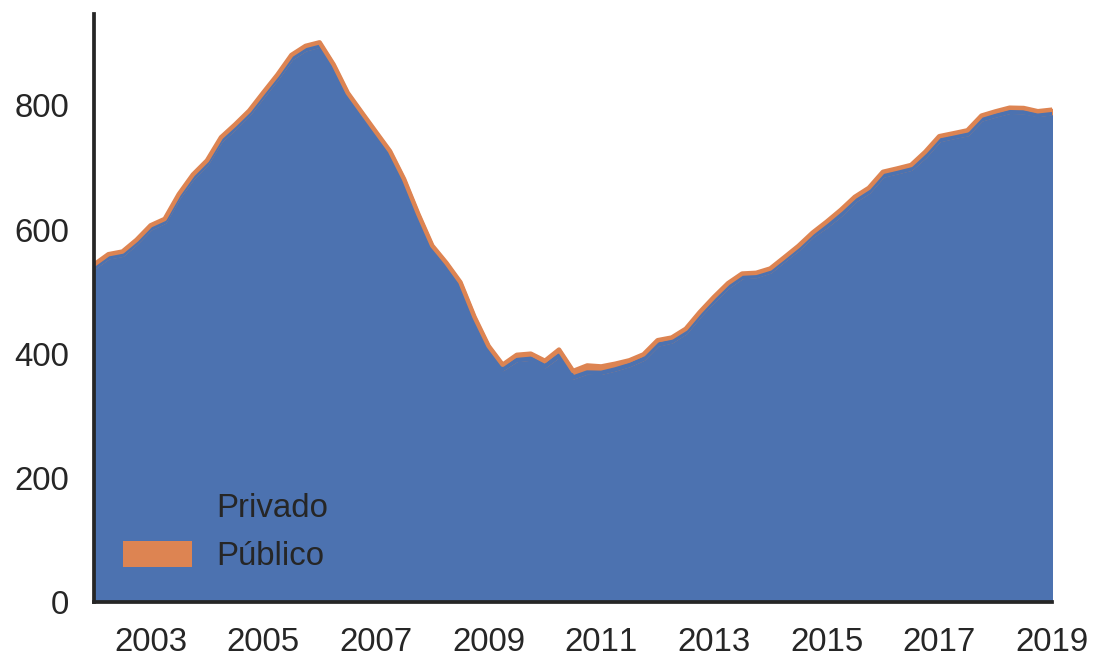

In [46]:
fig, ax = plt.subplots(figsize=(8,5))

df.plot(kind='area', stacked=True, ax=ax)

sns.despine()
sns.set_context('talk')
plt.tight_layout()
plt.show()
salvar_grafico("Imoveis_Publico_Privado")

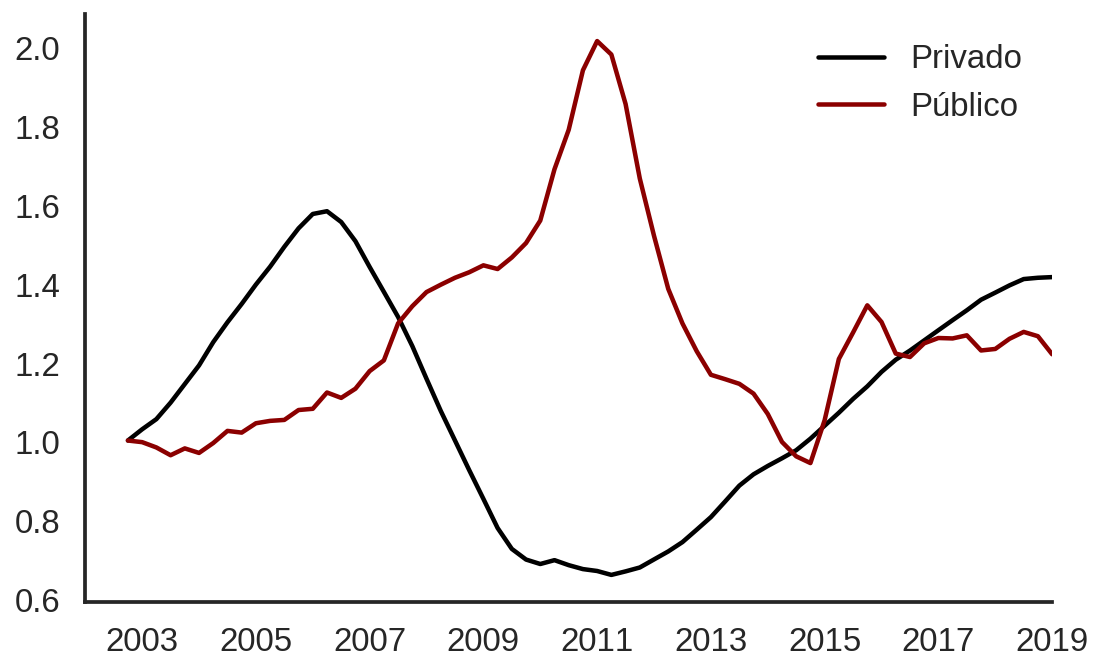

In [47]:
for i in df.columns:
    df[i] = df[i]/(df[i]['2002-04-01'])

df = df.dropna()

fig, ax = plt.subplots(figsize=(8,5))

df.rolling(4).mean().plot(
    ax=ax,
    color=('black', 'darkred'),
    ls='-'
)


ax.legend()


sns.despine()
sns.set_context('talk')
plt.tight_layout()
plt.show()

# Ciclos

## Clock-wise

In [48]:
start = dt(1951, 12, 1)
end = dt(2019, 1, 1)
df = web.DataReader(
    [
        'GDP',
        'PRFI',
        'PNFI',
        'TCU',
        'PCDG',
    ], 
    'fred', 
    start, end
)

df.columns = [
    "GDP",
    "Residential investment",
    "Non-residential investment",
    "Capacity utilization",
    "Duráveis"
]

df['Capacity utilization'] = df['Capacity utilization']/100
df['Ih/GDP'] = df['Residential investment']/df['GDP']
df['If/GDP'] = df['Non-residential investment']/df['GDP']
df['Duráveis/GDP'] = df['Duráveis']/df['GDP']
df['Ano'] = df.index.year
df = df.resample('Q').last()
df['gY'] = df['GDP'].pct_change(4)

df.index.name = ''
df = df.dropna()
df.head()

GDP  Residential investment  Non-residential investment  \
                                                                          
1967-03-31  844.170                  29.389                      97.999   
1967-06-30  848.983                  32.857                      98.297   
1967-09-30  865.233                  34.786                      98.785   
1967-12-31  881.439                  37.476                     101.744   
1968-03-31  909.387                  38.268                     105.582   

            Capacity utilization  Duráveis    Ih/GDP    If/GDP  Duráveis/GDP  \
                                                                               
1967-03-31              0.870835    71.102  0.034814  0.116089      0.084227   
1967-06-30              0.859603    74.483  0.038702  0.115782      0.087732   
1967-09-30              0.861122    74.699  0.040204  0.114172      0.086334   
1967-12-31              0.878417    75.642  0.042517  0.115429      0.085816   
1968-03-31              0.872750    80.859  0.042081  0.116102      0.088916   

             Ano        gY  
                            
1967-03-31  1967  0.060870  
1967-06-30  1967  0.054662  
1967-09-30  1967  0.055628  
1967-12-31  1967  0.057767  
1968-03-31  1968  0.077256

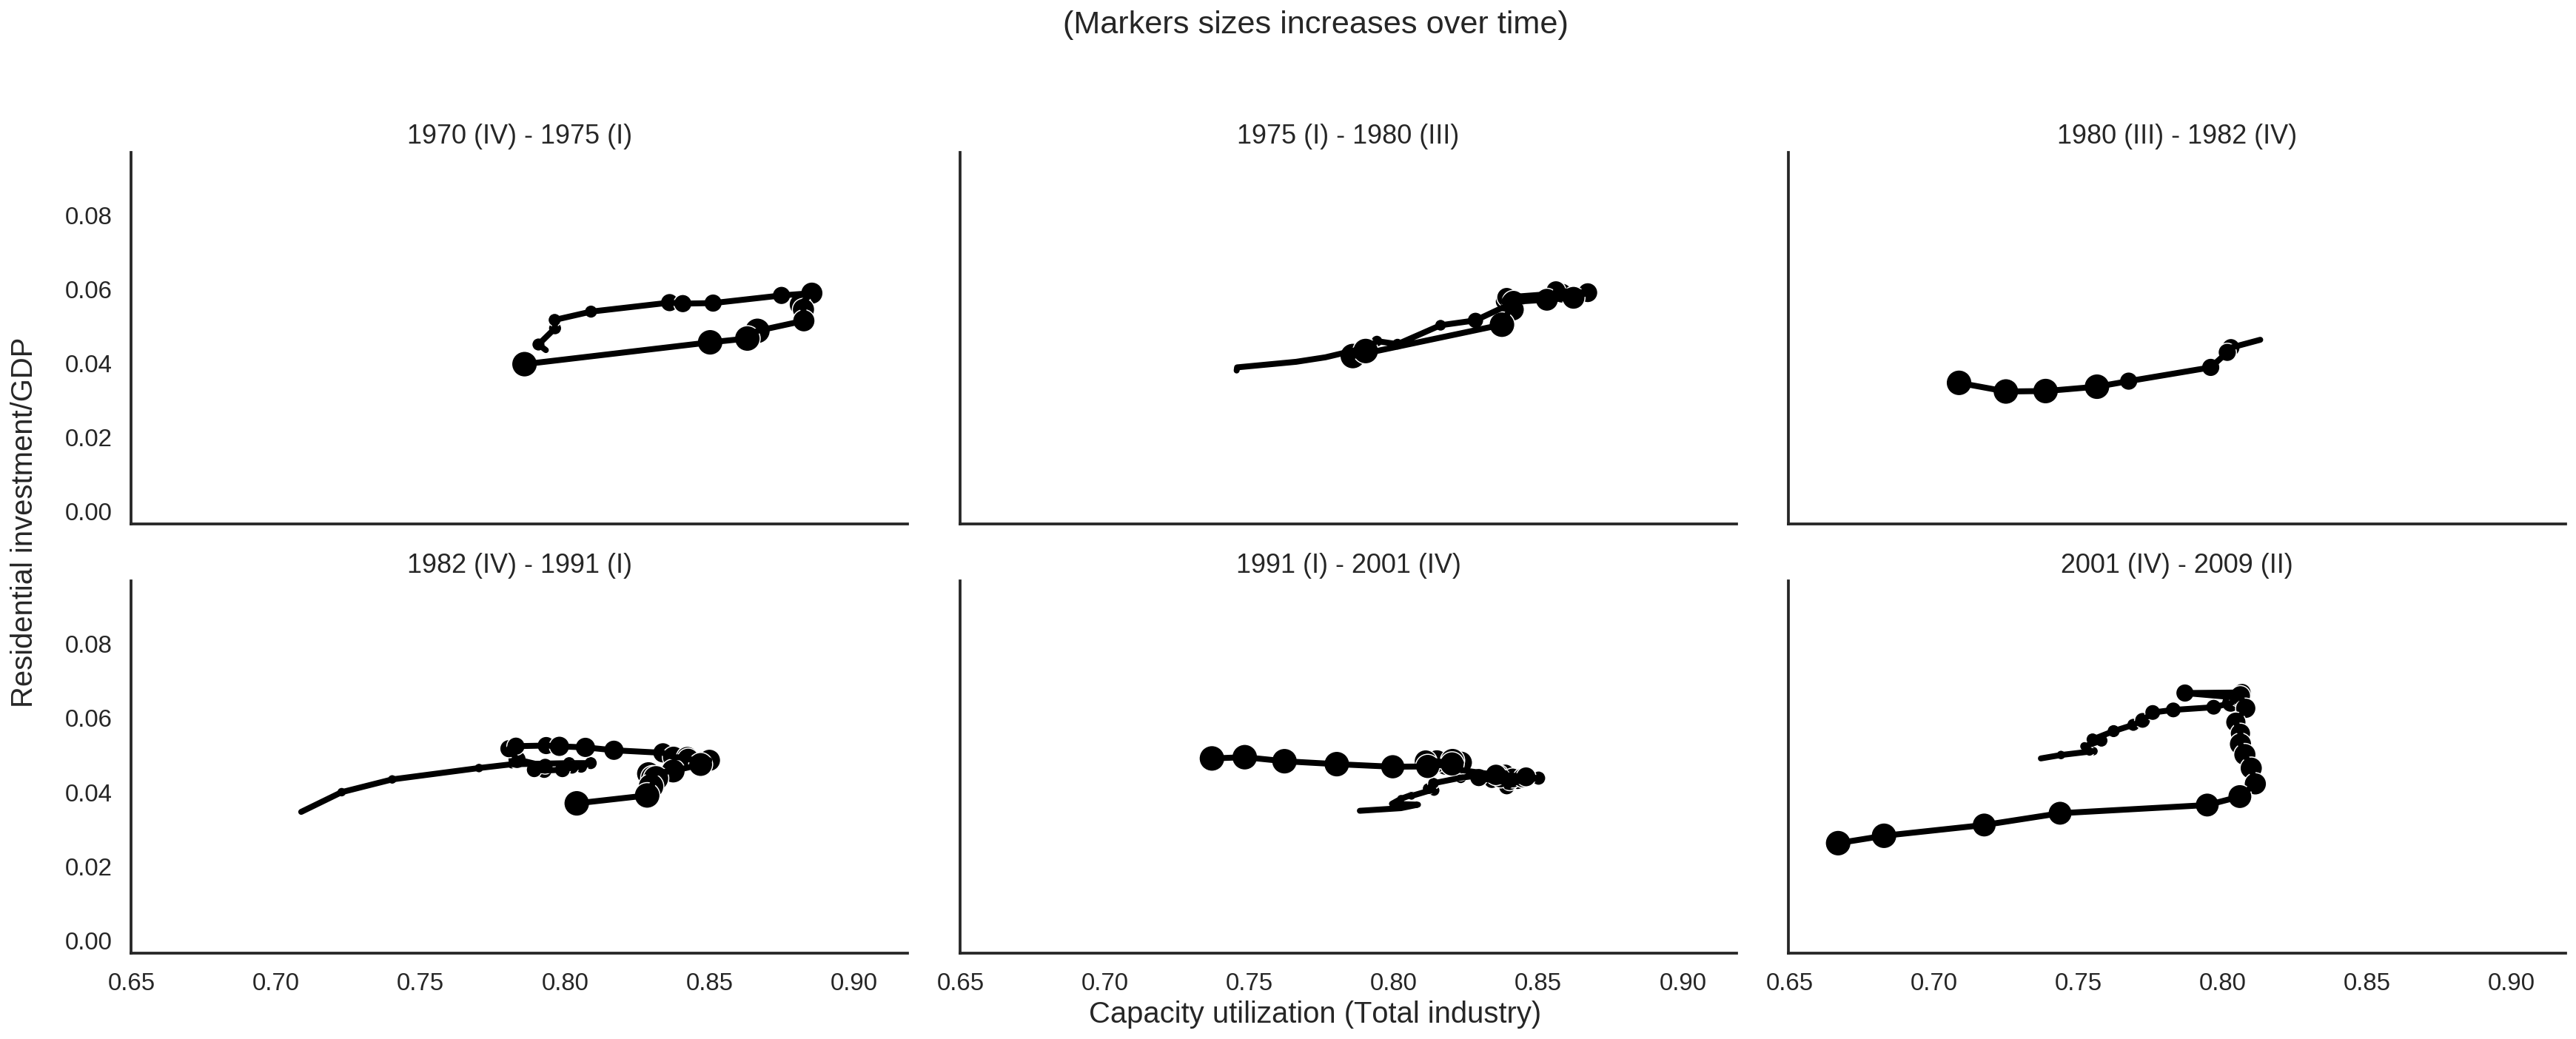

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [49]:
sns.set_context('talk')
fig, ax = plt.subplots(2,
                       3,
                       sharex=True,
                       sharey=True,
                       squeeze=False,
                       figsize=(24, 10))

sns.scatterplot(y='Ih/GDP',
                x='Capacity utilization',
                data=df["1970-12":"1975-01"],
                ax=ax[0, 0],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Capacity utilization',
             data=df["1970-12":"1975-01"],
             ax=ax[0, 0],
             sort=False,
             color='black',
             lw=4,
            )
ax[0, 0].set_title("1970 (IV) - 1975 (I)", fontsize=18)

sns.scatterplot(y='Ih/GDP',
                x='Capacity utilization',
                data=df["1975-01":"1980-10"],
                ax=ax[0, 1],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Capacity utilization',
             data=df["1975-01":"1980-10"],
             ax=ax[0, 1],
             sort=False,
             color='black',
             lw=4,)
ax[0, 1].set_title("1975 (I) - 1980 (III)", fontsize=18)

sns.scatterplot(y='Ih/GDP',
                x='Capacity utilization',
                data=df["1980-10":"1982-12"],
                ax=ax[0, 2],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Capacity utilization',
             data=df["1980-10":"1982-12"],
             ax=ax[0, 2],
             sort=False,
             color='black',
             lw=4,)
ax[0, 2].set_title("1980 (III) - 1982 (IV)", fontsize=18)

sns.scatterplot(y='Ih/GDP',
                x='Capacity utilization',
                data=df["1982-12":"1991-01"],
                ax=ax[1, 0],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Capacity utilization',
             data=df["1982-12":"1991-01"],
             ax=ax[1, 0],
             sort=False,
             color='black',
             lw=4,)
ax[1, 0].set_title("1982 (IV) - 1991 (I)")

sns.scatterplot(y='Ih/GDP',
                x='Capacity utilization',
                data=df["1991-01":"2001-12"],
                ax=ax[1, 1],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Capacity utilization',
             data=df["1991-01":"2001-12"],
             ax=ax[1, 1],
             sort=False,
             color='black',
             lw=4,)
ax[1, 1].set_title("1991 (I) - 2001 (IV)", fontsize=18)

sns.scatterplot(y='Ih/GDP',
                x='Capacity utilization',
                data=df["2001-12":"2009-07"],
                ax=ax[1, 2],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Capacity utilization',
             data=df["2001-12":"2009-07"],
             ax=ax[1, 2],
             sort=False,
             color='black',
             lw=4,)
ax[1, 2].set_title("2001 (IV) - 2009 (II)", fontsize=18)

sns.despine()
ax[0, 0].set_ylabel("")
ax[1, 0].set_xlabel('')
ax[1, 0].set_ylabel("")
ax[1, 1].set_xlabel('')
ax[1, 2].set_xlabel('')

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.text(0.5,
         0.03,
         'Capacity utilization (Total industry)',
         ha='center',
         fontsize=20)
fig.text(-0.01,
         0.5,
         'Residential investment/GDP',
         va='center',
         rotation='vertical',
         fontsize=20)
plt.suptitle(
    "(Markers sizes increases over time)"
)

plt.show()
salvar_grafico(file_name="Ciclo_Ih_u")

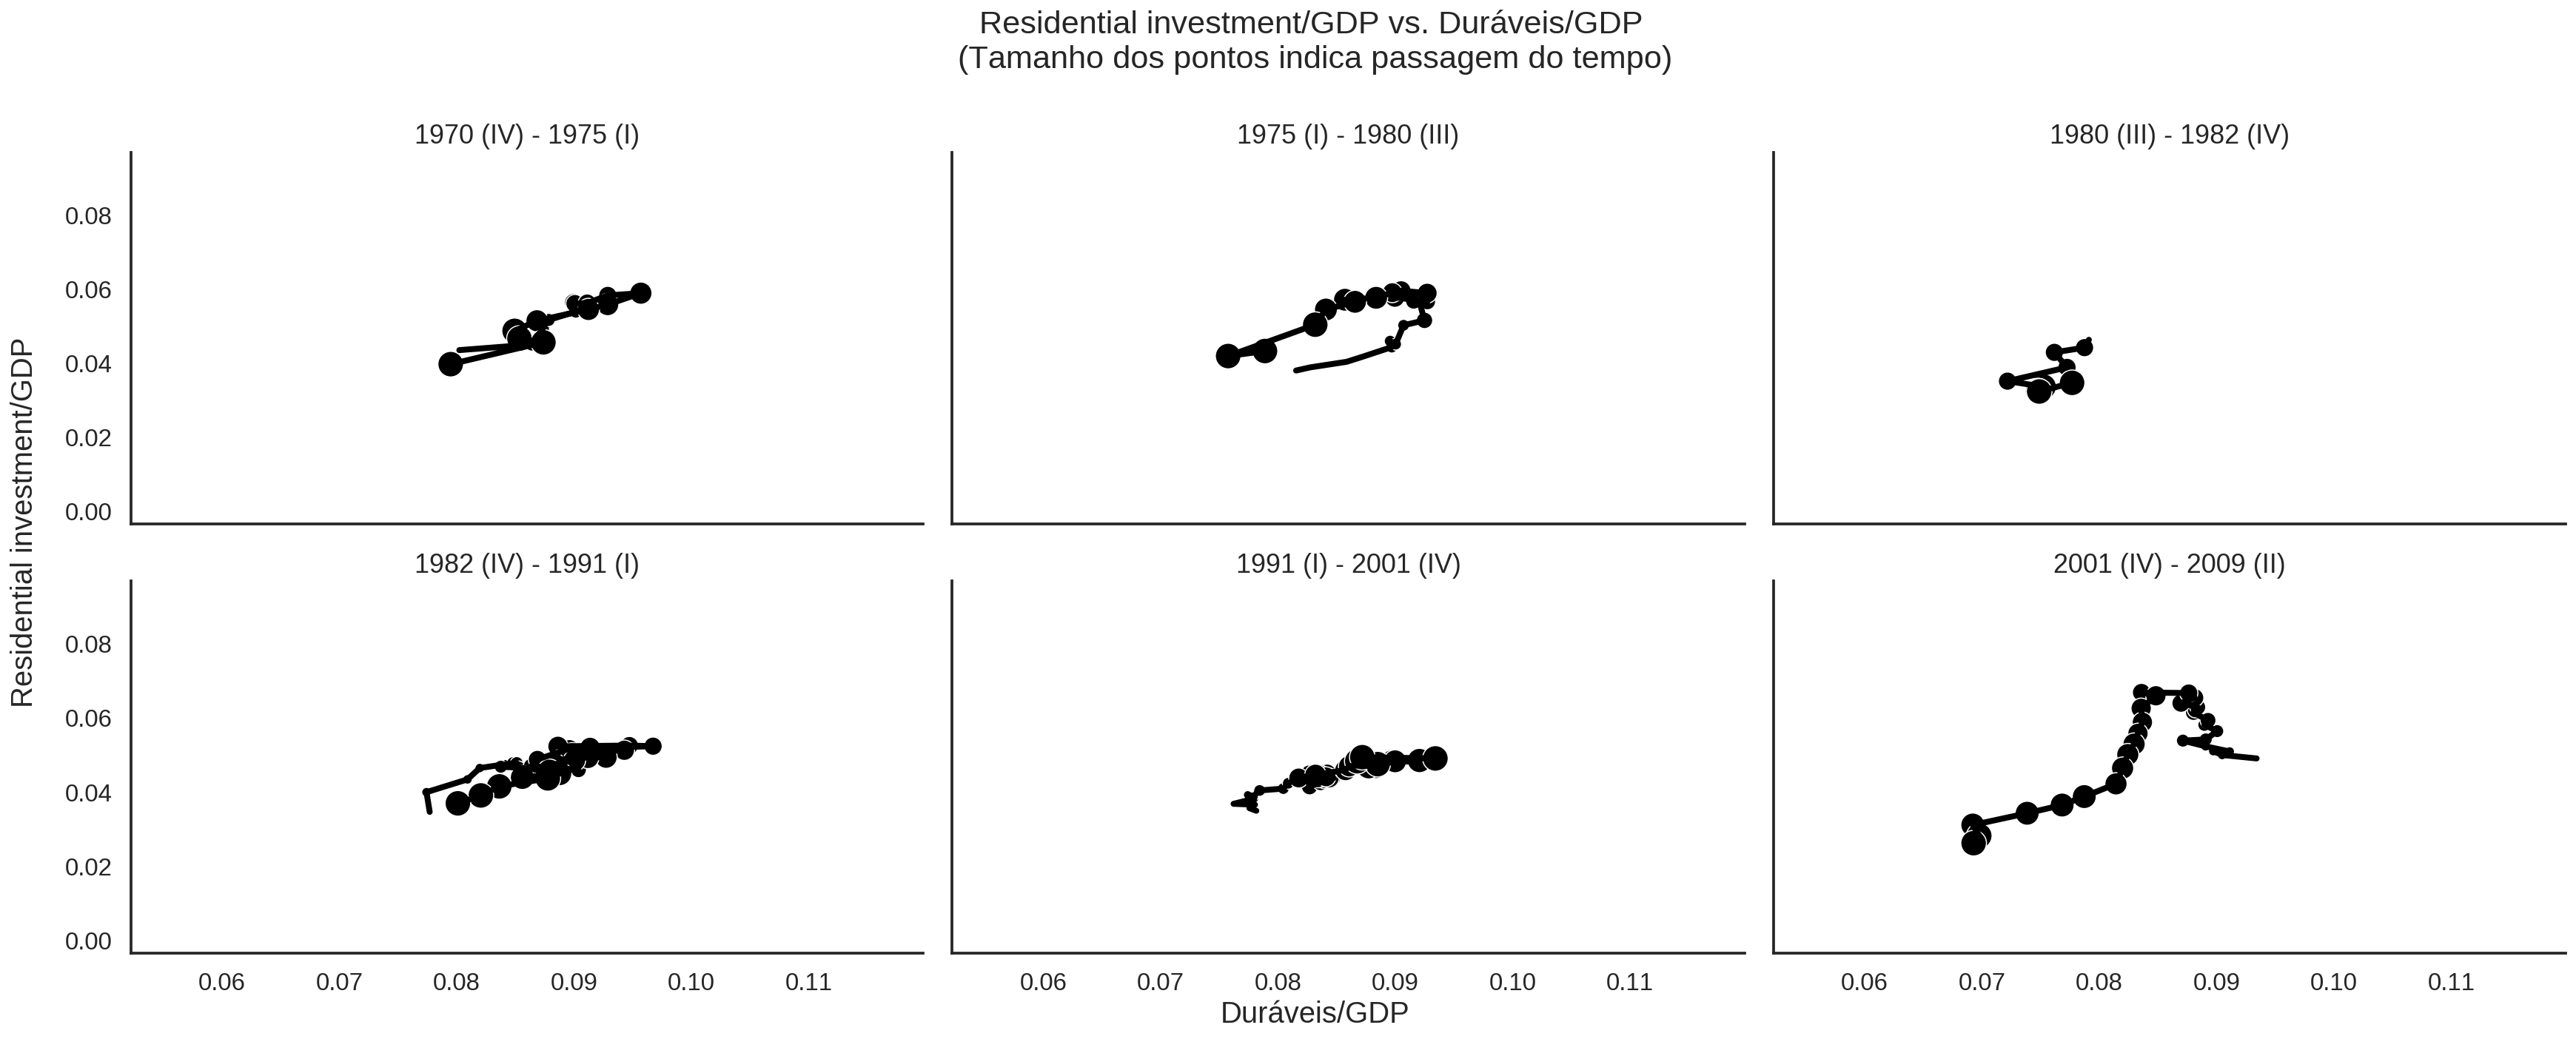

In [50]:
sns.set_context('talk')
fig, ax = plt.subplots(2,
                       3,
                       sharex=True,
                       sharey=True,
                       squeeze=False,
                       figsize=(24, 10))

sns.scatterplot(y='Ih/GDP',
                x='Duráveis/GDP',
                data=df["1970-12":"1975-01"],
                ax=ax[0, 0],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Duráveis/GDP',
             data=df["1970-12":"1975-01"],
             ax=ax[0, 0],
             sort=False,
             color='black',
             lw=4,
            )
ax[0, 0].set_title("1970 (IV) - 1975 (I)", fontsize=18)

sns.scatterplot(y='Ih/GDP',
                x='Duráveis/GDP',
                data=df["1975-01":"1980-10"],
                ax=ax[0, 1],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Duráveis/GDP',
             data=df["1975-01":"1980-10"],
             ax=ax[0, 1],
             sort=False,
             color='black',
             lw=4,)
ax[0, 1].set_title("1975 (I) - 1980 (III)", fontsize=18)

sns.scatterplot(y='Ih/GDP',
                x='Duráveis/GDP',
                data=df["1980-10":"1982-12"],
                ax=ax[0, 2],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Duráveis/GDP',
             data=df["1980-10":"1982-12"],
             ax=ax[0, 2],
             sort=False,
             color='black',
             lw=4,)
ax[0, 2].set_title("1980 (III) - 1982 (IV)", fontsize=18)

sns.scatterplot(y='Ih/GDP',
                x='Duráveis/GDP',
                data=df["1982-12":"1991-01"],
                ax=ax[1, 0],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Duráveis/GDP',
             data=df["1982-12":"1991-01"],
             ax=ax[1, 0],
             sort=False,
             color='black',
             lw=4,)
ax[1, 0].set_title("1982 (IV) - 1991 (I)")

sns.scatterplot(y='Ih/GDP',
                x='Duráveis/GDP',
                data=df["1991-01":"2001-12"],
                ax=ax[1, 1],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Duráveis/GDP',
             data=df["1991-01":"2001-12"],
             ax=ax[1, 1],
             sort=False,
             color='black',
             lw=4,)
ax[1, 1].set_title("1991 (I) - 2001 (IV)", fontsize=18)

sns.scatterplot(y='Ih/GDP',
                x='Duráveis/GDP',
                data=df["2001-12":"2009-07"],
                ax=ax[1, 2],
                size='Ano',
                sizes=(5, 300),
                color='black',
                legend=False)
sns.lineplot(y='Ih/GDP',
             x='Duráveis/GDP',
             data=df["2001-12":"2009-07"],
             ax=ax[1, 2],
             sort=False,
             color='black',
             lw=4,)
ax[1, 2].set_title("2001 (IV) - 2009 (II)", fontsize=18)

sns.despine()
ax[0, 0].set_ylabel("")
ax[1, 0].set_xlabel('')
ax[1, 0].set_ylabel("")
ax[1, 1].set_xlabel('')
ax[1, 2].set_xlabel('')

fig.tight_layout(rect=[0, 0.03, 1, 0.90])
fig.text(0.5,
         0.03,
         'Duráveis/GDP',
         ha='center',
         fontsize=20)
fig.text(-0.01,
         0.5,
         'Residential investment/GDP',
         va='center',
         rotation='vertical',
         fontsize=20)
plt.suptitle(
    "Residential investment/GDP vs. Duráveis/GDP \n(Tamanho dos pontos indica passagem do tempo)"
)

plt.show()
salvar_grafico(file_name="Ciclo_Ih_Duraveis")

# Gastos autônomos

In [51]:
df = web.get_data_fred(
    [
     'GDP',
     'EXPGS',
     'GCE',
     'PRFI',
     'HCCSDODNS', #'TOTALSL',
     'PRFI',
     'PCEC',
     'IMPGS'
    ],
    start,
    end
)

df.columns = [
    'GDP',
    'Exports', 
    'Gov. expenditures',
    'Residential investment',
    'Consumer credit',
    'Non-residential investment',
    'Consumption',
    'Importações'
]

Z = [
    'Exports',
    'Gov. expenditures',
    'Residential investment',
    'Consumer credit'
]

df['Autonomos'] = df[Z].sum(axis = 1)

df = df.resample('QS').mean()
df = df["1979":]
df.index.name= ''
df.tail()

GDP   Exports  Gov. expenditures  Residential investment  \
                                                                             
2018-01-01  20163.159  2476.586           3521.356                 783.689   
2018-04-01  20510.177  2543.602           3577.148                 789.525   
2018-07-01  20749.752  2510.294           3622.564                 788.984   
2018-10-01  20897.804  2510.517           3644.797                 784.439   
2019-01-01  21098.827  2520.278           3683.061                 787.350   

            Consumer credit  Non-residential investment  Consumption  \
                                                                       
2018-01-01         3862.221                     783.689    13728.357   
2018-04-01         3895.197                     789.525    13939.828   
2018-07-01         3956.011                     788.984    14114.559   
2018-10-01         4009.696                     784.439    14211.920   
2019-01-01         4052.481                     787.350    14266.250   

            Importações  Autonomos  
                                    
2018-01-01     3105.552  10643.852  
2018-04-01     3111.993  10805.472  
2018-07-01     3181.647  10877.853  
2018-10-01     3194.665  10949.449  
2019-01-01     3154.126  11043.170

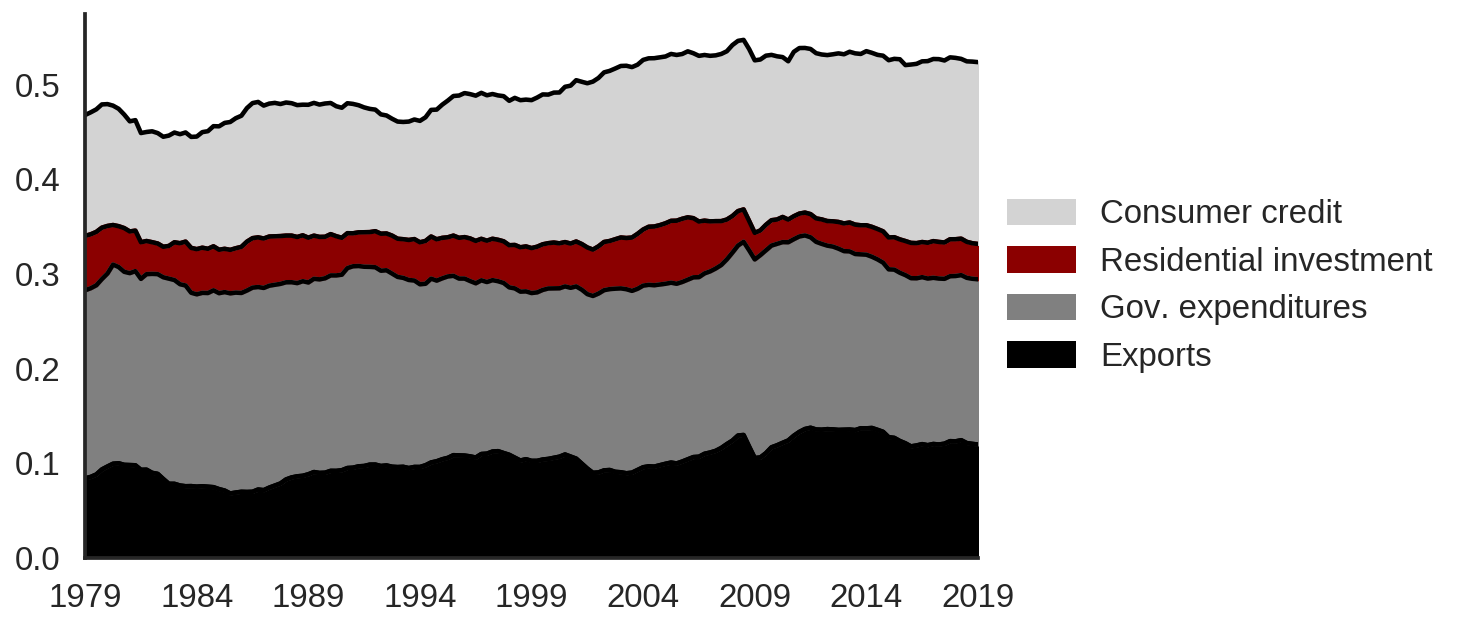

In [52]:
sns.set_context('talk')
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

df[Z].apply(lambda x: x / df['GDP']).plot(kind='area',
                                          stacked=True,
                                          ax=ax,
                                          legend=False,
                                          color=(
                                              'black',
                                              'grey',
                                              'darkred',
                                              'lightgrey',
                                          ))

df[Z].apply(lambda x: x / df['GDP']).plot(kind='line',
                                          stacked=True,
                                          ax=ax,
                                          legend=False,
                                          color='black',
                                          label=None)

#ax.set_title('Gastos autônomos\n% do GDP')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:3:-1], labels[:3:-1], loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel('')
sns.despine()
plt.show()
salvar_grafico(file_name="Gastos_autonomos")

# Política econômica

## Política monetária

In [53]:
start = dt(1947, 1, 1)
end = dt(2019, 1, 1)

df = web.DataReader(
    [
        'MORTGAGE30US', # 30-Year Fixed Rate Mortgage Average in the United States
        'FEDFUNDS', # Effective Federal Funds Rate
        'DGS10', # 10-Year Treasury Constant Maturity Rate
        'DGS30', # 30-Year Treasury Constant Maturity Rate
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    'Mortgages (30 anos)',
    'Fed funds rate',
    'Título de LP (10 anos)',
    'Título de LP (30 anos)',
]
df=((df.resample("M").mean())/100).dropna()
df.index.name = ''
df = df.rolling(12).mean().iloc[df.index>='1979-01',:]
df.head()

Mortgages (30 anos)  Fed funds rate  Título de LP (10 anos)  \
                                                                          
1979-01-31             0.097470        0.082117                0.085043   
1979-02-28             0.098523        0.084850                0.085931   
1979-03-31             0.099543        0.087600                0.086832   
1979-04-30             0.100495        0.090200                0.087689   
1979-05-31             0.101426        0.092600                0.088444   

            Título de LP (30 anos)  
                                    
1979-01-31                0.085501  
1979-02-28                0.086123  
1979-03-31                0.086787  
1979-04-30                0.087407  
1979-05-31                0.088039

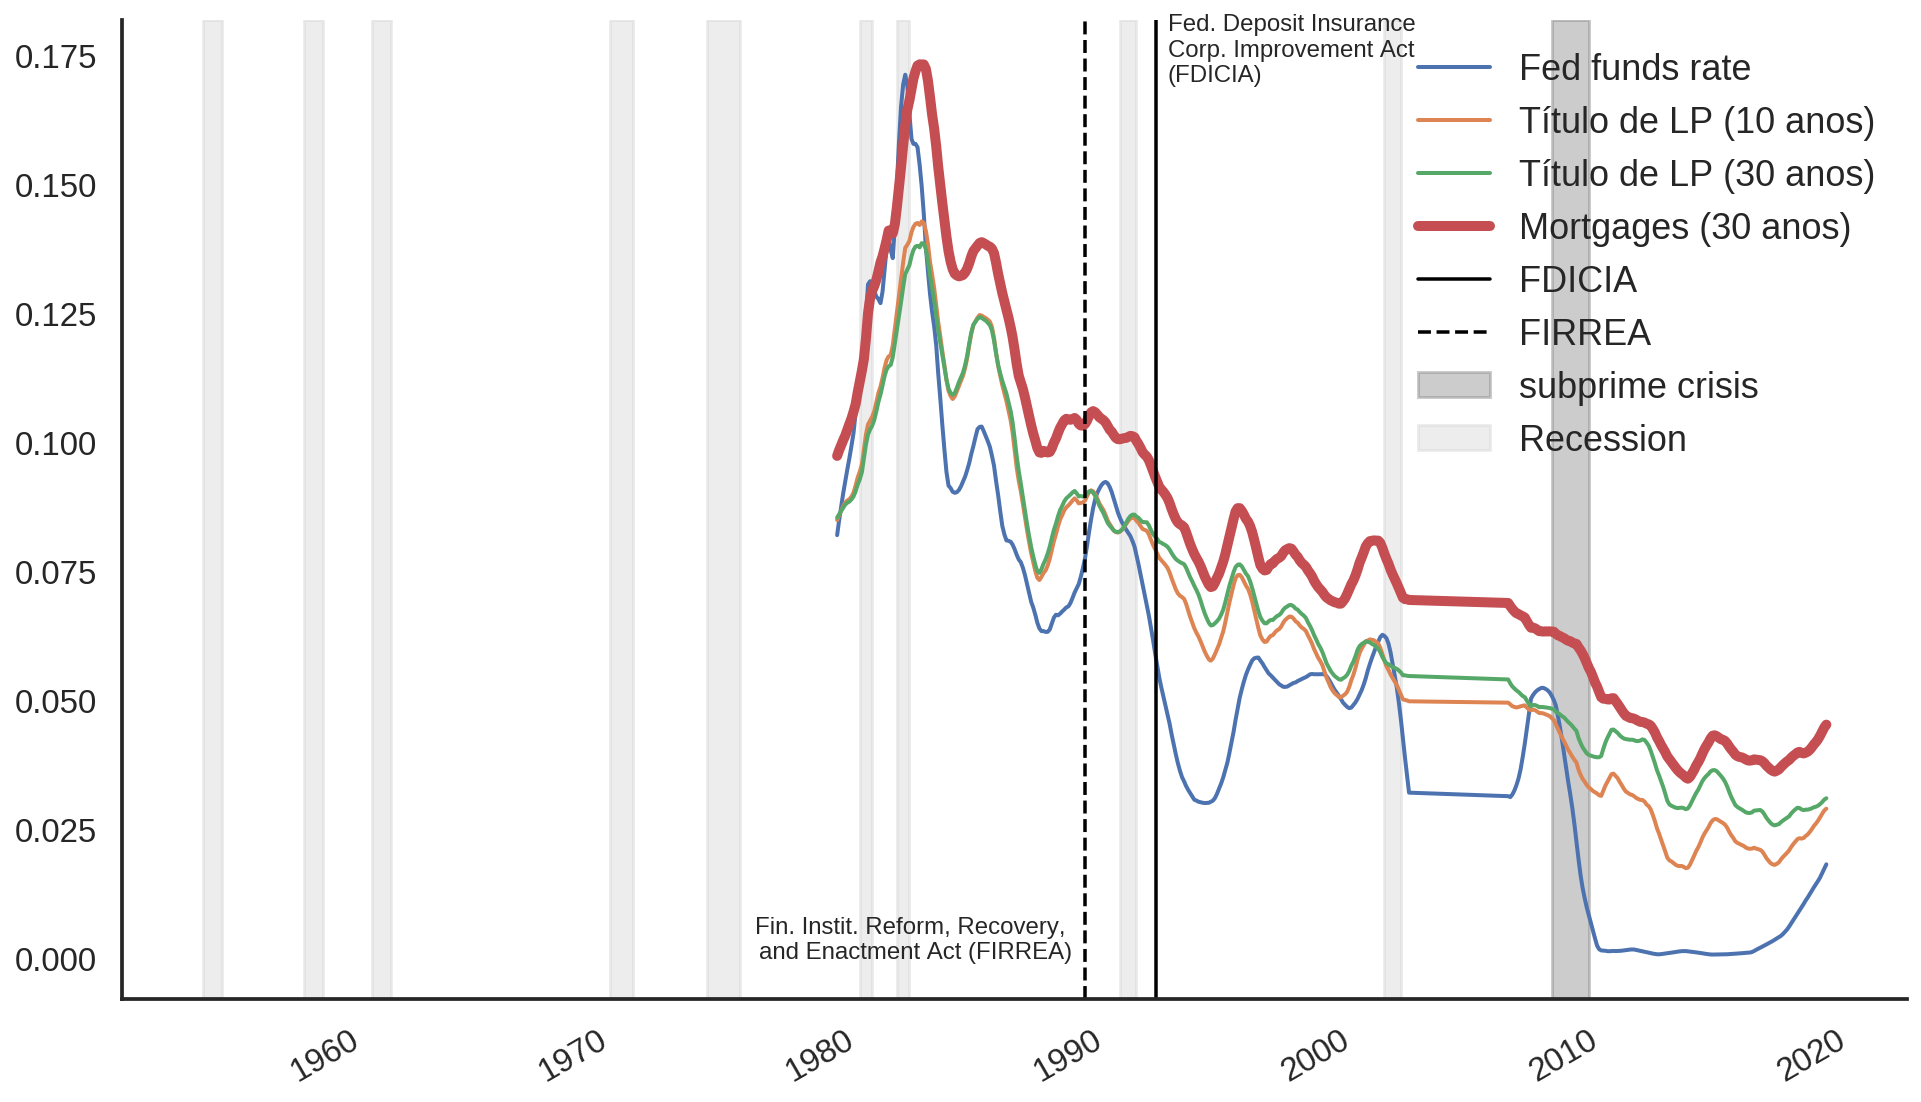

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [54]:
fig, ax = plt.subplots(figsize=(16, 10))

df.drop("Mortgages (30 anos)", axis='columns').plot(
    ax=ax,
    linewidth=2.,
)

df["Mortgages (30 anos)"].plot(
    ax=ax,
    linewidth=5,
)

crise_subprime(ax)
crises(ax)
ax.axvline(
    x="1991-12-19", 
    label='FDICIA', 
    color='black', 
    ls='-', 
    linewidth=1.75
)
ax.axvline(
    x="1989-02-06", 
    label='FIRREA', 
    color='black', 
    ls='--', 
    linewidth=1.75
)


ax.text(
    s = "Fed. Deposit Insurance \nCorp. Improvement Act \n(FDICIA)",
    y = 0.17,
    x="1992-06-01", 
    fontsize=12,
       )

ax.text(
    s = "Fin. Instit. Reform, Recovery, \nand Enactment Act (FIRREA)",
    y = 0.,
    x="1988-08-01", 
    fontsize=12,
    horizontalalignment='right'
       )
ax.legend(fontsize=18)

sns.despine()
plt.show()
salvar_grafico(file_name="Juros")

## Regulação bancária

In [55]:
pdf = 'https://www.fdic.gov/bank/historical/history/167_188.pdf'
df = pd.DataFrame(
    data = {
        "Assets": [3993, 3751, 3287, 3146, 3136, 3246, 3220, 3147, 2949, 2878],
        "Falências": [11, 34, 73, 51, 26, 54, 65, 59, 190, np.NAN],
        "Fusões supervisionadas": [21, 54, 184, 34, 14, 10, 5, 5, 6, np.NAN],
        "Fusões voluntárias": [63, 215, 215, 83, 31, 47, 45, 74, 25, np.NAN],
        "S&L insolventes": [43, 112, 415, 515, 695, 705, 672, 672, 508, 516],
    },
    index=[1980 + i for i in range(10)]
)

df

Assets  Falências  Fusões supervisionadas  Fusões voluntárias  \
1980    3993       11.0                    21.0                63.0   
1981    3751       34.0                    54.0               215.0   
1982    3287       73.0                   184.0               215.0   
1983    3146       51.0                    34.0                83.0   
1984    3136       26.0                    14.0                31.0   
1985    3246       54.0                    10.0                47.0   
1986    3220       65.0                     5.0                45.0   
1987    3147       59.0                     5.0                74.0   
1988    2949      190.0                     6.0                25.0   
1989    2878        NaN                     NaN                 NaN   

      S&L insolventes  
1980               43  
1981              112  
1982              415  
1983              515  
1984              695  
1985              705  
1986              672  
1987              672  
1988              508  
1989              516

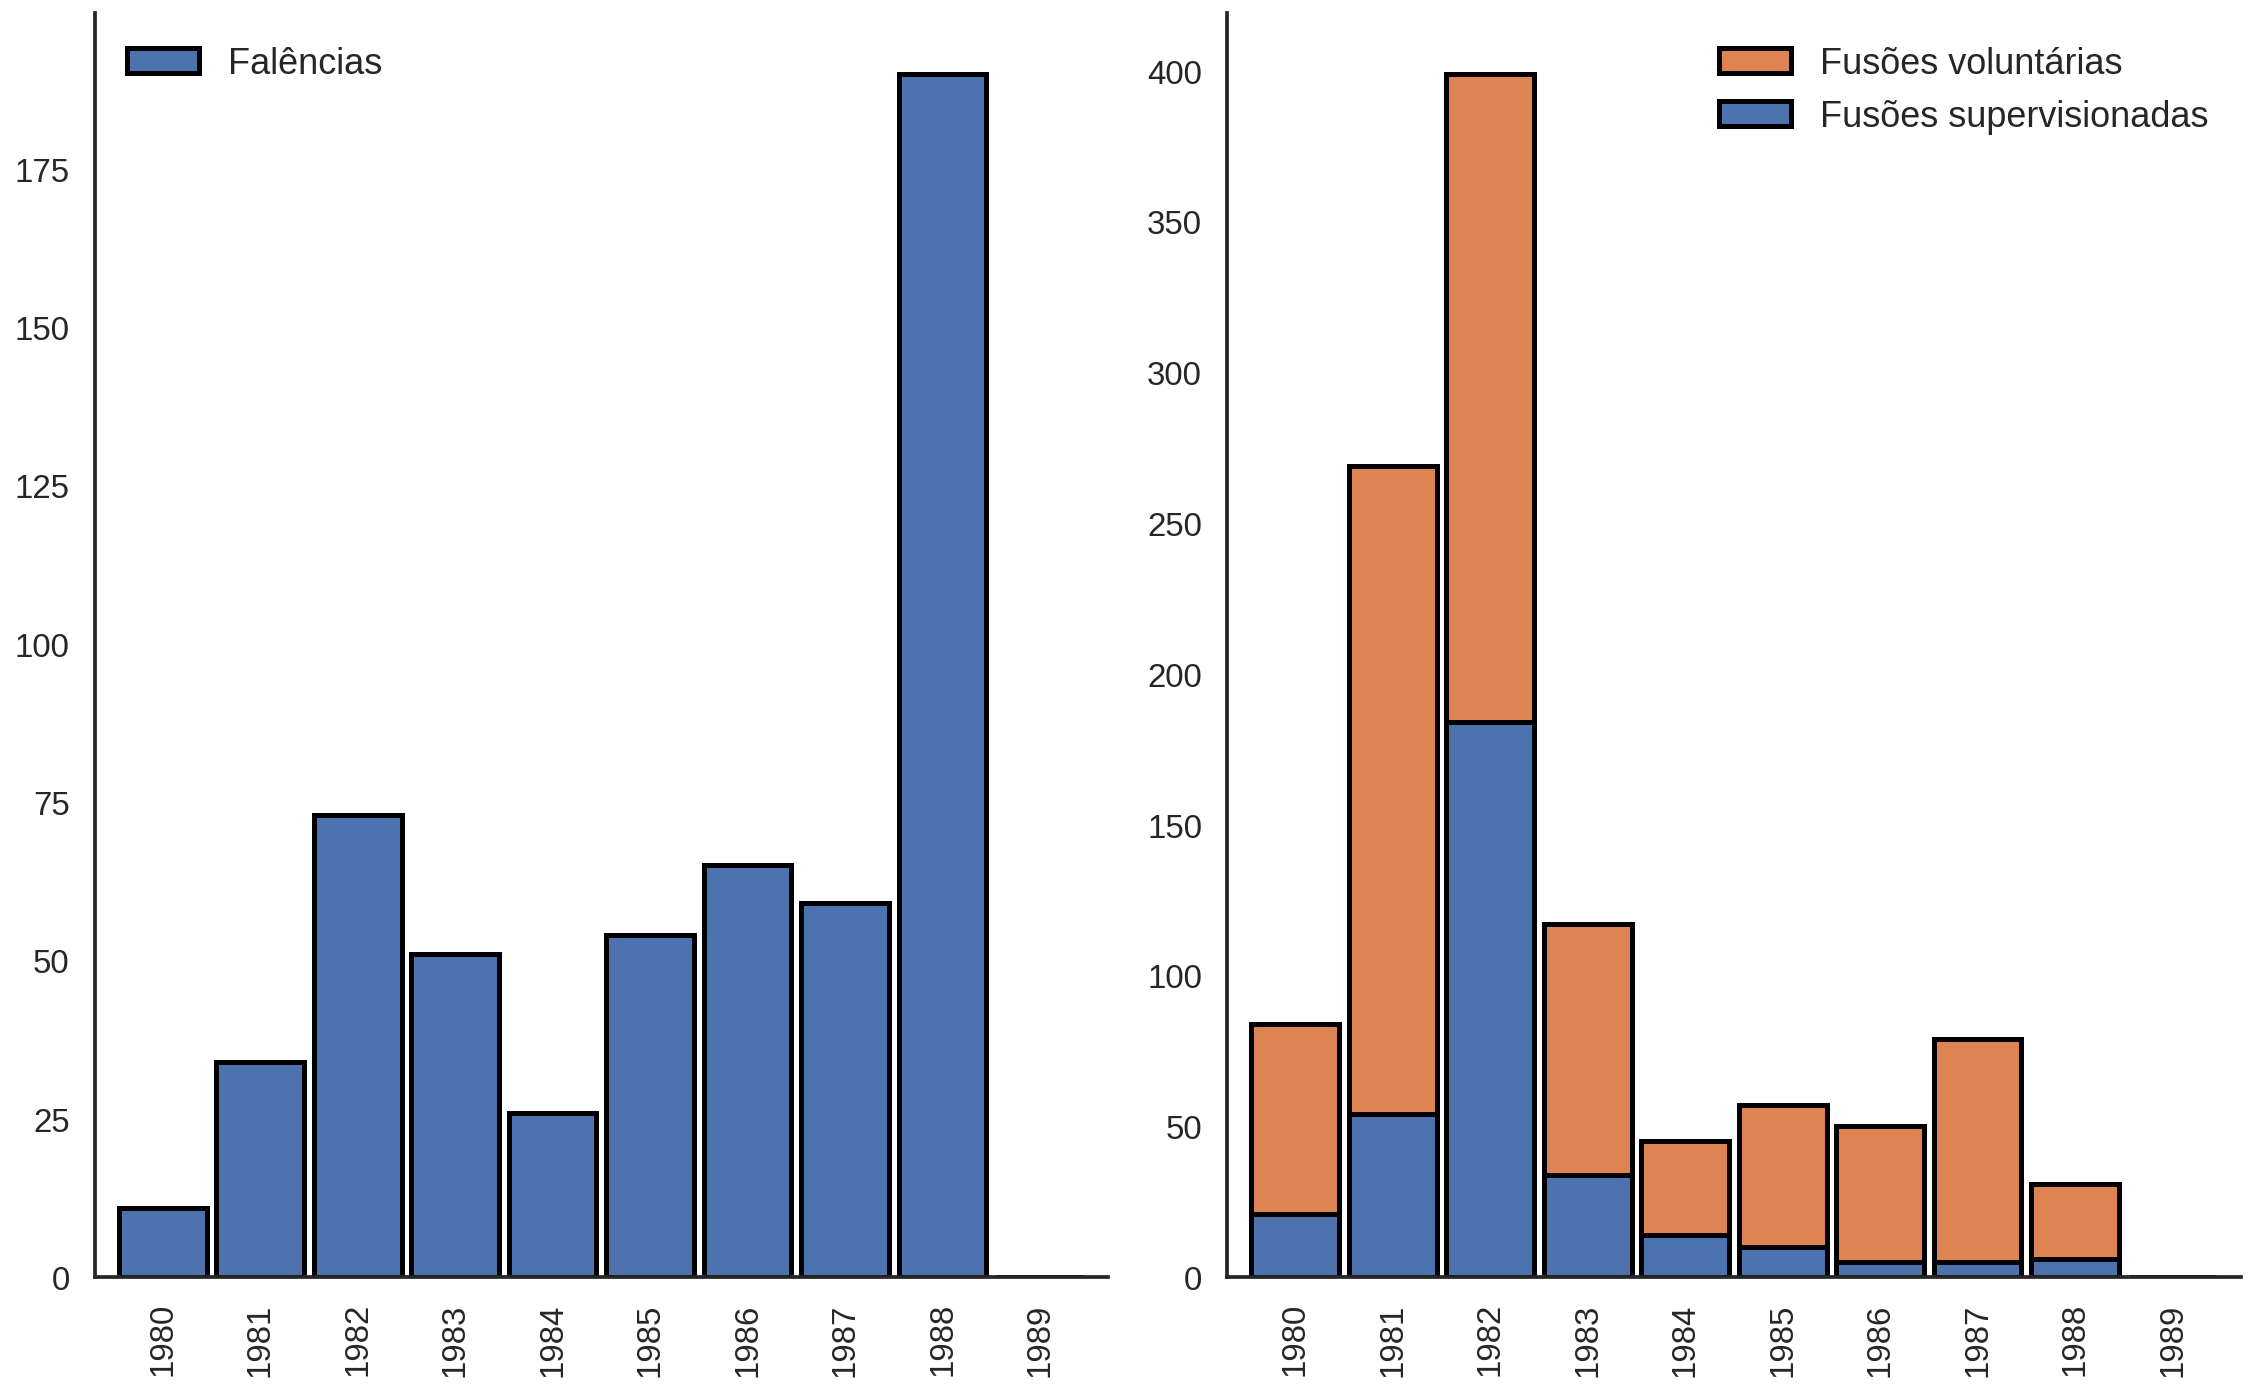

In [56]:
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(16, 10))

df[["Falências"]].plot(ax=ax[0], kind='bar', edgecolor='black', lw=2.5,stacked=True,
                                                      width=0.9)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], fontsize=18)

df[["Fusões supervisionadas", "Fusões voluntárias"]].plot(ax=ax[1],
                                                      kind='bar',
                                                      edgecolor='black',
                                                      lw=2.5,
                                                      stacked=True,
                                                      width=0.9)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], fontsize=18)

plt.tight_layout()
sns.despine()
plt.show()
salvar_grafico("Falencias_Fusoes")

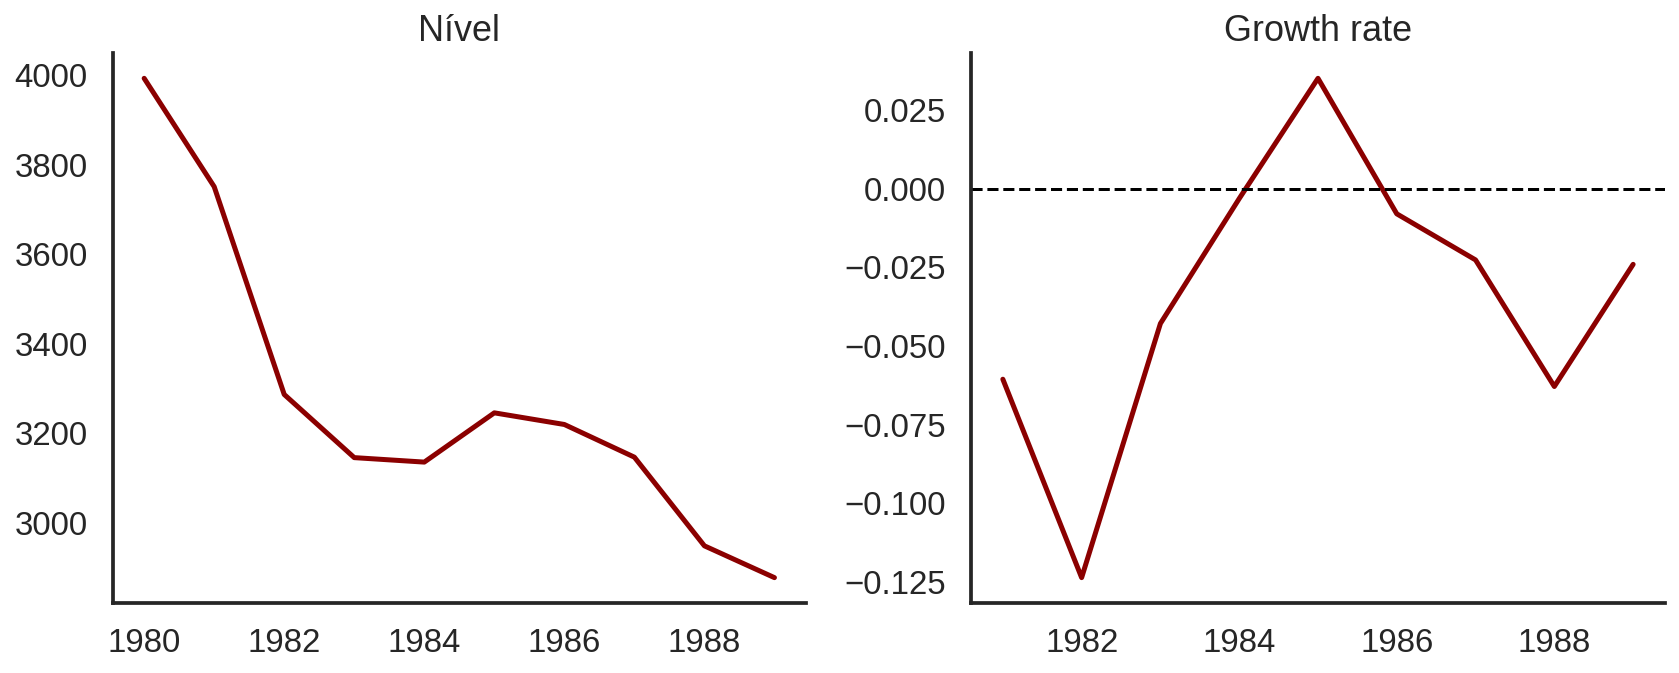

In [57]:
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

df[["Assets"]].plot(ax=ax[0], lw=2.5, color='darkred', title="Nível", legend=False)
df[["Assets"]].pct_change().plot(ax=ax[1], lw=2.5, color='darkred', title="Growth rate", legend=False)
ax[1].axhline(y=0, ls='--', color='black', lw=1.5)

plt.tight_layout()
sns.despine()
plt.show()
salvar_grafico(file_name="Numero_S&L")

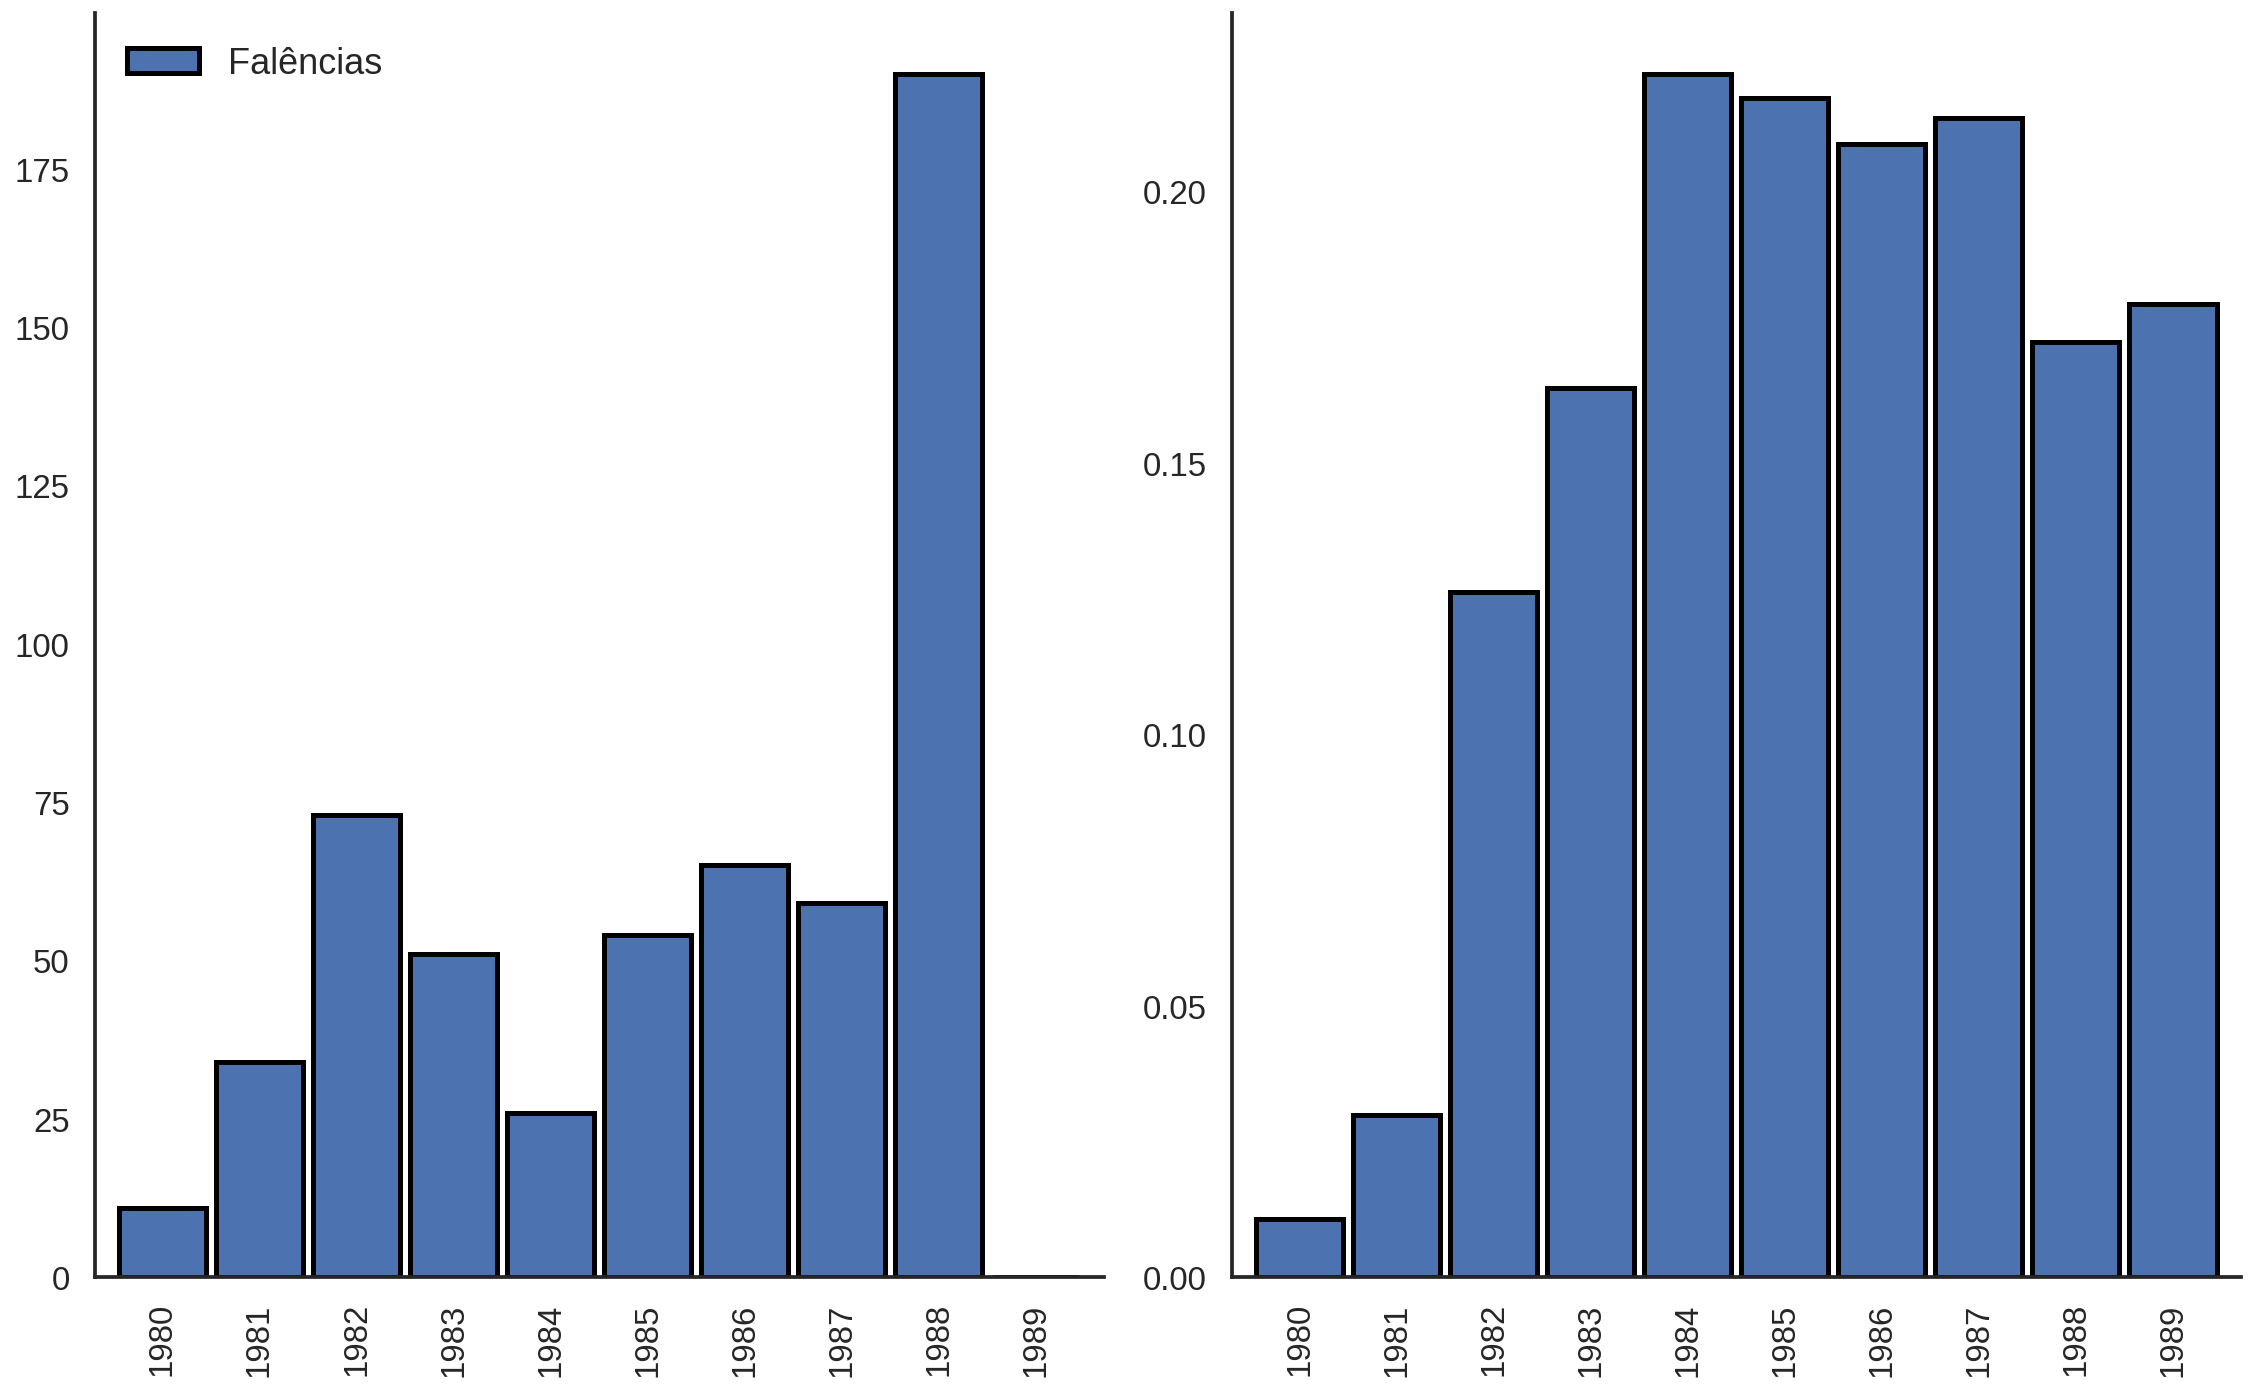

In [58]:
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(16, 10))

df[["Falências"]].plot(ax=ax[0], kind='bar', edgecolor='black', lw=2.5,stacked=True,
                                                      width=0.9)
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], fontsize=18)

(df["S&L insolventes"]/df["Assets"]).plot(ax=ax[1], kind='bar', edgecolor='black', lw=2.5,stacked=True,
                                                      width=0.9)


plt.tight_layout()
sns.despine()
plt.show()

# Taxa Própria

In [59]:
start=dt(1987,1,1)
end=dt(2019,10,1)

df = web.DataReader(
    [
        "PRFI",
        "CSUSHPISA",
        "MORTGAGE30US",
        "CPIAUCSL"
    ], 
    'fred', 
    start, 
    end
)

df.columns = [
    "Residential Investment", 
    "House Prices", 
    "Interest rate",
    "Prices"
]
df.index.name = ""


df['Interest rate'] = df['Interest rate'].divide(100)
df = df.resample('M').last()

df['House Prices'] = df['House Prices']/df['House Prices'][0]
df = df.resample('Q').last()
df["Inflation"]= df["House Prices"].pct_change()
df["General inflation"] = df["Prices"].pct_change()
df["Own interest rate"] = ((1+df["Interest rate"])/(1+df["Inflation"])) -1
df["Real mortgages interest rate"] = ((1+df["Interest rate"])/(1+df["General inflation"])) -1

df['$g_{I_h}$'] = df["Residential Investment"].pct_change()

df.head()

Residential Investment  House Prices  Interest rate  Prices  \
                                                                          
1987-03-31                 246.672      1.012065         0.0903   112.2   
1987-06-30                 249.693      1.032803         0.1035   113.5   
1987-09-30                 249.969      1.052416         0.1102   114.7   
1987-12-31                 252.825      1.070857         0.1061   115.6   
1988-03-31                 250.115      1.088595         0.0999   116.5   

            Inflation  General inflation  Own interest rate  \
                                                              
1987-03-31        NaN                NaN                NaN   
1987-06-30   0.020491           0.011586           0.081342   
1987-09-30   0.018990           0.010573           0.089510   
1987-12-31   0.017522           0.007847           0.087052   
1988-03-31   0.016564           0.007785           0.081978   

            Real mortgages interest rate  $g_{I_h}$  
                                                     
1987-03-31                           NaN        NaN  
1987-06-30                      0.090861   0.012247  
1987-09-30                      0.098585   0.001105  
1987-12-31                      0.097488   0.011425  
1988-03-31                      0.091403  -0.010719

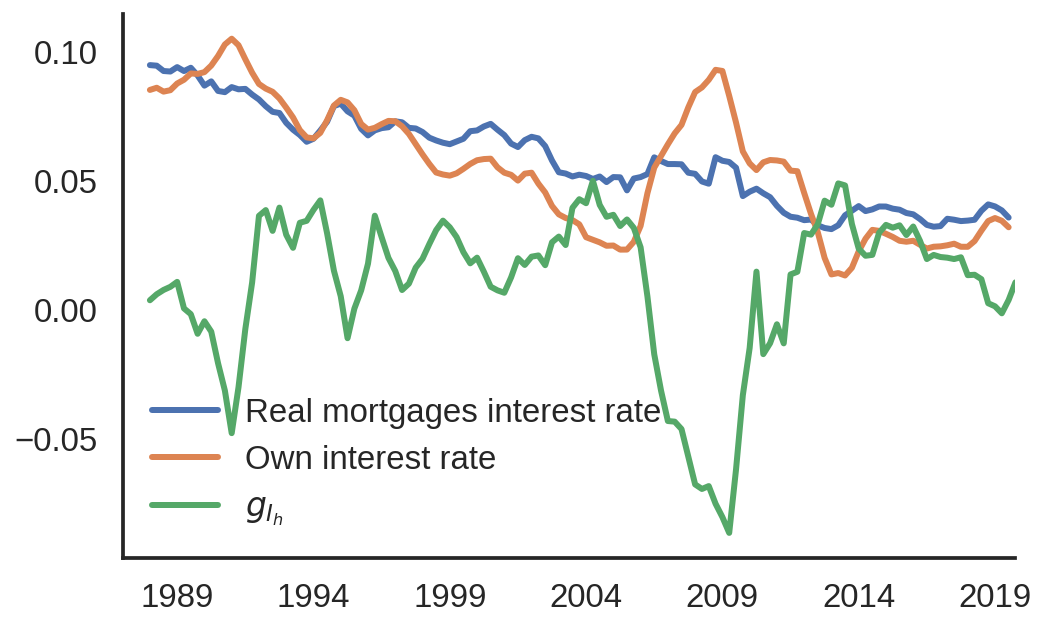

In [60]:
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(8,5))

df[['Real mortgages interest rate', "Own interest rate", '$g_{I_h}$']].rolling(4).mean().plot(ax=ax, lw=3)

sns.despine()
plt.show()

salvar_grafico("TxPropria_Investo")

In [61]:
df = pd.read_csv("../data/Data_yeojohnson.csv", index_col=[0], parse_dates=True)
df.head()

Inflation       gIh  Own Interest rate  Interest rate
1992-03-31   0.002985  0.065517           0.120443         0.0898
1992-06-30   0.000760  0.052722           0.114776         0.0843
1992-09-30  -0.001179  0.007945           0.111158         0.0802
1992-12-31   0.005732  0.063046           0.100196         0.0814
1993-03-31   0.002504  0.011942           0.095222         0.0750

/home/gpetrini/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


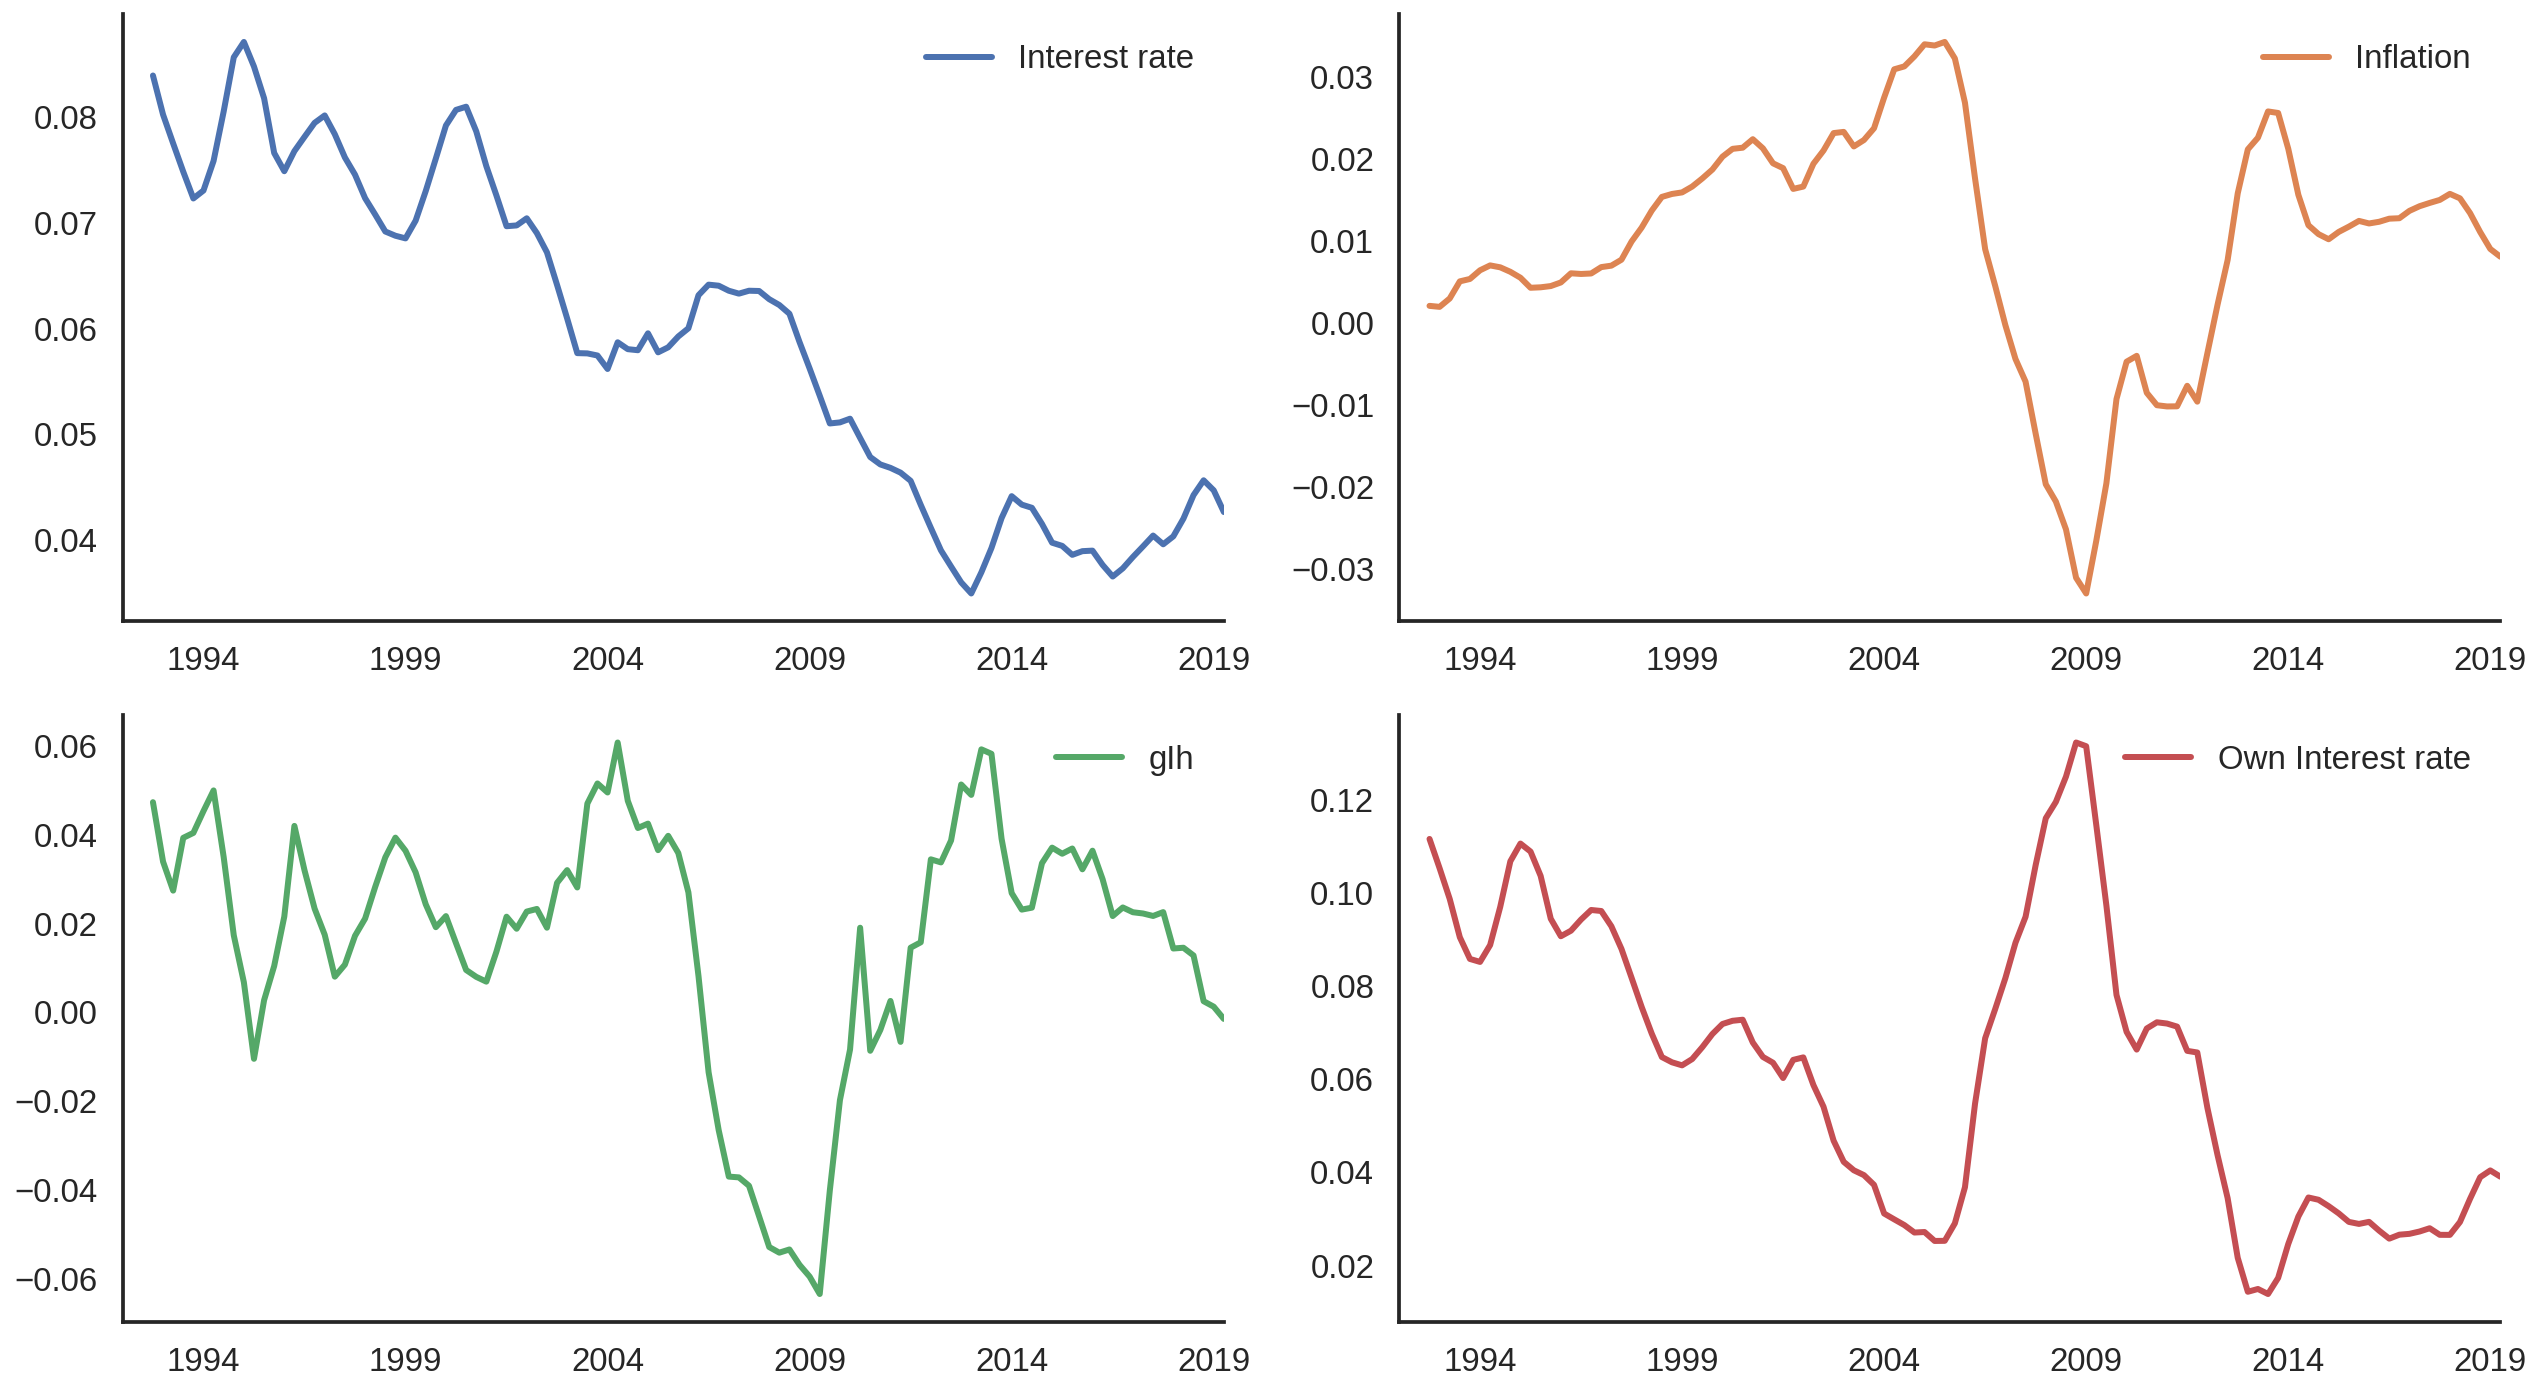

In [62]:
fig, ax = plt.subplots(figsize=(18,10), sharey=True)

df[[
    'Interest rate', 
    "Inflation", 
    "gIh", 
    "Own Interest rate"
]].rolling(4).mean().plot(
    ax=ax, 
    subplots=True, layout=(2,2),
    #subplots=False, 
    lw = 3,
)

plt.tight_layout()
sns.despine()
plt.show()

salvar_grafico("YeoJohnson_All", extension="eps")

# Encenrando

In [63]:
print(f'Tempo de execução: {dt.now() - t1}')

Tempo de execução: 0:01:52.660418
